# File to explore time dependant data and create (preliminary plots)

## Create run scripts and test data

- Extract snapshot times-function is in archive-folders

- Some boxes on creating spherically symmetric distribution outside the box.
  These can be modidified to be dependent on snapshot-specific data, ie
  gas-to-dust-ratio and average dust density at 14-15au.

In [3]:
# Create run-files
import create_r3d_functions as c3d

outpaths = [
    '../r3dsims/st28gm06n052/',
    '../r3dsims/st28gm06n074/',
    '../r3dsims/st28gm06n075/',
]
# Phase numbers are always 3 digits, leading 0s if needed.
phaseslist = [
    [f'{phase:03d}' for phase in range(40,49+1)],
    [f'{phase:03d}' for phase in range(90,99+1)],
    [f'{phase:03d}' for phase in range(80,89+1)],
]
for outpath,phases in zip(outpaths,phaseslist):
    c3d.write_r3d_runscripts(
        path = outpath,
        phase_list = phases,
        sed_angles_list = [
            [0,0],
            [90,0],
            [180,0],
            [270,0],
            [90,90],
            [90,270],
        ],
        image_wavelength_list = [0.62,2,10],
        image_angles_list = [
            [0,0],
            [90,0],
            [180,0],
            [270,0],
            [90,90],
            [90,270],
        ],
        image_sizeau = 30,
        image_npix = 512,
        Nscripts = 1
    )


Finished writing 10 run-r3d-scripts

Finished writing 10 run-r3d-scripts

Finished writing 10 run-r3d-scripts



In [23]:
# Extract dust masses from r3d-log output

#modelname = 'st28gm06n052'
#phases = [
#    phase for phase in range(256,265+1)
#]
phases = [256]
# Loop through phases
for phase in phases:
    totalmass = 0
    # Load beginning of log-file
    with open(f'r3dout_{phase}_1.txt', 'r') as flog:
        # Loop through beginning of log file, dust mass always starts at
        # line 38
        for nline,line in enumerate(flog.readlines()):
            if nline >= 38 and nline <= 50:
                # Extract lines with dust masses
                if line.split()[:4] == ['Dust', 'mass', 'in', 'species']:
                    # Dust mass is 6th element of split

                    masses = float(line.split()[6])

                    totalmass += masses

            if nline > 50:
                break
    # Output total mass and phase number
    print(f'    {phase}      {totalmass}')


    256      1.2982539038591769e-08


In [1]:
# Create spherical dust density distribution outside the co5bold-box
# very approximative, just to test effect on SED by using results from
# inner box SED as emitting point source star
import create_r3d_functions as c3d
import os

AUcm = 1.49598e13 # cm
inradius = 15
outradius=1000
outputpath='../r3dresults/st28gm06n052_largesphere/'

# Create grid
c3d.create_grid(
    gridedge=outradius, 
    nxyz=10, 
    refinementlist=[800,600,400,200], 
    inrefine=14, 
    savegrid=True
)
os.system(f'mv ../amr_grid.inp {outputpath}')
os.system(f'mv ../grid_distances.csv {outputpath}')
os.system(f'mv ../grid_cellsizes.csv {outputpath}')
os.system(f'mv ../grid_info.txt {outputpath}')




Creating amr_grid with octree refinement.
  Final length of total side of whole grid: 1000 AU
  Number of base cells along one side of the grid: 10
  Distances to outer refinement limits from centrum:
    [800, 600, 400, 200] AU
  Distances to inner refinement limits from centrum:
    [3.5, 7.0, 10.5, 14.0] AU
  Number refinements: 4

  Size of base cell: 100.0 AU
  Child cell size 1: 50.0 AU
  Child cell size 2: 25.0 AU
  Child cell size 3: 12.5 AU
  Child cell size 4: 6.25 AU
  Writing amr_grid.inp
  Writing grid_distances.csv and grid_cellsizes.csv
(Not necessary for Radmc3d, but useful for pre/postprocessing of your model. They have the same order as dust_densities.inp)
  Writing grid_info.txt
Create grid:
    amr_grid.inp
    grid_info.txt
    grid_distances.csv
    grid_cellsizes.csv
DONE



0

In [1]:
# Create spherical dust density distribution outside the co5bold-box
# very approximative, just to test effect on SED by using results from
# inner box SED as emitting point source star
# Create density

import create_r3d_functions as c3d
import os

AUcm = 1.49598e13 # cm
inradius = 15
outradius=1000
outputpath='../r3dresults/st28gm06n052_largesphere/'

c3d.create_spheredensity(
    optconstlist=['mg2sio4'],
    agrainlist=[0.95],
    totaldustmass=2.5e-6*1.989e33,
    densitypower=-2,
    inradius=inradius,
    outradius=outradius,
    outputpath=outputpath
)


Running create_spheredensity():
  Loading grid distances
  Loading grid cell sizes
  Writing dust_density.inp
  Finished dust_density.inp, moved to outputpath
  Total dust mass is 3.663759664314922e+27 g (1.8420108920638119e-06 Msol)
create_spheredensity: Done


/home/joachim/exwings/exwings-codes/analyze_r3d_functions.py:1096: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


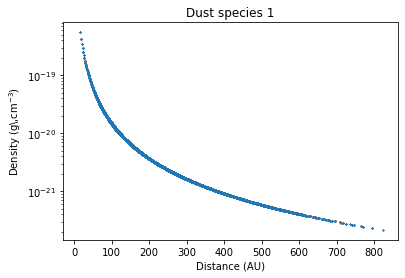

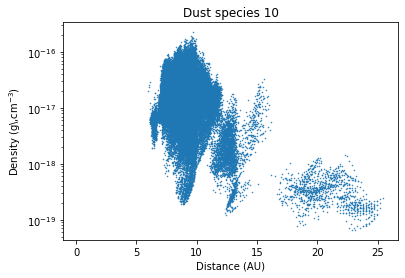

In [1]:
# plot to check densities
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt

outputpath='../r3dresults/st28gm06n052_largesphere/'

a3d.plot_onedensity_radius(
    density_path=outputpath+'dust_density.inp',
    grid_path=outputpath+'grid_distances.csv',
    amr_path=outputpath+'amr_grid.inp',
    numb_specie=1
)
plt.yscale('log')


# Plot to compare numbers with inner densities
# Only plot last (largest grain size) species
a3d.plot_onedensity_radius(
    density_path=outputpath+'innerdata/dust_density_dust.inp',
    grid_path=outputpath+'innerdata/grid_distances.csv',
    amr_path=outputpath+'innerdata/amr_grid.inp',
    numb_specie=10
)
plt.yscale('log')


In [3]:
# Extract spectrum adn write stars.inp
import analyze_r3d_functions as a3d

#model = '199_i090_phi270'
model = '225_i090_phi090'

wavelengths, spectrum = a3d.load_spectrum(
    path=f'../r3dresults/st28gm06n052_largesphere/{model}/spectrum_i090_phi090.out'
)
with open(f'../r3dresults/st28gm06n052_largesphere/{model}/stars_fix.inp', 'w') as f:
    for wavelength in wavelengths:
        f.write(f'{wavelength}\n')
    for flux in spectrum:
        f.write(f'{flux/1e23}\n')

# and write wavelength-file
with open(f'../r3dresults/st28gm06n052_largesphere/{model}/wavelength_micron.inp', 'w') as fwave:
    fwave.write(f'{int(len(wavelengths))}\n')
    for wavelength in wavelengths:
        fwave.write(f'{wavelength}\n')





## Remove spikes in SEDs and images

Doing folder: ../r3dresults/st28gm06n052_timedep
Doing folder: ../r3dresults/st28gm06n074
Doing folder: ../r3dresults/st28gm06n075


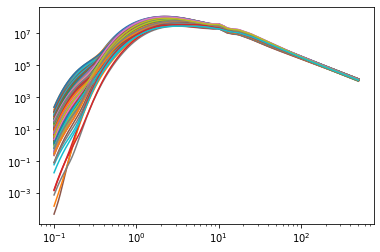

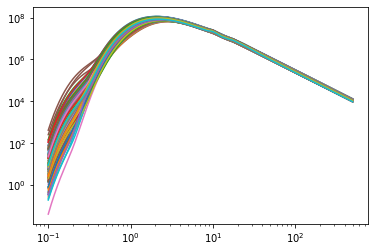

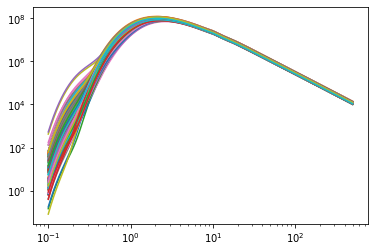

In [1]:
# Remove spikes from SED
# Merge SEDs with different seeds
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
import os

folders = [
    '../r3dresults/st28gm06n052_timedep',
    '../r3dresults/st28gm06n074',
    '../r3dresults/st28gm06n075',
]
phaseslist = [
    [phase for phase in range( 40, 59+1)],
    [phase for phase in range( 90,109+1)],
    [phase for phase in range( 80, 99+1)],
]
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
for folder,phases in zip(folders,phaseslist):
    print(f'Doing folder: {folder}')
    for phase in phases:
        for angle in angles:
            a,b = a3d.remove_sedspikes(
                paths = [
                            f'{folder}_1/{phase:03d}/spectrum_{angle}.out',
                            f'{folder}_2/{phase:03d}/spectrum_{angle}.out',
                            f'{folder}_3/{phase:03d}/spectrum_{angle}.out',
                        ],
                save=True
            )
            if os.path.exists(f'{folder}_nospikes/{phase:03d}') == False:
                os.system(f'mkdir {folder}_nospikes/{phase:03d}')
            os.system(f'mv ../spectrum.out {folder}_nospikes/{phase:03d}/spectrum_{angle}.out')

            plt.figure(num=folder)
            plt.plot(a,b)
            plt.xscale('log')
            plt.yscale('log')



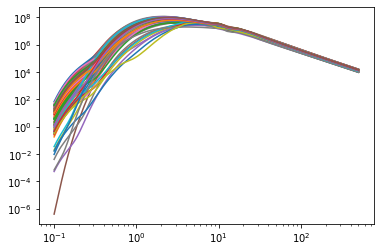

In [2]:
# Extra remove spikes from SED, for those who need an extra seed
# Merge SEDs with different seeds
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
import os

folder = '../r3dresults/st28gm06n052_timedep'
#folder = '../r3dresults/st28gm06n074'
#folder = '../r3dresults/st28gm06n075'

phases = [
    182,
    217,
    225,
    251,
    260,
    263,
    296,
    297,
    299,
    364,
    391,
]
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
for phase in phases:
    for angle in angles:
        a,b = a3d.remove_sedspikes(
                paths = [
                            f'{folder}_1/{phase}/spectrum_{angle}.out',
                            f'{folder}_2/{phase}/spectrum_{angle}.out',
                            f'{folder}_3/{phase}/spectrum_{angle}.out',
                            f'{folder}_4/{phase}/spectrum_{angle}.out',
                        ],
                save=True
            )
        if os.path.exists(f'{folder}_nospikes/{phase}') == False:
            os.system(f'mkdir {folder}_nospikes/{phase}')
        os.system(f'mv ../spectrum.out {folder}_nospikes/{phase}/spectrum_{angle}.out')

        plt.plot(a,b)
        plt.xscale('log')
        plt.yscale('log')
plt.show()


In [2]:
# Remove spikes from Images
import analyze_r3d_functions as a3d
import os

folders = [
    '../r3dresults/st28gm06n052_timedep',
    '../r3dresults/st28gm06n074',
    '../r3dresults/st28gm06n075',
]
phaseslist = [
    [phase for phase in range( 40, 59+1)],
    [phase for phase in range( 90,109+1)],
    [phase for phase in range( 80, 99+1)],
]
images = [
    'image_i000_phi000_0.62um.out',
    'image_i000_phi000_02um.out',
    'image_i000_phi000_10um.out',
    'image_i090_phi000_0.62um.out',
    'image_i090_phi000_02um.out',
    'image_i090_phi000_10um.out',
    'image_i090_phi090_0.62um.out',
    'image_i090_phi090_02um.out',
    'image_i090_phi090_10um.out',
    'image_i090_phi270_0.62um.out',
    'image_i090_phi270_02um.out',
    'image_i090_phi270_10um.out',
    'image_i180_phi000_0.62um.out',
    'image_i180_phi000_02um.out',
    'image_i180_phi000_10um.out',
    'image_i270_phi000_0.62um.out',
    'image_i270_phi000_02um.out',
    'image_i270_phi000_10um.out'
]
for folder,phases in zip(folders,phaseslist):
    print(f'Doing folder: {folder}')
    for phase in phases:
        print(f'  Doing phase {phase:03d}')
        for image in images:

            image1d = a3d.remove_imagespikes(
                folders = [
                    f'{folder}_1/{phase:03d}/',
                    f'{folder}_2/{phase:03d}/',
                    f'{folder}_3/{phase:03d}/',
                    #f'{folder}_4/{phase}/',
                ],
                imagefilename = image
            )
            if os.path.exists(f'{folder}_nospikes/{phase:03d}') == False:
                os.system(f'mkdir {folder}_nospikes/{phase:03d}')
            os.system(f'mv ../{image} {folder}_nospikes/{phase:03d}/')

os.system('spd-say moo')


Doing folder: ../r3dresults/st28gm06n052_timedep
  Doing phase 040
  Doing phase 041
  Doing phase 042
  Doing phase 043
  Doing phase 044
  Doing phase 045
  Doing phase 046
  Doing phase 047
  Doing phase 048
  Doing phase 049
  Doing phase 050
  Doing phase 051
  Doing phase 052
  Doing phase 053
  Doing phase 054
  Doing phase 055
  Doing phase 056
  Doing phase 057
  Doing phase 058
  Doing phase 059
Doing folder: ../r3dresults/st28gm06n074
  Doing phase 090
  Doing phase 091
  Doing phase 092
  Doing phase 093
  Doing phase 094
  Doing phase 095
  Doing phase 096
  Doing phase 097
  Doing phase 098
  Doing phase 099
  Doing phase 100
  Doing phase 101
  Doing phase 102
  Doing phase 103
  Doing phase 104
  Doing phase 105
  Doing phase 106
  Doing phase 107
  Doing phase 108
  Doing phase 109
Doing folder: ../r3dresults/st28gm06n075
  Doing phase 080
  Doing phase 081
  Doing phase 082
  Doing phase 083
  Doing phase 084
  Doing phase 085
  Doing phase 086
  Doing phase 087
  Doi

0

In [4]:
# SPECIAL: for 075, snapshots 255, 259 and 345, interpolate images and SEDs
# between previous and next snapshots
import analyze_r3d_functions as a3d

# Define stuff
modelname = 'st28gm06n075'
phases = [
    116
]
imagewaves = [
    '0.62','02','10'
]
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
# Loop through each phase and interpolate images and SEDs
for phase in phases:
    prev_phase = phase-1
    next_phase = phase+1
    # Loop through angles
    for angle in angles:
        # Load SEDs
        wavelengths, prev_sed = a3d.load_spectrum(
            path=f'../r3dresults/{modelname}_nospikes/{prev_phase}/spectrum_{angle}.out'
        )
        wavelengths, next_sed = a3d.load_spectrum(
            path=f'../r3dresults/{modelname}_nospikes/{next_phase}/spectrum_{angle}.out'
        )
        #
        # Wave average flux density in new files
        with open(f'../r3dresults/{modelname}_nospikes/{phase}/spectrum_{angle}.out', 'w') as fsed:
            # Write header
            fsed.write(
                f'           1\n        {int(len(wavelengths))}\n\n'
            )
            # Write wavelength and flux densities, changed back to r3d-fluxformat
            for nwavelength,wavelength in enumerate(wavelengths):
                fsed.write(f'  {wavelength}   {0.5*(prev_sed[nwavelength]+next_sed[nwavelength])/1e23}\n')
        #
        #
        # And load images
        for imagewave in imagewaves:
            #
            # Reset lists
            imageheader = []
            prev_image = []
            next_image = []
            #
            with open(f'../r3dresults/{modelname}_nospikes/{prev_phase}/image_{angle}_{imagewave}um.out', 'r') as fprev_image:
                for nline,line in enumerate(fprev_image.readlines()):
                    # First save header
                    if nline < 6:
                        imageheader.append(line)
                    if nline >= 6:
                    # Then prev flux densities
                        prev_image.append(float(line))
            #
            # And next image flux densities
            with open(f'../r3dresults/{modelname}_nospikes/{next_phase}/image_{angle}_{imagewave}um.out', 'r') as fnext_image:
                for nline,line in enumerate(fnext_image.readlines()):
                    if nline >= 6:
                        next_image.append(float(line))
            #
            # And save number of pixels
            Npixels = len(next_image)
            #
            # Write new image-files
            with open(f'../r3dresults/{modelname}_nospikes/{phase}/image_{angle}_{imagewave}um.out', 'w') as fimage:
                #
                # Write header
                for line in imageheader:
                    fimage.write(f'{line}')
                #
                # Write image fluxes
                for npixel in range(Npixels):
                    fimage.write(f'{0.5*(prev_image[npixel]+next_image[npixel])}\n')






## Plot Images

In [2]:
%%capture
# plot time-series images in one direction, one wavelength
# saves pngs in folder r3dplots, timestamped to today

import os
import numpy as np
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
from datetime import date



path = '../r3dresults/st28gm06n052_timedep_nospikes/'
modelabbreviation = '052'
#path = '../r3dresults/st28gm06n074_nospikes/'
#modelabbreviation = '074'

wavelength = '02'
imagefilename = f'image_i000_phi000_{wavelength}um.out'

# Create outputfolder
outputfolder = f'../r3dplots/{str(date.today())}_{modelabbreviation}_image-1dir-{wavelength}um/'
if os.path.exists(outputfolder) == False:
    os.system(f'mkdir {outputfolder}')

# Extract list of folders from the path folder, and make them to numbers, and sort them!
snapshot_folders = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
snapshot_folders.sort()

# Load snapshot times ([:,1] is years, [:,0] is snapshot number)
snapshot_times = np.loadtxt(path+'snapshot_yr.dat')


# Load one image at a time and save as png's for animationcreations
for snapshot in snapshot_folders:

    # Create plot objects with image
    fig, ax, fluxtotal = a3d.plot_images(
        path = f'{path}/{snapshot}/',
        images = [imagefilename]
    )
    for snaptime in snapshot_times:
        if snapshot == snaptime[0]:
            ax.text(
                x=16,y=14,
                s=f'{snaptime[1]:.3f} yrs',
                backgroundcolor='white',
                fontsize=15
            )




    # Save as PNG's
    fig.tight_layout()
    fig.savefig(f'{outputfolder}{snapshot}_{imagefilename[:-4]}.png', facecolor='white')



In [7]:
%%capture
# plot time-series images in all directions
# ie 6 subplots in same fig
# capture stops image output
import os
import numpy as np
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
from datetime import date


# Set some path settings
#path = '../r3dresults/st28gm06n052_timedep_nospikes/'
#modelabbreviation = '052'
#path = '../r3dresults/st28gm06n074_nospikes/'
#modelabbreviation = '074'
path = '../r3dresults/st28gm06n075_nospikes/'
modelabbreviation = '075'


# Extract list of folders from the path folder, and make them to numbers, and sort them!
#snapshot_folders = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
#snapshot_folders.sort()
# Or chose manually:
snapshot_folders = [
#    phase for phase in range(100,169+1)  
#    phase for phase in range(150,219+1)
    phase for phase in range(140,209+1)
]

# Chose wavelength
#wavelength = '01'
#wavelength = '02'
wavelength = '10'

# Resulting list of image files
imagefilenames = [
    f'image_i000_phi000_{wavelength}um.out',
    f'image_i090_phi000_{wavelength}um.out',
    f'image_i090_phi090_{wavelength}um.out',
    f'image_i090_phi270_{wavelength}um.out',
    f'image_i180_phi000_{wavelength}um.out',
    f'image_i270_phi000_{wavelength}um.out'
]
# Create outputfolder
outputfolder = f'../r3dplots/{str(date.today())}_{modelabbreviation}_image-6direct-{wavelength}um/'
if os.path.exists(outputfolder) == False:
    os.system(f'mkdir {outputfolder}')


# Load snapshot times ([:,1] is years, [:,0] is snapshot number)
snapshot_times = np.loadtxt(path+'snapshot_yr.dat')

# Load all 6 LOSs at a time and save as png's for animation creation
for snapshot in snapshot_folders:
    # Create list with image paths
    imagepaths = []
    for imagefilename in imagefilenames:
        imagepaths.append(f'{path}{snapshot}/{imagefilename}')

    # Create plot objects with image
    fig, ax = a3d.plot_imagesubplots(
        imagelist = imagepaths
    )
    for snaptime in snapshot_times:
        if snapshot == snaptime[0]:
            ax[0][-1].text(
                x=0,y=18,
                s=f'{snaptime[1]:.3f} yrs',
                backgroundcolor='white',
                fontsize=15
            )

    # Save as PNG's
    fig.tight_layout()
    fig.savefig(f'{outputfolder}{snapshot}_{wavelength}um.png', facecolor='white')

os.system('spd-say moo')



## Plot SEDs

In [4]:
%%capture
# Plot all SEDs in the same figure, highlight one snapshot
# Save SEDs as pngs in todaysdate-'_seds/'
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import date
from matplotlib import rc

# Figure settings
rc('font',**{'family':'serif','serif':['serif']})
rc('text', usetex=True)
rc('xtick.major',size=8)
rc('xtick.minor',size=4)
rc('ytick.major',size=8)
rc('ytick.minor',size=4)

# Set path settings
path = '../r3dresults/st28gm06n052_timedep_nospikes/'
modelabbreviation = '052'
#path = '../r3dresults/st28gm06n074_nospikes/'
#modelabbreviation = '074'
#path = '../r3dresults/st28gm06n075_nospikes/'
#modelabbreviation = '075'

# Create outputfolder
outputfolder = f'../r3dplots/{str(date.today())}_{modelabbreviation}_seds/'
if os.path.exists(outputfolder) == False:
    os.system(f'mkdir {outputfolder}')

# Extract list of folders from the path folder, and make them to numbers, and sort them!
#phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
#phases.sort()
#phases=[nphase for nphase in range(411,443)]
phases = [
    182,
    217,
    225,
    251,
    260,
    263,
    296,
    297,
    299,
    364,
    391,
]

# Load snapshot times ([:,1] is years, [:,0] is snapshot number)
snapshot_times = np.loadtxt(path+'snapshot_yr.dat')

# Set LOS-angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
# Load min-max SEDs
average_SED = np.loadtxt(path+'average_sed.dat')
wavelength = average_SED[:,0]
maxSED = average_SED[:,3]
minSED = average_SED[:,4]
# Set plot colours
if modelabbreviation == '052':
    linecolour = 'darkblue'
    allcolour = 'deepskyblue'
if modelabbreviation == '074':
    linecolour = 'darkred'
    allcolour = 'salmon' #lr tomato
if modelabbreviation == '075':
    linecolour = 'darkgreen'
    allcolour = 'lawngreen'


# Loop over high lighted snapshots
for hilitsnapshot in phases:
    
    # Set settings for each highlighted snapshotplot
    fig, ax = plt.figure(
        hilitsnapshot, 
        figsize=(6, 4)
    ), plt.axes()
    ax.set(
        xscale='log',
        yscale='log',
        xlim=[0.5,40],
        ylim=[1e5,2e8]
    )
    ax.set_ylabel(r'$F_\nu$, Jy at 1 pc', fontsize=18)
    ax.set_xlabel(r'Wavelength ($\mu$m)',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Plot min-max range of all SEDs
    ax.fill_between(
        wavelength,
        minSED,
        maxSED,
        color=allcolour
    )
    # Load and plot hilite-snapshot
    for angle in angles:
        wavelength, fluxes = a3d.load_spectrum(
            path=f'{path}{hilitsnapshot}/spectrum_{angle}.out'
        )
        ax.plot(
            wavelength,
            fluxes,
            color=linecolour
        )
    # Add textbox with snapshot numer
    for snaptime in snapshot_times:
        if hilitsnapshot == snaptime[0]:
            ax.text(
                x=15,y=8e7,
                s=f'{snaptime[1]:.3f} yrs',
                backgroundcolor='white',
                fontsize=15
            )
    # Save each in a separate file, for talks and suchs
    fig.tight_layout()
    fig.savefig(
        f'../r3dplots/{outputfolder}/seds_{hilitsnapshot}.png', 
        dpi=300, 
        facecolor='white'
    )

os.system('spd-say moo')







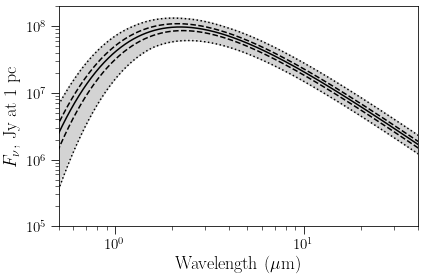

In [6]:
import analyze_timedep_functions as atf
from matplotlib import rc
import os

# Figure settings
rc('font',**{'family':'serif','serif':['serif']})
rc('text', usetex=True)
rc('xtick.major',size=8)
rc('xtick.minor',size=4)
rc('ytick.major',size=8)
rc('ytick.minor',size=4)

# Path settings
# With dust
#path = '../r3dresults/st28gm06n052_timedep_nospikes/'
#modelabbreviation = '052'
#path = '../r3dresults/st28gm06n074_nospikes/'
#modelabbreviation = '074'
#path = '../r3dresults/st28gm06n075_nospikes/'
#modelabbreviation = '075'

# Without dust
path = '../r3dresults/st28gm06n052_timedep_nodust/'
modelabbreviation = '052_nodust'
#path = '../r3dresults/st28gm06n074_nodust/'
#modelabbreviation = '074_nodust'
#path = '../r3dresults/st28gm06n075_nodust/'
#modelabbreviation = '075_nodust'

# Extract list of folders from the path folder, and make them to numbers, and sort them!
phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
phases.sort()

fig,ax = atf.plot_allseds(
    path=path,
    phases=phases,
)
# Save figure
#fig.tight_layout()
#fig.savefig(
#    f'/home/joachim/exwings/r3dplots/{modelabbreviation}_allSEDs_averagestdminmax.pdf',
#    facecolor='white',
#    dpi=300
#)



In [1]:
# Extract and save average, std, and minmax-SEDs
import analyze_timedep_functions as atf
import os

# Path settings
# With or without dust?
withdust = 'n'

if withdust == 'y':
    paths = [
        '../r3dresults/st28gm06n052_timedep_nospikes/',
        '../r3dresults/st28gm06n074_nospikes/',
        '../r3dresults/st28gm06n075_nospikes/'
    ]
else:
    paths = [
        '../r3dresults/st28gm06n052_timedep_nodust/',
        '../r3dresults/st28gm06n074_nodust/',
        '../r3dresults/st28gm06n075_nodust/'
    ]

for path in paths:
    # Extract list of folders from the path folder, and make them to numbers, and sort them!
    phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
    phases.sort()

    print(f'  Doing {path}')

    # Extract and save dat file with average etc
    atf.extract_averageseds(
        path=path,
        phases=phases,
        save_datafile='y',
    )




  Doing ../r3dresults/st28gm06n052_timedep_nodust/
  Doing ../r3dresults/st28gm06n074_nodust/
  Doing ../r3dresults/st28gm06n075_nodust/


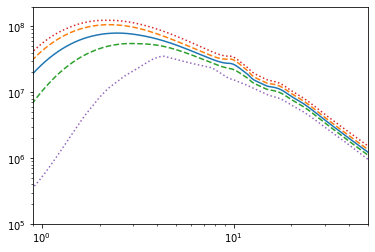

In [18]:
# Testplot data from average SED file
import matplotlib.pyplot as plt
import numpy as np

seds = np.loadtxt('../r3dresults/st28gm06n074_nospikes/average_sed.dat')

plt.xscale('log')
plt.yscale('log')

plt.xlim([0.9,50])
plt.ylim([1e5,2e8])

plt.plot(seds[:,0],seds[:,1])

plt.plot(seds[:,0],seds[:,1]+seds[:,2],'--')
plt.plot(seds[:,0],seds[:,1]-seds[:,2],'--')

plt.plot(seds[:,0],seds[:,3],':')
plt.plot(seds[:,0],seds[:,4],':')



## Plot temperature comparisons

In [9]:
#
#    med en Bladh-kurva med i plotten
#    dvs ta en dusttemperature original 
#        plott över en modified
#        (medel-T av kombon av alla grain sizes, samma jag kört innan)
#        och en bladh2012-kurva
#

# average, std, minmax av stofttemperaturen
# snapshot 190
# med och utan stoft-T-modifiering, dvs datan från originalartikeln

# samt en linje med Bladh's temperaturkurva ovanpå

import analyze_r3d_functions as a3d
import numpy as np
import os

# The lowest altitude for dust formation at the included time snapshot corresponds 
# to 3.4\,au, or 2.1\,$R_\star$, from the grid centre.

# Constants
AUcm = 1.49598e13 # cm

# Chose phase-designation
phase = 190
Nspecies = 10

# Set up radial binning props
# Load coordintaes of R3D-cells and change to AU
print('  Loading grid and setting radial bins')
cellcoords = a3d.load_griddistances(
    gridpath=f'../../exwings_archivedata/r3dresults_paper1_temp/grid_distances.csv',
    amrpath=f'../../exwings_archivedata/r3dresults_paper1_temp/amr_grid.inp',
)
radii = cellcoords[:,0]/AUcm
Nbins = 100
radial_bins = np.linspace(0,radii.max(),Nbins+1)
radial_range = np.linspace(radial_bins[1],radial_bins[-1],Nbins)


# Set up all empty arrays
temporig_all_avr = np.zeros((Nbins,Nspecies))
temporig_all_max = np.zeros((Nbins,Nspecies))
temporig_all_min = np.zeros((Nbins,Nspecies))
temporig_all_std = np.zeros((Nbins,Nspecies))

tempmod_all_avr = np.zeros((Nbins,Nspecies))
tempmod_all_max = np.zeros((Nbins,Nspecies))
tempmod_all_min = np.zeros((Nbins,Nspecies))
tempmod_all_std = np.zeros((Nbins,Nspecies))

# Loop through dust species
print('  Loading temperatures')

for nspecie in range(Nspecies):

    print(f'    Dust species: {nspecie+1}')

    # Load unmodified Ts and combine into one radial bin for all dust species
    # Load each specie's R3D-temperature
    Ncells, Ntemp, temper_orig = a3d.load_temperature(
        path=f'../../exwings_archivedata/r3dresults_paper1_temp/dust_temperature_{phase}.dat',
        numb_specie=nspecie+1
    )
    # Load modified temperatures as well and save in arrays
    Ncells, Ntemp, temper_mod = a3d.load_temperature(
        path=f'../../exwings_archivedata/r3dresults_timedep_paper2/temp/dust_temperature_{phase}.dat',
        numb_specie=nspecie+1
    )
    # Bin the temperatures and save in a Nbins*Nspecies arrays
    # Only for cells with nonzero T
    for nbin in range(Nbins):
        ncells = np.where(
            (radii >= radial_bins[nbin]) & \
            (radii < radial_bins[nbin+1])
        )[0]
        # Create temporary empty lists
        temperature_temporig = []
        temperature_tempmod = []

        # Loop through all non-zero cells
        # save temporary lists of temperature
        for ncell in ncells:

            if temper_orig[ncell] > 0:
                temperature_temporig.append(temper_orig[ncell])

            if temper_mod[ncell] > 0:
                temperature_tempmod.append(temper_mod[ncell])

        # Extract all mean,max,min,std
        if len(temperature_temporig) > 0:
            temporig_all_avr[nbin,nspecie] = np.mean(temperature_temporig)
            temporig_all_max[nbin,nspecie] = np.max(temperature_temporig)
            temporig_all_min[nbin,nspecie] = np.min(temperature_temporig)
            temporig_all_std[nbin,nspecie] = np.std(temperature_temporig)
        if len(temperature_tempmod) > 0:
            tempmod_all_avr[nbin,nspecie] = np.mean(temperature_tempmod)
            tempmod_all_max[nbin,nspecie] = np.max(temperature_tempmod)
            tempmod_all_min[nbin,nspecie] = np.min(temperature_tempmod)
            tempmod_all_std[nbin,nspecie] = np.std(temperature_tempmod)




print('  Writing temperature-radial-bin-files')
# Take average of each bin and save to files
# First original
with open(f'../../exwings_archivedata/r3dresults_paper1_temp/temperature_original_radialbins_{phase}.dat', 'w') as forig:
    # Write header
    forig.writelines(f'# Binned temperatures of st*052-model_{phase}\n')
    forig.writelines(f'# Radius (au) # T_average # T_max # T_min # T_std\n')

    # Save radial averagesetc over all species (grain sizes), remove zeros from min
    for nbin in range(Nbins):
        temporig_avr = temporig_all_avr[nbin,:].mean()
        temporig_max = temporig_all_max[nbin,:].max()
        temporig_min = temporig_all_min[nbin,:].min()
        temporig_std = temporig_all_std[nbin,:].max()

        if temporig_min == 0:
            temporig_min = temporig_avr - temporig_std

        forig.writelines(f'{radial_range[nbin]:.4f}    {temporig_avr:.1f}    {temporig_max:.1f}    {temporig_min:.1f}    {temporig_std:.1f}\n')

# Then modified
with open(f'../../exwings_archivedata/r3dresults_timedep_paper2/temp/temperature_modified_radialbins_{phase}.dat', 'w') as fmod:
    # Write header
    fmod.writelines(f'# Binned temperatures of (modified) st*052-model_{phase}\n')
    fmod.writelines(f'# Radius (au) # T_average # T_max # T_min # T_std\n')

    # Save radial averagesetc over all species (grain sizes), remove zeros from min
    for nbin in range(Nbins):
        tempmod_avr = tempmod_all_avr[nbin,:].mean()
        tempmod_max = tempmod_all_max[nbin,:].max()
        tempmod_min = tempmod_all_min[nbin,:].min()
        tempmod_std = tempmod_all_std[nbin,:].max()

        if tempmod_min == 0:
            tempmod_min = tempmod_avr - tempmod_std

        fmod.writelines(f'{radial_range[nbin]:.4f}    {tempmod_avr:.1f}    {tempmod_max:.1f}    {tempmod_min:.1f}    {tempmod_std:.1f}\n')

os.system('spd-say moo')



  Loading grid and setting radial bins
  Loading temperatures
    Dust species: 1
    Dust species: 2
    Dust species: 3
    Dust species: 4
    Dust species: 5
    Dust species: 6
    Dust species: 7
    Dust species: 8
    Dust species: 9
    Dust species: 10
  Writing temperature-radial-bin-files


0

3 au.   Toriginal: 179.9   Tmodified: 179.9   Torig/Tmod: 1.0
6 au.   Toriginal: 880.0   Tmodified: 816.2   Torig/Tmod: 1.0781671159029649
9 au.   Toriginal: 664.7   Tmodified: 618.3   Torig/Tmod: 1.0750444767912017
15 au.   Toriginal: 513.2   Tmodified: 452.0   Torig/Tmod: 1.1353982300884957


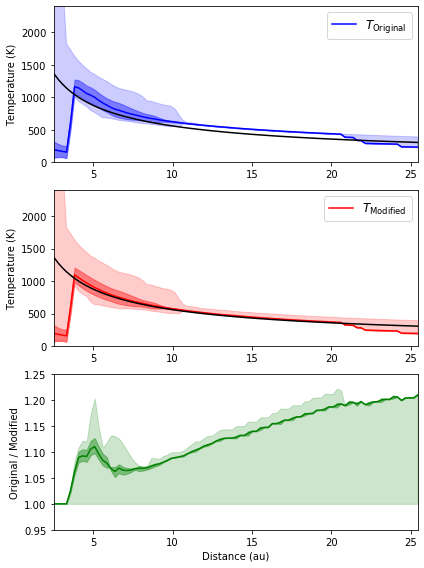

In [2]:
# load and plot results of radial binning of temperatures
import matplotlib.pyplot as plt
import numpy as np

# Chose snapshot number
phase = 190

# Declare all necessary lists
radial_range = []
Torig_avr = []
Torig_max = []
Torig_min = []
Torig_std = []

Tmod_avr = []
Tmod_max = []
Tmod_min = []
Tmod_std = []

# Load original temperatures
with open(f'../../exwings_archivedata/r3dresults_paper1_temp/temperature_original_radialbins_{phase}.dat', 'r') as forig:
    for line in forig.readlines():
        if line[0] != '#':
            linelist = line.split('    ')

            radial_range.append(float(linelist[0]))

            Torig_avr.append(float(linelist[1]))
            Torig_max.append(float(linelist[2]))
            Torig_min.append(float(linelist[3]))
            Torig_std.append(float(linelist[4]))

# Load modified temperatures
with open(f'../../exwings_archivedata/r3dresults_paper2/temp/temperature_modified_radialbins_{phase}.dat', 'r') as fmod:
    for line in fmod.readlines():
        if line[0] != '#':
            linelist = line.split('    ')

            Tmod_avr.append(float(linelist[1]))
            Tmod_max.append(float(linelist[2]))
            Tmod_min.append(float(linelist[3]))
            Tmod_std.append(float(linelist[4]))

# Change all to arrays
Torig_avr = np.array(Torig_avr)
Torig_max = np.array(Torig_max)
Torig_min = np.array(Torig_min)
Torig_std = np.array(Torig_std)
Tmod_avr = np.array(Tmod_avr)
Tmod_max = np.array(Tmod_max)
Tmod_min = np.array(Tmod_min)
Tmod_std = np.array(Tmod_std)


# Compute Bladh-temperature
# Assume Teff = 2800 K, Rstar = 1.65 au, forsterite-powerlaw = -0.9
temperature_bladh = 2800 * (1.65/(2*np.array(radial_range)))**(2/(4-0.9))

# Compute ratio between original and modified
Tratio_avr = Torig_avr / Tmod_avr
Tratio_max = Torig_max / Tmod_max
Tratio_min = Torig_min / Tmod_min
Tratio_stdup = (Torig_avr + Torig_std) / (Tmod_avr + Tmod_std)
Tratio_stddown = (Torig_avr - Torig_std) / (Tmod_avr - Tmod_std)

# Set up subplots for figure with only temperature (ratio later in another fig)
fig,ax = plt.subplots(
    3,1,
    figsize=(6,8)
)
legendlist = [
    r'$T_{\rm Original}$',
    r'$T_{\rm Modified}$',
    r'$T_{\rm Bladh}$'
]
# Plot original temperature
ax[0].plot(radial_range,Torig_avr,'b', label=legendlist[0])
ax[0].fill_between(
    radial_range,
    Torig_min,
    Torig_max,
    color='b',
    alpha=0.2
)
ax[0].fill_between(
    radial_range,
    Torig_avr-Torig_std,
    Torig_avr+Torig_std,
    color='b',
    alpha=0.4
)
# Plot modified temperature
ax[1].plot(radial_range,Tmod_avr,'r', label=legendlist[1])
ax[1].fill_between(
    radial_range,
    Tmod_min,
    Tmod_max,
    color='r',
    alpha=0.2
)
ax[1].fill_between(
    radial_range,
    Tmod_avr-Tmod_std,
    Tmod_avr+Tmod_std,
    color='r',
    alpha=0.4
)
# Plot ratio
ax[2].plot(radial_range,Tratio_avr,'g')
ax[2].fill_between(
    radial_range,
    Tratio_min,
    Tratio_max,
    color='g',
    alpha=0.2
)
ax[2].fill_between(
    radial_range,
    Tratio_stdup,
    Tratio_stddown,
    color='g',
    alpha=0.4
)
for nplot in range(3):

    # Set general settings
    ax[nplot].set_xlim([2.5,radial_range[-1]])

    if nplot < 2:
        ax[nplot].legend(fontsize=12)
        ax[nplot].set_ylim([0,2400])
        ax[nplot].set_ylabel('Temperature (K)')

        # And Bladh-curve on top of both plots
        ax[nplot].plot(radial_range,temperature_bladh,'k', label=legendlist[2])

ax[-1].set_ylabel('Original / Modified')
ax[-1].set_xlabel('Distance (au)')
ax[-1].set_ylim([0.95,1.25])

# Extract and print some temperatures for comparisons
ref_distances = [3,6,9,15]

for ref_dist in ref_distances:
    nn_dist = np.where(np.array(radial_range) > ref_dist)[0][0] - 1
    print(f'{ref_dist} au.   Toriginal: {Torig_avr[nn_dist]}   Tmodified: {Tmod_avr[nn_dist]}   Torig/Tmod: {Torig_avr[nn_dist]/Tmod_avr[nn_dist]}')

fig.tight_layout()
fig.savefig(f'../r3dplots/052_temperature_compare_{phase}.pdf')



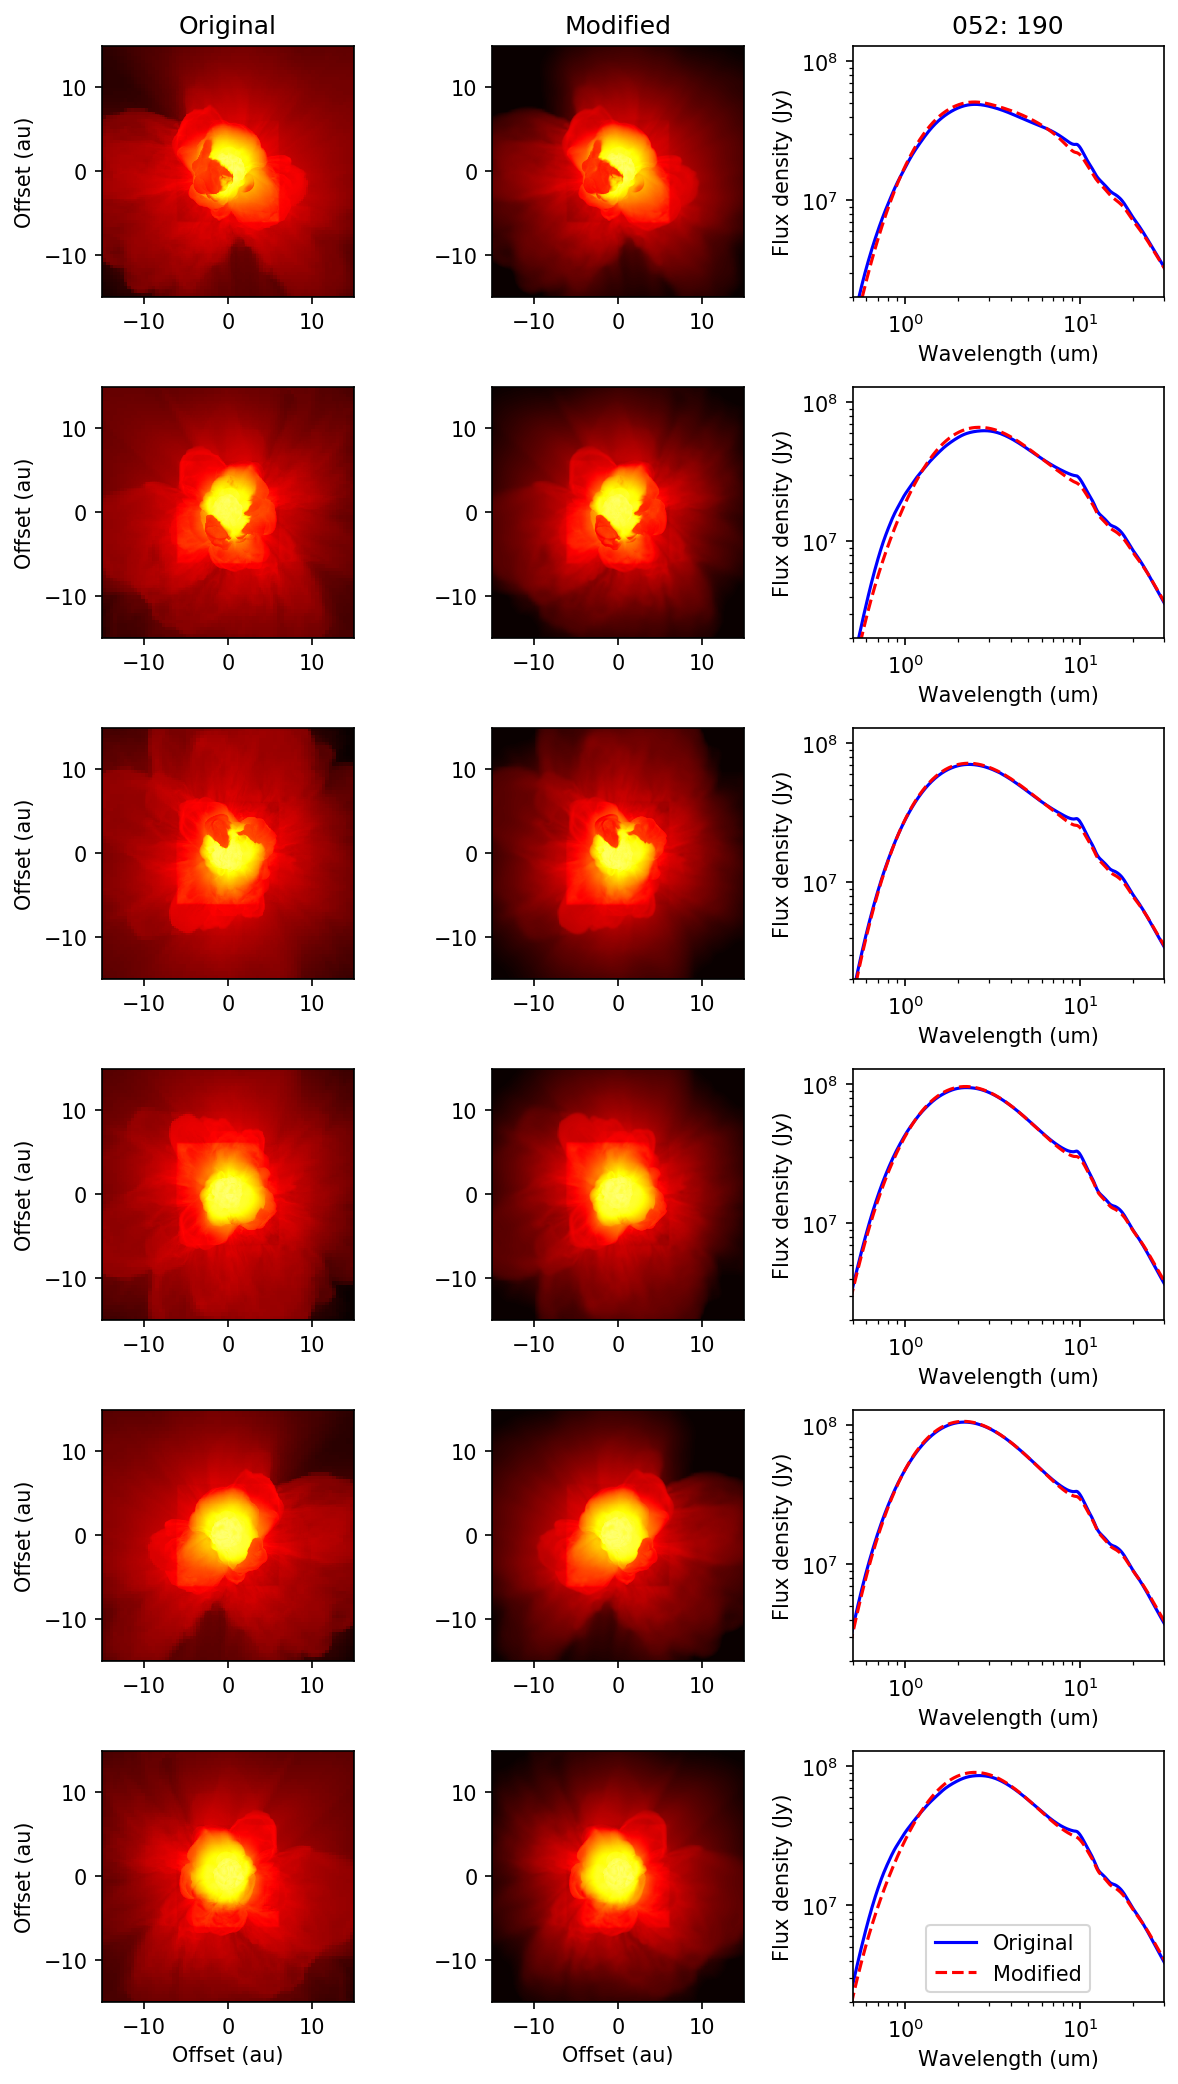

In [3]:
# Plot images and SEDs of same snapshots, with and without temperature-modification
import matplotlib.pyplot as plt
import analyze_r3d_functions as a3d

# Set paths and image settings
phase = 190
pathoriginal = f'../../exwings_archivedata/r3dresults_paper1_temp/{phase}/'
pathmodified = f'../r3dresults/st28gm06n052_timedep_nospikes/{phase}/'
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
wavelength = '02'

fig,ax = plt.subplots(
    6,3,
    figsize = (8,14),
    dpi=150
)
fluxlimitslog = [-4,9]

for nangle,angle in enumerate(angles):
    
    # Load original image
    image2d,image2dlog_orig,flux,axisplot = a3d.load_images(
        path=f'{pathoriginal}',
        image=f'image_{angle}_{wavelength}um.out',
        distance=1
    )
    # Plot original images to the left column
    ax[nangle,0].imshow(
        image2dlog_orig,
        origin='lower', extent=axisplot, 
        cmap=plt.get_cmap('hot'),
        vmin=fluxlimitslog[0],
        vmax=fluxlimitslog[1]
    )
    
    # Load modified image
    image2d,image2dlog_mod,flux,axisplot = a3d.load_images(
        path=f'{pathmodified}',
        image=f'image_{angle}_{wavelength}um.out',
        distance=1
    )
    # Plot modified images to the left column
    ax[nangle,1].imshow(
        image2dlog_mod,
        origin='lower', extent=axisplot, 
        cmap=plt.get_cmap('hot'),
        vmin=fluxlimitslog[0],
        vmax=fluxlimitslog[1]
    )
    ax[nangle,0].set_ylabel('Offset (au)')

    # Load original SED
    sed_wavelength,sed_orig = a3d.load_spectrum(
            path = f'{pathoriginal}spectrum_{angle}.out'
    )
    # Load modified SED
    sed_wavelength,sed_mod = a3d.load_spectrum(
            path = f'{pathmodified}spectrum_{angle}.out'
    )
    # Plot both
    ax[nangle,2].plot(
        sed_wavelength,sed_orig,'b',label='Original'
    )
    ax[nangle,2].plot(
        sed_wavelength,sed_mod,'r--',label='Modified'
    )
    ax[nangle,2].set(
        xscale='log',
        yscale='log',
        xlim=(0.5,30),
        ylim=(2e6,1.3e8),
        xlabel='Wavelength (um)',
        ylabel='Flux density (Jy)'
    )




ax[-1,2].legend()
ax[0,0].set_title('Original')
ax[0,1].set_title('Modified')
ax[0,2].set_title(f'052: {phase}')
ax[-1,0].set_xlabel('Offset (au)')
ax[-1,1].set_xlabel('Offset (au)')

fig.tight_layout()
fig.savefig(f'../r3dplots/052_temperature_compare_imagesseds_{phase}.pdf')


## Plot various time-dep-plots

### Flambda(time)-plots

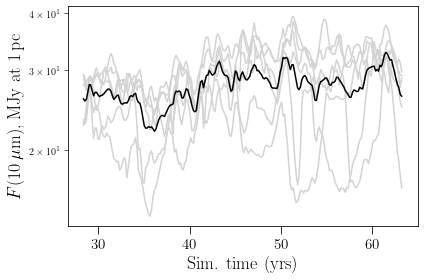

In [4]:
# Plot time-dependent plots
# 1. Plot Flambda(time)
import os
import numpy as np
import matplotlib.pyplot as plt
import analyze_r3d_functions as a3d
from matplotlib import rc

# Figure settings
rc('font',**{'family':'serif','serif':['serif']})
rc('text', usetex=True)
rc('xtick.major',size=8)
rc('xtick.minor',size=4)
rc('ytick.major',size=8)
rc('ytick.minor',size=4)

# Path to model of choice
path = '../r3dresults/st28gm06n052_timedep_nospikes/'
model = '052'
#path = '../r3dresults/st28gm06n074_nospikes/'
#model = '074'


# Wavelength to plot
wavelength = 10

# Load all phases
phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
phases.sort()
Nphases = len(phases)
phasetimes = np.loadtxt(path+'snapshot_yr.dat')[:Nphases,1]

# And angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
# Load wavelengthgrid and extract index for wavelength
wavelengths,spectrum = a3d.load_spectrum(
    path = f'{path}{phases[0]}/spectrum_{angles[0]}.out'
)
wavelengths = np.array(wavelengths)
wavelengthindex = int(np.where(wavelengths >= wavelength)[0][0]-1)
fluxall = np.zeros((len(angles),Nphases))

# Set figure settings
fig, ax = plt.figure(num=f'F(t) of {wavelength} um', figsize=(6, 4)), plt.axes()
ax.set_xlabel(r'Sim. time (yrs)',fontsize=18);
ax.set_ylabel(rf'$F({wavelength}\,\mu$m$)$, MJy at 1\,pc',fontsize=18);
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_yscale('log')


# Loop through all phases and extract all flux densities at wavelength
for nangles,angle in enumerate(angles):
    for nphase,phase in enumerate(phases):

        wavelengths,spectrum = a3d.load_spectrum(
            path = f'{path}{phase}/spectrum_{angle}.out'
        )
        fluxall[nangles,nphase] = spectrum[wavelengthindex]*1e-6
    
    # Plot each angles time dependent F10 in MJy
    plt.plot(phasetimes,fluxall[nangles,:],'lightgrey')

# Save average of each angles flux density at each time
fluxaverage = []
for nphase in range(Nphases):
    fluxaverage.append(np.mean(fluxall[:,nphase]))

# and plot average flux density
ax.plot(phasetimes,fluxaverage,'k')

# and save figure
fig.tight_layout()
#plt.savefig(f'../r3dplots/{model}_fluxtime_{wavelength}um.pdf', dpi=300)


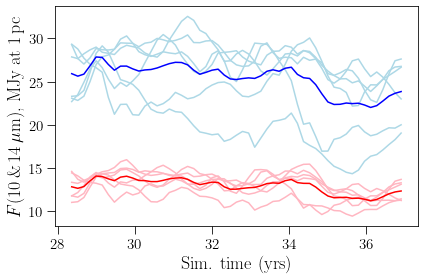

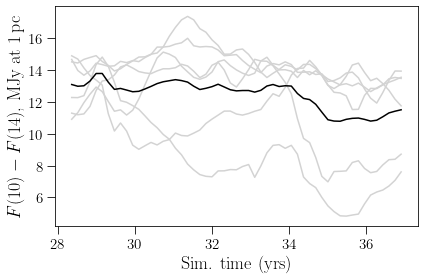

In [8]:
# Load F10 and F14 data of all SEDs and plot
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import os

# Figure settings
rc('font',**{'family':'serif','serif':['serif']})
rc('text', usetex=True)
rc('xtick.major',size=8)
rc('xtick.minor',size=4)
rc('ytick.major',size=8)
rc('ytick.minor',size=4)

# Path settings
path = '../r3dresults/st28gm06n052_timedep_nospikes/'
phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
phases.sort()
Nphases = len(phases)
phasetimes = np.loadtxt(path+'snapshot_yr.dat')[:Nphases,1]
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
Nangles = len(angles)

# Load wavelengthgrid and extract index for 10um
wavelengths,spectrum = a3d.load_spectrum(
    path = f'{path}{phases[0]}/spectrum_{angles[0]}.out'
)
wavelengths = np.array(wavelengths)
index10um = int(np.where(wavelengths >= 10)[0][0]-1)
index14um = int(np.where(wavelengths >= 14)[0][0]-1)

# Set up arrays to fill
f10all = np.zeros((Nangles,Nphases))
f14all = np.zeros((Nangles,Nphases))
f10average = np.zeros(Nphases)
f14average = np.zeros(Nphases)

# Initiate figures
fig1014, ax1014 = plt.figure(num='F10 and 14 stardust', figsize=(6, 4)), plt.axes()
fig10min14, ax10min14 = plt.figure(num='F10 - F14', figsize=(6, 4)), plt.axes()

# Loop over snapshots and angles
for nphase,phase in enumerate(phases):
    for nangle,angle in enumerate(angles):

        # Load all SEDs
        wavelength, spectrum = a3d.load_spectrum(
            path=f'{path}{phase}/spectrum_{angle}.out'
        )
        # Save flux densities of 10 and 14 um
        f10all[nangle,nphase] = spectrum[index10um]*1e-6
        f14all[nangle,nphase] = spectrum[index14um]*1e-6
    
    # Take LOS averaged fluxes
    f10average[nphase] = np.mean(f10all[:,nphase])
    f14average[nphase] = np.mean(f14all[:,nphase])

# Plot each angle
for nangle,angle in enumerate(angles):
    ax1014.plot(phasetimes,f10all[nangle,:],'lightblue')
    ax1014.plot(phasetimes,f14all[nangle,:],'lightpink')
    ax10min14.plot(
        phasetimes,
        f10all[nangle,:] - f14all[nangle,:],
        'lightgrey'
    )

# Plot averages
ax1014.plot(phasetimes,f10average,'blue')
ax1014.plot(phasetimes,f14average,'red')
ax10min14.plot(
    phasetimes,
    f10average - f14average,
    'black'
)




ax1014.set_xlabel(r'Sim. time (yrs)',fontsize=18);
ax1014.set_ylabel(r'$F(10\,\&\,14\,\mu$m$)$, MJy at 1\,pc',fontsize=18);
ax1014.tick_params(axis='both', which='major', labelsize=15)
fig1014.tight_layout()

ax10min14.set_xlabel(r'Sim. time (yrs)',fontsize=18);
ax10min14.set_ylabel(r'$F(10) - F(14)$, MJy at 1\,pc',fontsize=18);
ax10min14.tick_params(axis='both', which='major', labelsize=15)
fig10min14.tight_layout()

# TODO SPARA!
#fig.savefig(
#    'figs/timedep_F10.pdf',
#    dpi=300,
#    facecolor='white'
#)


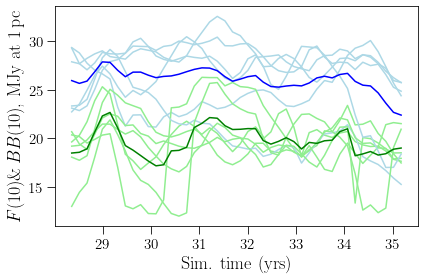

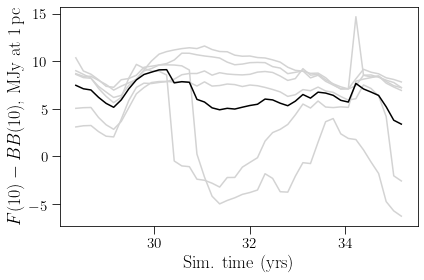

In [4]:
# Fit blackbodies to SEDs
# Extract 10um flux density of black bodies
# Take F10 - BBfit10 and plot
# Load F10 and F14 data of all SEDs and plot
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import os

# Figure settings
rc('font',**{'family':'serif','serif':['serif']})
rc('text', usetex=True)
rc('xtick.major',size=8)
rc('xtick.minor',size=4)
rc('ytick.major',size=8)
rc('ytick.minor',size=4)

# Path settings
path = '../r3dresults/st28gm06n052_timedep_nospikes/'
phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
phases.sort()
Nphases = len(phases)
phasetimes = np.loadtxt(path+'snapshot_yr.dat')[:Nphases,1]
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
Nangles = len(angles)

# Load wavelengthgrid and extract index for 10um
wavelengths,spectrum = a3d.load_spectrum(
    path = f'{path}{phases[0]}/spectrum_{angles[0]}.out'
)
wavelengths = np.array(wavelengths)
index10um = int(np.where(wavelengths >= 10)[0][0]-1)


# Set up arrays to fill
f10all = np.zeros((Nangles,Nphases))
f10average = np.zeros(Nphases)
BB10all = np.zeros((Nangles,Nphases))
BB10average = np.zeros(Nphases)




# Loop over snapshots and angles
for nphase,phase in enumerate(phases):
    for nangle,angle in enumerate(angles):

        # Load all SEDs
        wavelength, spectrum = a3d.load_spectrum(
            path=f'{path}{phase}/spectrum_{angle}.out'
        )
        # Fit BB to SED
        N_maxflux = np.argmax(spectrum)
        BBfit = a3d.compute_blackbody_freq(
            peak_flux = np.max(spectrum),
            peak_wavelength = wavelength[N_maxflux],
            wavelengths = wavelength
        )
        # Save flux densities of 10 um
        f10all[nangle,nphase] = spectrum[index10um]*1e-6
        BB10all[nangle,nphase] = BBfit[index10um]*1e-6

    # Take LOS averaged fluxes
    f10average[nphase] = np.mean(f10all[:,nphase])
    BB10average[nphase] = np.mean(BB10all[:,nphase])


fig10, ax10 = plt.figure(num='F10stardust and BB10', figsize=(6, 4)), plt.axes()
figFminBB, axFminBB = plt.figure(num='F10stardust minus BB10', figsize=(6, 4)), plt.axes()


# Plot each angle
for nangle,angle in enumerate(angles):
    ax10.plot(phasetimes,f10all[nangle,:],'lightblue')
    ax10.plot(phasetimes,BB10all[nangle,:],'lightgreen')
    axFminBB.plot(
        phasetimes,
        f10all[nangle,:] - BB10all[nangle,:],
        'lightgrey'
    )

# Plot averages
ax10.plot(phasetimes,f10average,'blue')
ax10.plot(phasetimes,BB10average,'green')
axFminBB.plot(
    phasetimes,
    f10average - BB10average,
    'black'
)

ax10.set_xlabel(r'Sim. time (yrs)',fontsize=18);
ax10.set_ylabel(r'$F(10)\&\,BB(10)$, MJy at 1\,pc',fontsize=18);
ax10.tick_params(axis='both', which='major', labelsize=15)
fig10.tight_layout()


axFminBB.set_xlabel(r'Sim. time (yrs)',fontsize=18);
axFminBB.set_ylabel(r'$F(10) - BB(10)$, MJy at 1\,pc',fontsize=18);
axFminBB.tick_params(axis='both', which='major', labelsize=15)
figFminBB.tight_layout()







#### Plot major events

Total included time: 12.516780467011031
Angles      : Event time ratio     Periodicity


/home/joachim/exwings/exwings-codes/analyze_r3d_functions.py:2796: RuntimeWarning: divide by zero encountered in divide
  period_axis = 1/freqs * delta_timestep


i000_phi000 : 0.0125  [0.52153252 1.25167805 0.41722602 0.78229878]
i090_phi000 : 0.075  [ 3.12919512  4.17226016 12.51678047  1.7881115 ]
i090_phi090 : 0.0625  [1.39075339 1.13788913 2.08613008 6.25839023]
i090_phi270 : 0.05  [1.7881115  6.25839023 1.39075339 2.50335609]
i180_phi000 : 0.0625  [12.51678047  0.78229878  0.7362812   1.7881115 ]
i270_phi000 : 0.0125  [-0.31291951  0.83445203  0.78229878  0.52153252]


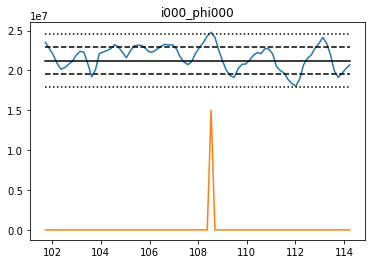

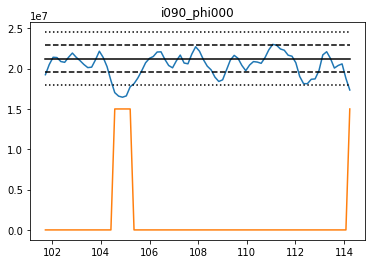

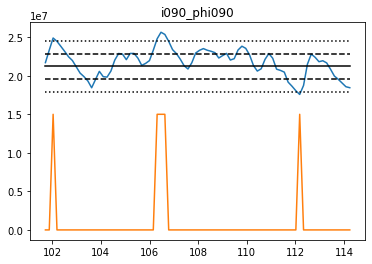

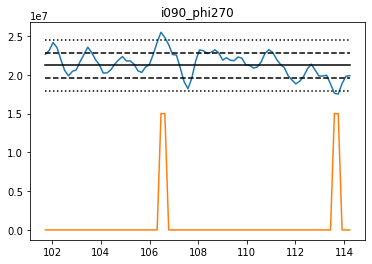

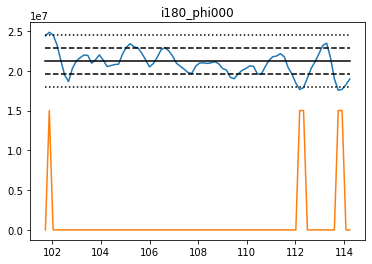

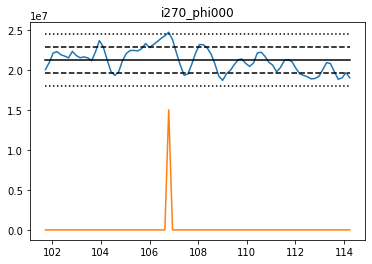

In [1]:
# Compute and plot Flux density-difference to mean SED
# Of dust EMISSION and/or ABSORPTION at 10um
import numpy as np
import matplotlib.pyplot as plt
import analyze_r3d_functions as a3d
import os

wavelength = 10
Nsigma = 2

# Set path settings
#path = '../r3dresults/st28gm06n052_timedep_nospikes/'
#modelabbreviation = '052'
#path = '../r3dresults/st28gm06n074_nospikes/'
#modelabbreviation = '074'
path = '../r3dresults/st28gm06n075_nospikes/'
modelabbreviation = '075'


# Extract list of folders from the path folder, and make them to numbers, and sort them!
phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
phases.sort()
# And load corresponding time
snapshot_times = np.loadtxt(path+'snapshot_yr.dat')[:,1]

# Set LOS-angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
# Load average SED-data
average_seds = np.loadtxt(f'{path}average_sed.dat')
wavelengths = average_seds[:,0]

# Extract index of chosen wavelength
n10micron = np.argwhere(wavelengths >= wavelength)[0][0] - 1

# Loop through phases and extract flux density of wavelength
F10um = np.zeros(len(phases))
dustevents = np.zeros((len(angles),len(phases)))

# Print output header
print(f'Total included time: {snapshot_times[-1]-snapshot_times[0]}')
print('Angles      : Event time ratio     Periodicity')

for nangle,angle in enumerate(angles):
    # Reset single-angle event list
    F10dustevent = []

    for nphase,phase in enumerate(phases):
        wavetemp, spectrum = a3d.load_spectrum(
            path=f'{path}{phase}/spectrum_{angle}.out'
        )
        F10um[nphase] = spectrum[n10micron]

        # Extract when Fdiff > 1sigma for all snapshots
        Fdiff10 = np.abs(spectrum[n10micron] - average_seds[n10micron,1])

        if Fdiff10 > Nsigma*average_seds[n10micron,2]:
            F10dustevent.append(1)
        else:
            F10dustevent.append(0)
    # Save dustevents for each LOS
    dustevents[nangle,:] = np.array(F10dustevent)

    # Extract ratio of included time being during dust event
    event_ratio = len(np.where(dustevents[nangle] == 1)[0]) / len(phases)

    # Testplots
    plt.figure(num=nangle)
    plt.plot(snapshot_times,F10um)
     # Plot average
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [average_seds[n10micron,1],average_seds[n10micron,1]],
        'k'
    )
    # Plot 1std
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [average_seds[n10micron,1]+average_seds[n10micron,2],average_seds[n10micron,1]+average_seds[n10micron,2]],
        'k--'
    )
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [average_seds[n10micron,1]-average_seds[n10micron,2],average_seds[n10micron,1]-average_seds[n10micron,2]],
        'k--'
    )
    # Plot 2std
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [average_seds[n10micron,1]+2*average_seds[n10micron,2],average_seds[n10micron,1]+2*average_seds[n10micron,2]],
        'k:'
    )
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [average_seds[n10micron,1]-2*average_seds[n10micron,2],average_seds[n10micron,1]-2*average_seds[n10micron,2]],
        'k:'
    )
    plt.plot(snapshot_times,dustevents[nangle]*1.5e7)
    plt.title(angle)

    # Check if there are events:
    if np.sum(dustevents[nangle]) != 0:
        # Extract periodicity of dustevents
        periods = a3d.compute_period(
            signal=dustevents[nangle],
            timeaxis=snapshot_times
        )
        # Print output
        print(f'{angle} : {event_ratio}  {periods}')
    else:
        # Print output
        print(f'{angle} : N/A')


Total included time: 12.516780467011031
Angles      : Event time ratio     Periodicity
i000_phi000 : 0.025  [12.51678047  6.25839023  4.17226016  2.08613008]


/home/joachim/exwings/exwings-codes/analyze_r3d_functions.py:2796: RuntimeWarning: divide by zero encountered in divide
  period_axis = 1/freqs * delta_timestep


i090_phi000 : 0.0625  [12.51678047  6.25839023  4.17226016  2.50335609]
i090_phi090 : 0.0375  [12.51678047  6.25839023  4.17226016  2.50335609]
i090_phi270 : 0.0125  [0.7362812  0.37929638 0.54420785 0.46358446]
i180_phi000 : 0.0125  [0.54420785 0.69537669 0.65877792 1.56459756]
i270_phi000 : N/A


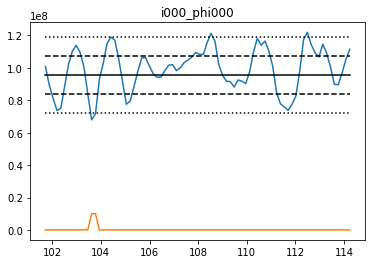

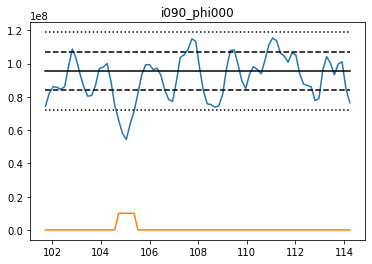

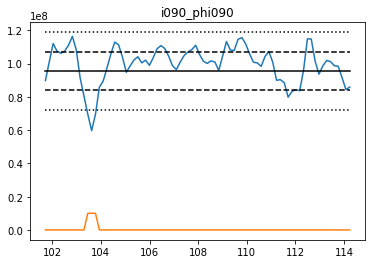

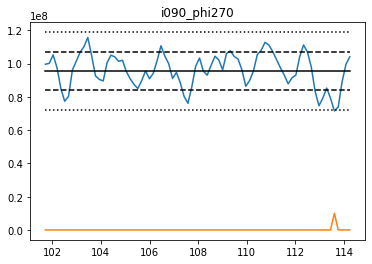

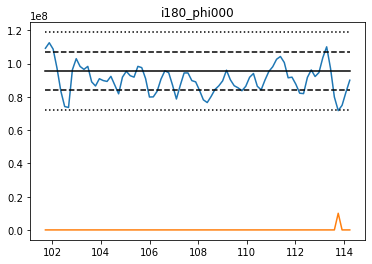

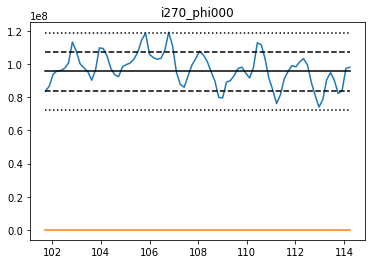

In [2]:
# Compute and plot Flux density-difference to mean SED
# Of dust obscuration of star at 2um
import numpy as np
import matplotlib.pyplot as plt
import analyze_r3d_functions as a3d
import os

wavelength = 2
Nsigma = 2

# Set path settings
#path = '../r3dresults/st28gm06n052_timedep_nospikes/'
#modelabbreviation = '052'
#path = '../r3dresults/st28gm06n074_nospikes/'
#modelabbreviation = '074'
path = '../r3dresults/st28gm06n075_nospikes/'
modelabbreviation = '075'


# Extract list of folders from the path folder, and make them to numbers, and sort them!
phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
phases.sort()
# And load corresponding time
snapshot_times = np.loadtxt(path+'snapshot_yr.dat')[:,1]

# Set LOS-angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
# Load average SED-data
average_seds = np.loadtxt(f'{path}average_sed.dat')
wavelengths = average_seds[:,0]

# Extract index of chosen wavelength
n2micron = np.argwhere(wavelengths >= wavelength)[0][0] - 1

# Loop through phases and extract flux density of wavelength
F2um = np.zeros(len(phases))
dustevents = np.zeros((len(angles),len(phases)))

# Print output header
print(f'Total included time: {snapshot_times[-1]-snapshot_times[0]}')
print('Angles      : Event time ratio     Periodicity')

for nangle,angle in enumerate(angles):
    # Reset single-angle event list
    F2dustevent = []

    for nphase,phase in enumerate(phases):
        wavetemp, spectrum = a3d.load_spectrum(
            path=f'{path}{phase}/spectrum_{angle}.out'
        )
        F2um[nphase] = spectrum[n2micron]

        # Extract when F2 goes below Faverage-Nsigma for all snapshots
        if spectrum[n2micron] < average_seds[n2micron,1] - Nsigma*average_seds[n2micron,2]:
            F2dustevent.append(1)
        else:
            F2dustevent.append(0)

    # Save dustevents for each LOS
    dustevents[nangle,:] = np.array(F2dustevent)

    # Extract ratio of included time being during dust event
    event_ratio = len(np.where(dustevents[nangle] == 1)[0]) / len(phases)

    # plots
    plt.figure(num=nangle)
    plt.plot(snapshot_times,F2um)
    # Plot average
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [average_seds[n2micron,1],average_seds[n2micron,1]],
        'k'
    )
    # Plot 1std
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [average_seds[n2micron,1]+average_seds[n2micron,2],average_seds[n2micron,1]+average_seds[n2micron,2]],
        'k--'
    )
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [average_seds[n2micron,1]-average_seds[n2micron,2],average_seds[n2micron,1]-average_seds[n2micron,2]],
        'k--'
    )
    # Plot 2std
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [average_seds[n2micron,1]+2*average_seds[n2micron,2],average_seds[n2micron,1]+2*average_seds[n2micron,2]],
        'k:'
    )
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [average_seds[n2micron,1]-2*average_seds[n2micron,2],average_seds[n2micron,1]-2*average_seds[n2micron,2]],
        'k:'
    )
    plt.plot(snapshot_times,dustevents[nangle]*1e7)
    plt.title(angle)

    # Check if there are events:
    if np.sum(dustevents[nangle]) != 0:
        # Extract periodicity of dustevents
        periods = a3d.compute_period(
            signal=dustevents[nangle],
            timeaxis=snapshot_times
        )
        # Print output
        print(f'{angle} : {event_ratio}  {periods}')
    else:
        # Print output
        print(f'{angle} : N/A')

#### Extract flux based event-statistics

i000_phi000


/home/joachim/exwings/exwings-codes/analyze_timedep_functions.py:452: RuntimeWarning: divide by zero encountered in divide
  period_axis = 1/freqs * delta_timestep
/home/joachim/exwings/exwings-codes/analyze_timedep_functions.py:540: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


  FFT: [34.85688584  1.45237024 17.42844292 11.61896195]
  Total included time: 34.85688583615784 time units
  Number of events: 14
  Average pediod between events: 2.4897775597255603 time units
  Total length of events: 7.446549872424413 time units
  Average length of events: 0.5318964194588867 time units
  Portion of events: 0.21363210435454152

i090_phi000
  FFT: [ 3.87298732 17.42844292  1.83457294  2.32379239]
  Total included time: 34.85688583615784 time units
  Number of events: 7
  Average pediod between events: 4.9795551194511205 time units
  Total length of events: 3.485619089219938 time units
  Average length of events: 0.49794558417427687 time units
  Portion of events: 0.09999800629361519

i090_phi090
  FFT: [ 2.32379239  3.87298732  1.93649366 34.85688584]
  Total included time: 34.85688583615784 time units
  Number of events: 4
  Average pediod between events: 8.71422145903946 time units
  Total length of events: 1.901246775938148 time units
  Average length of events: 0

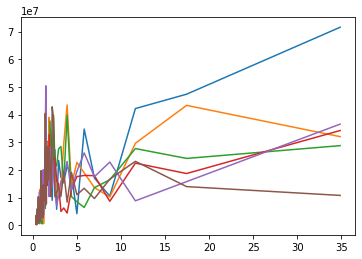

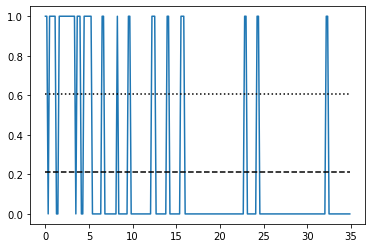

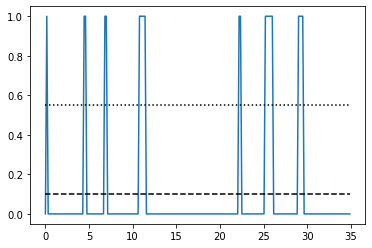

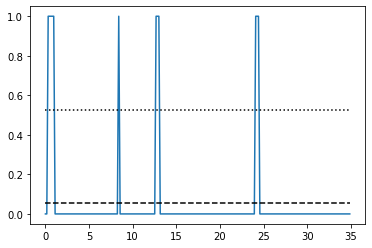

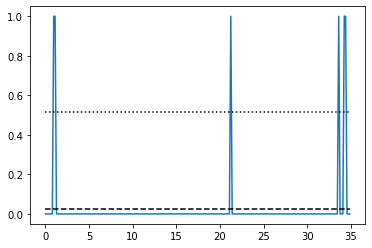

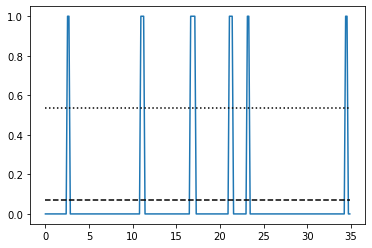

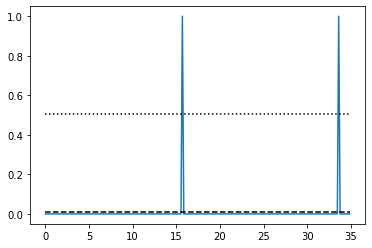

In [1]:
# For 2um
import numpy as np
import matplotlib.pyplot as plt
import analyze_r3d_functions as a3d
import analyze_timedep_functions as atf
import os

wavelength = 2
fluxlimit = 0.8
#fluxlimit = 0.6


# Set path settings
#path = '../r3dresults/st28gm06n052_timedep_nospikes/'
#modelabbreviation = '052'
#path = '../r3dresults/st28gm06n074_nospikes/'
#modelabbreviation = '074'
path = '../r3dresults/st28gm06n075_nospikes/'
modelabbreviation = '075'


# Extract list of folders from the path folder, and make them to numbers, and sort them!
phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
phases.sort()
Nphases = len(phases)
# And load corresponding time
snapshot_times = np.loadtxt(path+'snapshot_yr.dat')[:,1]


# Set LOS-angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
Nangles = len(angles)
# Load average SED-data
average_seds = np.loadtxt(f'{path}average_sed.dat')
wavelengths = average_seds[:,0]


# Extract index of chosen wavelength and average flux density at wavelength
waveindex = np.argwhere(wavelengths >= wavelength)[0][0] - 1
average_flux = average_seds[waveindex,1]

# Loop through phases and extract events for each angle and phase
for nangle,angle in enumerate(angles):
    dustevents = np.zeros(Nphases)
    fluxdensity = np.zeros(Nphases)
    for nphase,phase in enumerate(phases):
        wavetemp, spectrum = a3d.load_spectrum(
            path=f'{path}{phase}/spectrum_{angle}.out'
        )
        fluxdensity[nphase] = spectrum[waveindex]

        if fluxdensity[nphase] <= fluxlimit * average_flux:
            dustevents[nphase] = 1
    # print angle
    print(angle)
    # Extract FFT
    period = atf.compute_period(
        signal=fluxdensity,
        timeaxis=snapshot_times,
        plot_spec='y'
    )
    print(f'  FFT: {period}')
    # Extract statistics
    if np.sum(dustevents) != 0:

        atf.extract_events(
            eventdata=dustevents,
            timerange=snapshot_times,
            relative_limit=0.5
        )
    else:
        print('  N/A\n')



i000_phi000


/home/joachim/exwings/exwings-codes/analyze_timedep_functions.py:452: RuntimeWarning: divide by zero encountered in divide
  period_axis = 1/freqs * delta_timestep


  FFT: [34.85688584 17.42844292  3.87298732  1.83457294]
  N/A

i090_phi000
  FFT: [34.85688584  2.32379239  3.87298732  4.35711073]
  Total included time: 34.85688583615784 time units
  Number of events: 2
  Average pediod between events: 17.42844291807892 time units
  Total length of events: 0.475311693984537 time units
  Average length of events: 0.2376558469922685 time units
  Portion of events: 0.01363609176731116



/home/joachim/exwings/exwings-codes/analyze_timedep_functions.py:540: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


i090_phi090
  FFT: [3.87298732 1.93649366 1.65985171 4.35711073]
  Total included time: 34.85688583615784 time units
  Number of events: 1
  Average pediod between events: 34.85688583615784 time units
  Total length of events: 0.475311693984537 time units
  Average length of events: 0.475311693984537 time units
  Portion of events: 0.01363609176731116

i090_phi270
  FFT: [34.85688584  5.80948097  1.93649366  8.71422146]
  N/A

i180_phi000
  FFT: [ 5.80948097 34.85688584  6.97137717 17.42844292]
  Total included time: 34.85688583615784 time units
  Number of events: 1
  Average pediod between events: 34.85688583615784 time units
  Total length of events: 0.316874462656358 time units
  Average length of events: 0.316874462656358 time units
  Portion of events: 0.009090727844874108

i270_phi000
  FFT: [ 4.35711073  5.80948097  2.32379239 11.61896195]
  Total included time: 34.85688583615784 time units
  Number of events: 2
  Average pediod between events: 17.42844291807892 time units
  To

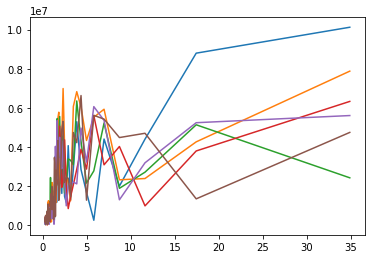

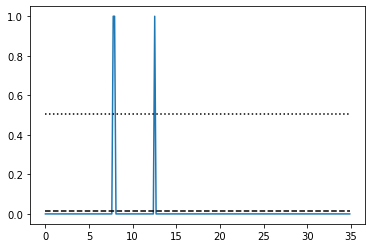

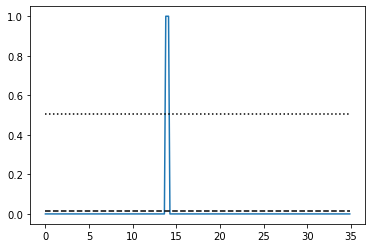

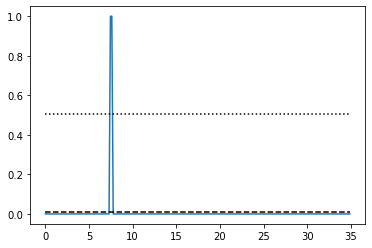

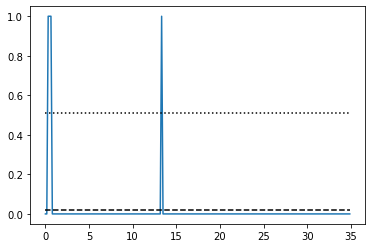

In [1]:
# For 10um
import numpy as np
import matplotlib.pyplot as plt
import analyze_r3d_functions as a3d
import analyze_timedep_functions as atf
import os

wavelength = 10
fluxlimit = 1.2

# Set path settings
#path = '../r3dresults/st28gm06n052_timedep_nospikes/'
#modelabbreviation = '052'
#path = '../r3dresults/st28gm06n074_nospikes/'
#modelabbreviation = '074'
path = '../r3dresults/st28gm06n075_nospikes/'
modelabbreviation = '075'


# Extract list of folders from the path folder, and make them to numbers, and sort them!
phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
phases.sort()
Nphases = len(phases)
# And load corresponding time
snapshot_times = np.loadtxt(path+'snapshot_yr.dat')[:,1]


# Set LOS-angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
Nangles = len(angles)
# Load average SED-data
average_seds = np.loadtxt(f'{path}average_sed.dat')
wavelengths = average_seds[:,0]


# Extract index of chosen wavelength and average flux density at wavelength
waveindex = np.argwhere(wavelengths >= wavelength)[0][0] - 1
average_flux = average_seds[waveindex,1]

# Loop through phases and extract events for each angle and phase
for nangle,angle in enumerate(angles):
    dustevents = np.zeros(Nphases)
    fluxdensity = np.zeros(Nphases)
    
    for nphase,phase in enumerate(phases):
        wavetemp, spectrum = a3d.load_spectrum(
            path=f'{path}{phase}/spectrum_{angle}.out'
        )
        fluxdensity[nphase] = spectrum[waveindex]

        if fluxdensity[nphase] >= fluxlimit * average_flux:
            dustevents[nphase] = 1
    
    # print angle
    print(angle)
    
    # Extract FFT
    period = atf.compute_period(
        signal=fluxdensity,
        timeaxis=snapshot_times,
        plot_spec='y'
    )
    print(f'  FFT: {period}')
    # Extract statistics
    if np.sum(dustevents) != 0:

        atf.extract_events(
            eventdata=dustevents,
            timerange=snapshot_times,
            relative_limit=0.5
        )
    else:
        print('  N/A\n')




In [2]:
# Extract some numbers of flux density variations
import numpy as np
import matplotlib.pyplot as plt
import analyze_r3d_functions as a3d
import analyze_timedep_functions as atf
import os



# Set path settings
paths = [
    '../r3dresults/st28gm06n052_timedep_nospikes/',
    '../r3dresults/st28gm06n074_nospikes/',
    '../r3dresults/st28gm06n075_nospikes/'
]
modelabbreviations = [
    '052',
    '074',
    '075'
]
# Set LOS-angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
Nangles = len(angles)
# Set wavelengths
obswavelengths = [
    2,10
]

# vad vill jag ha?
#%       2um:
#%           Fmean      :
#%           Fst        :
#%           Fmin       :
#%           Fmin/Fmean :
#%           Fmin(#std) :
#%
#%       10um
#%           Fmean      :
#%           Fst        :
#%           Fmax       :
#%           Fmax/Fmean :
#%           Fmax(#std) :

# Loop over models
for path,modelabbreviation in zip(paths,modelabbreviations):

    # Extract list of folders from the path folder, and make them to numbers, and sort them!
    phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
    phases.sort()
    Nphases = len(phases)
    # And load corresponding time
    snapshot_times = np.loadtxt(path+'snapshot_yr.dat')[:,1]
    # Load average SED-data
    # 0           1         2    3     4
    # Wavelength  AverageF  STD  MaxF  MinF
    average_seds = np.loadtxt(f'{path}average_sed.dat')
    wavelengths = average_seds[:,0]


    # Start output
    print(modelabbreviation)

    # Loop over obswavelengths
    for wavelength in obswavelengths:

        # Extract index of chosen wavelength and average flux density at wavelength
        waveindex = np.argwhere(wavelengths >= wavelength)[0][0] - 1

        flux_average = average_seds[waveindex,1]
        flux_std = average_seds[waveindex,2]

        print(f'  {wavelength}')
        print(f'    Fmean: {flux_average*1e-6} MJy')
        print(f'    Fstd: {flux_std*1e-6} MJy')

        if wavelength == 2:
            flux_xtr = average_seds[waveindex,4]
            flux_nstd = (flux_average-flux_xtr)/flux_std
            print(f'    Fmin: {flux_xtr*1e-6} MJy')
            print(f'    Fmin/Fmean: {flux_xtr/flux_average}')
            print(f'    Fmin(Nstd)): {flux_nstd}')

        if wavelength == 10:
            flux_xtr = average_seds[waveindex,3]
            flux_nstd = (flux_xtr-flux_average)/flux_std
            print(f'    Fmax: {flux_xtr*1e-6} MJy')
            print(f'    Fmax/Fmean: {flux_xtr/flux_average}')
            print(f'    Fmax(Nstd)): {flux_nstd}')
        




















052
  2
    Fmean: 68.7262788163282 MJy
    Fstd: 30.183867221714262 MJy
    Fmin: 2.1709089070299994 MJy
    Fmin/Fmean: 0.03158775572342246
    Fmin(Nstd)): 2.2049981011518067
  10
    Fmean: 27.65005703767243 MJy
    Fstd: 5.014713840804647 MJy
    Fmax: 39.280923590569984 MJy
    Fmax/Fmean: 1.4206453005522133
    Fmax(Nstd)): 2.319348007110073
074
  2
    Fmean: 80.89358758731919 MJy
    Fstd: 25.980940554945345 MJy
    Fmin: 3.688357482850999 MJy
    Fmin/Fmean: 0.04559517747769148
    Fmin(Nstd)): 2.9716102825912727
  10
    Fmean: 25.475610760755295 MJy
    Fstd: 4.225935255902904 MJy
    Fmax: 35.79189816225999 MJy
    Fmax/Fmean: 1.4049475986419426
    Fmax(Nstd)): 2.4411844424484768
075
  2
    Fmean: 95.13546821230672 MJy
    Fstd: 12.768271227566736 MJy
    Fmin: 54.38030470787998 MJy
    Fmin/Fmean: 0.5716091561826712
    Fmin(Nstd)): 3.1919092865474394
  10
    Fmean: 21.633061960402937 MJy
    Fstd: 1.9445184423003319 MJy
    Fmax: 27.230959640009996 MJy
    Fmax/Fmean:

### Dustmass(time)-plots

052
  Total included time: 34.856945436820816 time units
  Relative limit: 0.1
  Number of events: 13
  Average pediod between events: 2.681303495140063 time units
  Total length of events: 6.653484223737372 time units
  Average length of events: 0.5118064787490286 time units
  Portion of events: 0.19087972684803944

074
  Total included time: 34.856902966335056 time units
  Relative limit: 0.1
  Number of events: 8
  Average pediod between events: 4.357112870791882 time units
  Total length of events: 6.021893646389913 time units
  Average length of events: 0.7527367057987391 time units
  Portion of events: 0.17276043291068868

075
  Total included time: 34.85688583615784 time units
  Relative limit: 0.1
  Number of events: 5
  Average pediod between events: 6.9713771672315685 time units
  Total length of events: 3.16874462656358 time units
  Average length of events: 0.633748925312716 time units
  Portion of events: 0.09090727844874108

052: [34.85694544 17.42847272  3.87299394  1.34

/home/joachim/exwings/exwings-codes/analyze_timedep_functions.py:541: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/joachim/exwings/exwings-codes/analyze_timedep_functions.py:452: RuntimeWarning: divide by zero encountered in divide
  period_axis = 1/freqs * delta_timestep


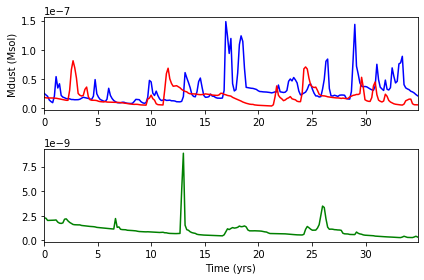

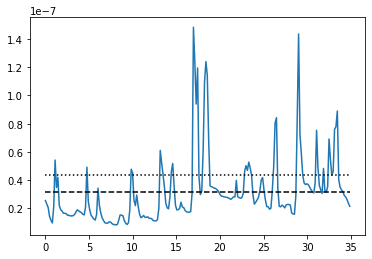

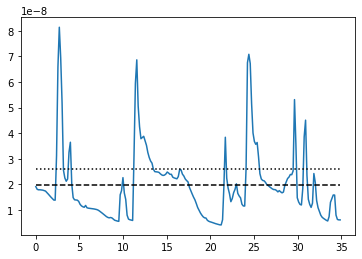

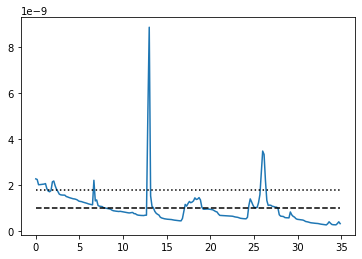

In [4]:
# Load and plot dust mass vs time
import numpy as np
import matplotlib.pyplot as plt
import analyze_timedep_functions as atf

# Load data from *052 model
path052 = '../r3dresults/st28gm06n052_timedep_nospikes/'
phasetimes052 = np.loadtxt(path052+'snapshot_yr.dat')[:,1]
dustmass052 = np.loadtxt(path052+'dustmass.dat')[:,1]
time052 = phasetimes052 - phasetimes052[0]
# Statistics
totaltime052 = phasetimes052[-1]-phasetimes052[0] # Total time length in yrs


# Load data from *074 model
path074 = '../r3dresults/st28gm06n074_nospikes/'
phasetimes074 = np.loadtxt(path074+'snapshot_yr.dat')[:,1]
dustmass074 = np.loadtxt(path074+'dustmass.dat')[:,1]
time074 = phasetimes074 - phasetimes074[0]
# Statistics
totaltime074 = phasetimes074[-1]-phasetimes074[0] # Total time length in yrs
meanmass074 = np.mean(dustmass074)
maxmass074 = np.max(dustmass074)


# Load data from *075 model
path075 = '../r3dresults/st28gm06n075_nospikes/'
phasetimes075 = np.loadtxt(path075+'snapshot_yr.dat')[:,1]
dustmass075 = np.loadtxt(path075+'dustmass.dat')[:,1]
time075 = phasetimes075 - phasetimes075[0]
# Statistics
totaltime075 = phasetimes075[-1]-phasetimes075[0] # Total time length in yrs
meanmass075 = np.mean(dustmass075)
maxmass075 = np.max(dustmass075)


# Iniatiate figure object
fig,ax = plt.subplots(2,1)

# Plot both dust masses on top of eachother
ax[0].plot(time052,dustmass052,'b')
ax[0].plot(time074,dustmass074,'r')
ax[1].plot(time075,dustmass075,'g')

ax[0].set_ylabel('Mdust (Msol)')
ax[1].set_xlabel('Time (yrs)')
ax[0].set_xlim([time052[0],time052[-1]])
ax[1].set_xlim([time052[0],time052[-1]])

# Save figure for reference later
fig.tight_layout()
fig.savefig('../r3dplots/052_074_075_dustmasscompare.pdf', dpi=300)
#
# Extract occurance of events and plot to check
#
relative_limit = 0.1

print('052')
atf.extract_events(
    eventdata = dustmass052,
    timerange = phasetimes052,
    relative_limit=relative_limit
)
print('074')
atf.extract_events(
    eventdata = dustmass074,
    timerange = phasetimes074,
    relative_limit=relative_limit
)
print('075')
atf.extract_events(
    eventdata = dustmass075,
    timerange = phasetimes075,
    relative_limit=relative_limit
)

#
# Show figs
#fig.show()

# Extract periodicity
dustprodperiod052 = atf.compute_period(
    signal=dustmass052,
    timeaxis=time052,
)
print(f'052: {dustprodperiod052} yrs')

dustprodperiod074 = atf.compute_period(
    signal=dustmass074,
    timeaxis=time074,
)
print(f'074: {dustprodperiod074} yrs')

dustprodperiod075 = atf.compute_period(
    signal=dustmass075,
    timeaxis=time075,
)
print(f'075: {dustprodperiod075} yrs')


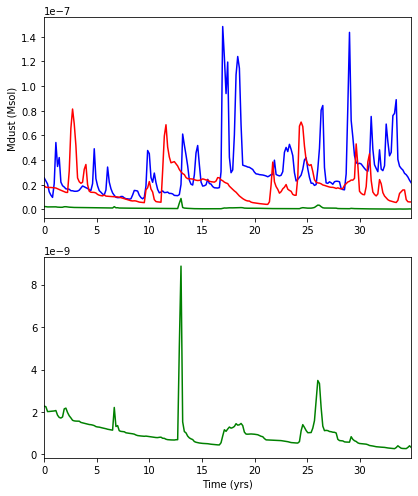

In [7]:
# Load and plot dust mass vs time
import numpy as np
import matplotlib.pyplot as plt
import analyze_r3d_functions as a3d

# Load data from *052 model
path052 = '../r3dresults/st28gm06n052_timedep_nospikes/'
phasetimes052 = np.loadtxt(path052+'snapshot_yr.dat')[:,1]
dustmass052 = np.loadtxt(path052+'dustmass.dat')[:,1]
time052 = phasetimes052 - phasetimes052[0]

# Load data from *074 model
path074 = '../r3dresults/st28gm06n074_nospikes/'
phasetimes074 = np.loadtxt(path074+'snapshot_yr.dat')[:,1]
dustmass074 = np.loadtxt(path074+'dustmass.dat')[:,1]
time074 = phasetimes074 - phasetimes074[0]

# Load data from *075 model
path075 = '../r3dresults/st28gm06n075_nospikes/'
phasetimes075 = np.loadtxt(path075+'snapshot_yr.dat')[:,1]
dustmass075 = np.loadtxt(path075+'dustmass.dat')[:,1]
time075 = phasetimes075 - phasetimes075[0]

# Iniatiate figure object
fig,ax = plt.subplots(2,1, figsize=(6,7))


# Plot both dust masses on top of eachother
ax[0].plot(time052,dustmass052,'b')
ax[0].plot(time074,dustmass074,'r')
ax[0].plot(time075,dustmass075,'g')
ax[1].plot(time075,dustmass075,'g')

ax[0].set_ylabel('Mdust (Msol)')
ax[1].set_xlabel('Time (yrs)')
ax[0].set_xlim([time052[0],time052[-1]])
ax[1].set_xlim([time052[0],time052[-1]])


# Save figure
fig.tight_layout()

In [ ]:
# Print mean and median dust masses
import numpy as np

# Load data from *052 model
path052 = '../r3dresults/st28gm06n052_timedep_nospikes/'
dustmass052 = np.loadtxt(path052+'dustmass.dat')[:,1]

# Load data from *074 model
path074 = '../r3dresults/st28gm06n074_nospikes/'
dustmass074 = np.loadtxt(path074+'dustmass.dat')[:,1]

# Load data from *075 model
path075 = '../r3dresults/st28gm06n075_nospikes/'
dustmass075 = np.loadtxt(path075+'dustmass.dat')[:,1]

print(f'052\n  mean: {np.mean(dustmass052)} Msol\n  median: {np.median(dustmass052)} Msol\n')
print(f'074\n  mean: {np.mean(dustmass074)} Msol\n  median: {np.median(dustmass074)} Msol\n')
print(f'075\n  mean: {np.mean(dustmass075)} Msol\n  median: {np.median(dustmass075)} Msol\n')




052
  mean: 3.1776680292172366e-08 Msol
  median: 2.598811254611197e-08 Msol

074
  mean: 1.9608047175062693e-08 Msol
  median: 1.7004422379805567e-08 Msol

075
  mean: 1.0274235394461546e-09 Msol
  median: 8.64211781470254e-10 Msol



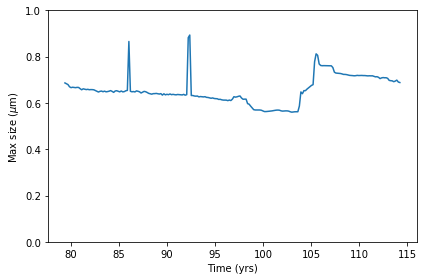

In [3]:
# Plot 075's max grain size bin vs time
import numpy as np
import matplotlib.pyplot as plt

# Load data from *075 model
path075 = '../r3dresults/st28gm06n075_nospikes/'
phasetimes075 = np.loadtxt(path075+'snapshot_yr.dat')[:,1]
grainsize075 = np.loadtxt(path075+'maxgrainsize.dat')[:,1]

plt.plot(phasetimes075,grainsize075)
plt.xlabel('Time (yrs)')
plt.ylabel(r'Max size ($\mu$m)')
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('../r3dplots/075_maxgrainsize.pdf', dpi=300)


### Lum(time)-plots

In [8]:
# Extract luminosity of all spectra in Lsol
import os
import numpy as np
import matplotlib.pyplot as plt
import analyze_r3d_functions as a3d
from matplotlib import rc

Lsol = 3.828e26 # Watt

paths = [
    '../r3dresults/st28gm06n052_timedep_nospikes/',
    #'../r3dresults/st28gm06n052_timedep_nodust/',
    #'../r3dresults/st28gm06n074_nospikes/',
    #'../r3dresults/st28gm06n074_nodust/',
    #'../r3dresults/st28gm06n075_nospikes/',
    #'../r3dresults/st28gm06n075_nodust/',
]
for path in paths:

    phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
    phases.sort()
    Nphases = len(phases)
    angles = [
        'i000_phi000',
        'i090_phi000',
        'i090_phi090',
        'i090_phi270',
        'i180_phi000',
        'i270_phi000',
    ]
    # Start printing output stuff in dat-file
    with open(f'{path}luminosity.dat', 'w') as flum:
        flum.write(f'# Number of phases: {Nphases}\n')
        flum.write(f'#  Phase  {angles[0]}  {angles[1]}  {angles[2]}  {angles[3]}  {angles[4]}  {angles[5]}  Average\n')

        # Loop through time
        for phase in phases:

            # Declare an LOS-average luminosity
            lumaverage = 0
            # and a lift for lums in direction
            luminosities = []

            # Loop through angles
            for angle in angles:
                luminosity = a3d.compute_sed_luminosity(
                    path = f'{path}{phase}/spectrum_{angle}.out'
                )/Lsol
                lumaverage += luminosity
                luminosities.append(luminosity)

            lumaverage /= 6            
            flum.write(f'   {phase}    {luminosities[0]:.3f}     {luminosities[1]:.3f}     {luminosities[2]:.3f}     {luminosities[3]:.3f}     {luminosities[4]:.3f}     {luminosities[5]:.3f}     {lumaverage:.3f}\n')

    print(path.split('/')[-2])
    print('  Writing Lums: Done')


st28gm06n052_timedep_nospikes
  Writing Lums: Done


  Total included time: 34.85688583615784 time units
  Relative limit: 0.1
  Number of events: 24
  Average pediod between events: 1.4523702431732435 time units
  Total length of events: 13.308727431567036 time units
  Average length of events: 0.5545303096486265 time units
  Portion of events: 0.38181056948471254

  FFT-Periods: [1.45237024 1.65985171 1.51551678 1.39427543] yrs


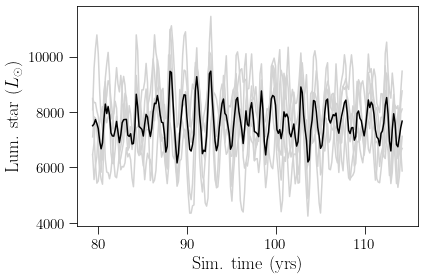

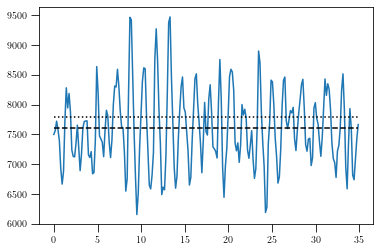

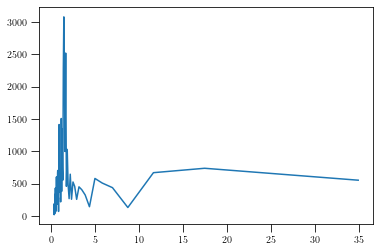

In [ ]:
# Plot all luminosities vs time and extract statistics
import numpy as np
import os
import matplotlib.pyplot as plt
import analyze_timedep_functions as atf
from matplotlib import rc


# Figure settings
rc('font',**{'family':'serif','serif':['serif']})
rc('text', usetex=True)
rc('xtick.major',size=8)
rc('xtick.minor',size=4)
rc('ytick.major',size=8)
rc('ytick.minor',size=4)

# Set paths and model name
#path = '../r3dresults/st28gm06n052_timedep_nodust/'
#modelabbreviation = '052_nodust'
#path = '../r3dresults/st28gm06n052_timedep_nospikes/'
#modelabbreviation = '052'

#path = '../r3dresults/st28gm06n074_nodust/'
#modelabbreviation = '074_nodust'
#path = '../r3dresults/st28gm06n074_nospikes/'
#modelabbreviation = '074'

path = '../r3dresults/st28gm06n075_nodust/'
modelabbreviation = '075_nodust'
#path = '../r3dresults/st28gm06n075_nospikes/'
#modelabbreviation = '075'


# Extract phases, times, lums
phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
phases.sort()
Nphases = len(phases)
phasetimes = np.loadtxt(path+'snapshot_yr.dat')[:,1]
luminosities = np.loadtxt(path+'luminosity.dat')
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
Nangles = len(angles)

# Plot all angles as grey and average as black ontop
fig, ax = plt.figure(num=1, figsize=(6, 4)), plt.axes()

for nangle in range(Nangles):
    ax.plot(phasetimes,luminosities[:,nangle+1],color='lightgrey')

# Average is the last column
ax.plot(phasetimes,luminosities[:,-1],'-',color='black')
ax.set_xlabel(r'Sim. time (yrs)',fontsize=18);

# Change ylabel according to dust or not
if len(modelabbreviation) > 3:
    ax.set_ylabel(r'Lum. star ($L_\odot$)',fontsize=18);
else:
    ax.set_ylabel(r'Lum. star and dust ($L_\odot$)',fontsize=18);

ax.tick_params(
    axis='both', 
    which='major', 
    labelsize=15
)
ax.grid(
    visible=False,
    which='both',
    axis='x'
)
fig.tight_layout()
fig.savefig(
    f'/home/joachim/exwings/r3dplots/{modelabbreviation}_lum_vs_time.pdf',
    dpi=300,
    facecolor='white'
)
# Extract event-statistics
atf.extract_events(
    eventdata = luminosities[:,-1],
    timerange = phasetimes,
    relative_limit=0.1
)

# Extract periodicity of the highest numbers of the fft
periods = atf.compute_period(
    signal = luminosities[:,-1],
    timeaxis = phasetimes,
    plot_spec='y'
)
print(f'  FFT-Periods: {periods} yrs')



#### Extract some Lum and flux numbers

In [2]:
# Load and extract verious liminosities for the paper
import numpy as np
import os

paths = [
    '../r3dresults/st28gm06n052_timedep_nodust/',
    '../r3dresults/st28gm06n074_nodust/',
    '../r3dresults/st28gm06n075_nodust/',
    '../r3dresults/st28gm06n052_timedep_nospikes/',
    '../r3dresults/st28gm06n074_nospikes/',
    '../r3dresults/st28gm06n075_nospikes/',
]
modelabbreviations = [
    '052_nodust',
    '074_nodust',
    '075_nodust',
    '052_nospikes',
    '074_nospikes',
    '075_nospikes',
]
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
Nangles = len(
    angles
)
for path,modelabbreviation in zip(paths,modelabbreviations):

    # Extract phases, times, lums
    phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
    phases.sort()
    Nphases = len(phases)
    phasetimes = np.loadtxt(path+'snapshot_yr.dat')[:,1]
    luminosities = np.loadtxt(path+'luminosity.dat')
    # [:,0] - snapshots
    # [:,1 tom 6] - angle-dependent lums
    # [:,-1] - angle-averaged lums

    # Print average luminosities
    print(f'  {modelabbreviation} - average lum: {np.mean(luminosities[:,-1])} Lsol')

    
    if modelabbreviation[-8:] == 'nospikes':

        # Print average max-lum with dust
        print(f'  {modelabbreviation} - average max lum: {np.max(luminosities[:,-1])} Lsol')

        # Print the max-max lum, max of all angles
        print(f'  {modelabbreviation} - max-max lum: {np.max(luminosities[:,1:-1])} Lsol')

        # Print average minimum lum with dust
        print(f'  {modelabbreviation} - average min lum: {np.min(luminosities[:,-1])} Lsol')

        # Print min-min lum with dust
        print(f'  {modelabbreviation} - min-min lum: {np.min(luminosities[:,1:-1])} Lsol')









  052_nodust - average lum: 7623.889592760182 Lsol
  074_nodust - average lum: 7632.387339366515 Lsol
  075_nodust - average lum: 7603.132628959276 Lsol
  052_nospikes - average lum: 5325.214027149322 Lsol
  052_nospikes - average max lum: 7948.66 Lsol
  052_nospikes - max-max lum: 11216.202 Lsol
  052_nospikes - average min lum: 3217.095 Lsol
  052_nospikes - min-min lum: 583.556 Lsol
  074_nospikes - average lum: 6146.020846153845 Lsol
  074_nospikes - average max lum: 8237.554 Lsol
  074_nospikes - max-max lum: 11017.651 Lsol
  074_nospikes - average min lum: 4403.186 Lsol
  074_nospikes - min-min lum: 766.543 Lsol
  075_nospikes - average lum: 7314.732800904978 Lsol
  075_nospikes - average max lum: 9101.957 Lsol
  075_nospikes - max-max lum: 10948.281 Lsol
  075_nospikes - average min lum: 5911.108 Lsol
  075_nospikes - min-min lum: 3815.841 Lsol


In [19]:
# write out min, max, average flux densities at 2um and 10um
import numpy as np
import os

paths = [
    '../r3dresults/st28gm06n052_timedep_nodust/',
    '../r3dresults/st28gm06n074_nodust/',
    '../r3dresults/st28gm06n075_nodust/',
    '../r3dresults/st28gm06n052_timedep_nospikes/',
    '../r3dresults/st28gm06n074_nospikes/',
    '../r3dresults/st28gm06n075_nospikes/',
]
modelabbreviations = [
    '052_nodust',
    '074_nodust',
    '075_nodust',
    '052_nospikes',
    '074_nospikes',
    '075_nospikes',
]
for path,modelabbreviation in zip(paths,modelabbreviations):

    # Extract phases, times, lums
    phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
    phases.sort()
    Nphases = len(phases)
    phasetimes = np.loadtxt(path+'snapshot_yr.dat')[:,1]
    flux_densities = np.loadtxt(path+'average_sed.dat')
    # [:,0] - wavelength
    # [:,1] - averageF
    # [:,2] - std
    # [:,3] - max
    # [:,4] - min

    # Find index of 2 and 10um
    ntwomicron = np.argwhere(flux_densities[:,0] > 2)[0][0] - 1
    ntenmicron = np.argwhere(flux_densities[:,0] > 10)[0][0] - 1

    # Print average flux densities
    print(f'  {modelabbreviation} - average  F2um: {flux_densities[ntwomicron,1]*1e-6:.3f} MJy')
    print(f'  {modelabbreviation} - average F10um: {flux_densities[ntenmicron,1]*1e-6:.3f} MJy')

    
    if modelabbreviation[-8:] == 'nospikes':
        # Print min/max flux densities
        print(f'  {modelabbreviation} - min  F2um: {flux_densities[ntwomicron,4]*1e-6:.3f} MJy')
        print(f'  {modelabbreviation} - max F10um: {flux_densities[ntenmicron,3]*1e-6:.3f} MJy')

        # Print difference to average
        print(f'  {modelabbreviation} - aver-min  F2um: {(flux_densities[ntwomicron,1]-flux_densities[ntwomicron,4])*1e-6:.3f} MJy')
        print(f'  {modelabbreviation} - max-aver F10um: {(flux_densities[ntenmicron,3]-flux_densities[ntenmicron,1])*1e-6:.3f} MJy')

    # Print relative difference to average
    print(f'  {modelabbreviation} - rel diff  F2um: {(flux_densities[ntwomicron,1]-flux_densities[ntwomicron,4])/flux_densities[ntwomicron,1]:.3f}')
    print(f'  {modelabbreviation} - rel diff F10um: {(flux_densities[ntenmicron,3]-flux_densities[ntenmicron,1])/flux_densities[ntenmicron,1]:.3f}')




  052_nodust - average  F2um: 97.044 MJy
  052_nodust - average F10um: 20.782 MJy
  052_nodust - rel diff  F2um: 0.396
  052_nodust - rel diff F10um: 0.356
  074_nodust - average  F2um: 97.235 MJy
  074_nodust - average F10um: 20.897 MJy
  074_nodust - rel diff  F2um: 0.388
  074_nodust - rel diff F10um: 0.359
  075_nodust - average  F2um: 96.940 MJy
  075_nodust - average F10um: 20.824 MJy
  075_nodust - rel diff  F2um: 0.379
  075_nodust - rel diff F10um: 0.235
  052_nospikes - average  F2um: 68.726 MJy
  052_nospikes - average F10um: 27.650 MJy
  052_nospikes - min  F2um: 2.171 MJy
  052_nospikes - max F10um: 39.281 MJy
  052_nospikes - aver-min  F2um: 66.555 MJy
  052_nospikes - max-aver F10um: 11.631 MJy
  052_nospikes - rel diff  F2um: 0.968
  052_nospikes - rel diff F10um: 0.421
  074_nospikes - average  F2um: 80.894 MJy
  074_nospikes - average F10um: 25.476 MJy
  074_nospikes - min  F2um: 3.688 MJy
  074_nospikes - max F10um: 35.792 MJy
  074_nospikes - aver-min  F2um: 77.205 

#### extract dust-star-contrasts

In [ ]:
# Load and check one figure
import analyze_r3d_functions as a3d
import numpy as np
import os

models = [
    'st28gm06n052_timedep',
    'st28gm06n074',
    'st28gm06n075'
]
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]

# Loop through models
for model in models:

    # Load stellar average flux at 10um
    starSEDs = np.loadtxt(f'../r3dresults/{model}_nodust/average_sed.dat')
    tenmicron = np.where(starSEDs[:,0] > 10)[0][0]-1
    startenflux = starSEDs[tenmicron,1]

    # Declare empty list
    fluxsums = []

    # Extract snapshot numbers and loop through them
    path = f'../r3dresults/{model}_nospikes/'
    snapshots = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]

    for snapshot in snapshots:

        # Loop through angles
        for angle in angles:

            # Load image
            image2d,image2dlog,totalflux,axisplot = a3d.load_images(
                path=f'../r3dresults/{model}_nospikes/{snapshot}',
                image=f'image_{angle}_10um.out'
            )
            # Size of image and pixels
            Npix = np.shape(image2d)[0]
            pixelsize = 2*axisplot[1] / Npix

            # Radius of "stellar circle" in pixels
            Rin_pixels = 2/pixelsize
            # And radius of outer part of important dust region
            Rout_pixels = 8/pixelsize

            # Loop through iamge and save total flux outside the star
            fluxsum = 0
            for nx in range(Npix):
                for ny in range(Npix):
                    # Check if pixel is within stellar circle
                    pixelcoord = np.sqrt((nx-0.5*Npix)**2 + (ny-0.5*Npix)**2)

                    # Sum all pixels outside this
                    # flux in Jy/pixel is image2d * pixelsize(asec2)
                    if pixelcoord > Rin_pixels and pixelcoord < Rout_pixels:
                        fluxsum += image2d[nx,ny] * pixelsize**2

            fluxsums.append(fluxsum)            
    # Take average of all and compare with average flux density of 10um from the star
    print(f'{model}')
    print(f'    Mean contrast (dust/star):   {np.mean(fluxsums)/startenflux}')
    print(f'    Median constrat (dust/star): {np.median(fluxsums)/startenflux}')
    print(f'    Mean dust flux: {np.mean(fluxsums)}. Median dust flux: {np.median(fluxsums)}')

# OUTPUT notes (20min per model)
# st28gm06n052_timedep
#     Mean contrast (dust/star):   0.5951135548257981
#     Median constrat (dust/star): 0.5877750860782606
#     Mean dust flux: 12367792.552373314. Median dust flux: 12215282.735741451
# 
# st28gm06n074
#     Mean contrast (dust/star):   0.515662117720173
#     Median constrat (dust/star): 0.49675065351239295
#     Mean dust flux: 10775684.195016574. Median dust flux: 10380495.254496064
#
# st28gm06n075
#     Mean contrast (dust/star):   0.39002486640644257
#     Median constrat (dust/star): 0.387207184550776
#     Mean dust flux: 8121845.315783781. Median dust flux: 8063170.143629588






st28gm06n052_timedep
    Mean contrast (dust/star):   0.5951135548257981
    Median constrat (dust/star): 0.5877750860782606
    Mean dust flux: 12367792.552373314. Median dust flux: 12215282.735741451
st28gm06n074
    Mean contrast (dust/star):   0.515662117720173
    Median constrat (dust/star): 0.49675065351239295
    Mean dust flux: 10775684.195016574. Median dust flux: 10380495.254496064
st28gm06n075
    Mean contrast (dust/star):   0.39002486640644257
    Median constrat (dust/star): 0.387207184550776
    Mean dust flux: 8121845.315783781. Median dust flux: 8063170.143629588


In [26]:
totalflux

27908892.59526563

In [28]:
fluxsum/totalflux

0.012587846262029592

In [27]:
fluxsum

351312.84933269984

### SED-based plots

Total included time: 18.220694067254854
Angle          Time ratio            Periods
i000_phi000 :  0.10344827586206896   [18.22069407  9.11034703  6.07356469  3.64413881]
i090_phi000 :  0.19827586206896552   [18.22069407  9.11034703  6.07356469  2.6029563 ]
i090_phi090 :  0.3620689655172414   [18.22069407  4.55517352  9.11034703  3.64413881]
i090_phi270 : N/A
i180_phi000 :  0.08620689655172414   [18.22069407  9.11034703  6.07356469  2.6029563 ]
i270_phi000 :  0.2413793103448276   [9.11034703 4.55517352 3.03678234 6.07356469]


/home/joachim/exwings/exwings-codes/analyze_r3d_functions.py:2796: RuntimeWarning: divide by zero encountered in divide
  period_axis = 1/freqs * delta_timestep


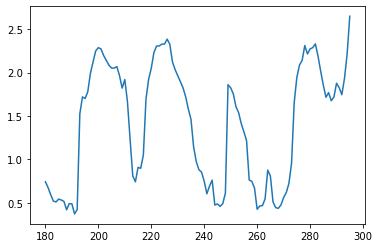

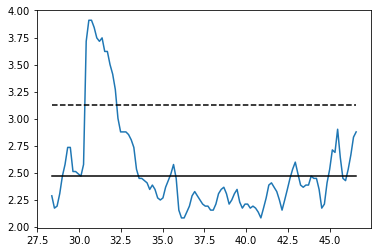

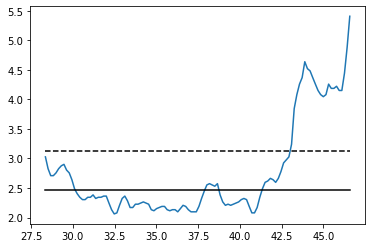

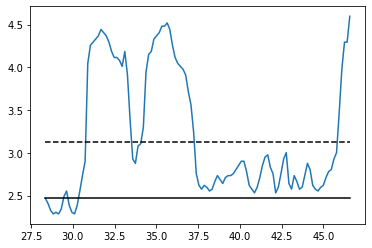

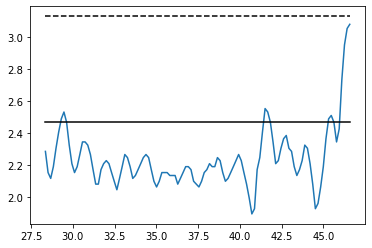

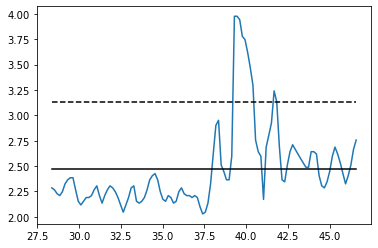

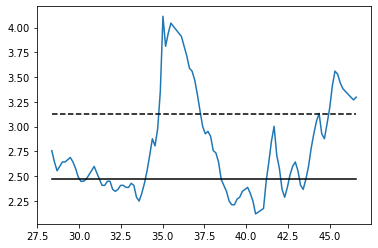

In [ ]:
# Extract and plot lambda_peak(time)
import analyze_r3d_functions as a3d
import analyze_timedep_functions as atf
import matplotlib.pyplot as plt
import numpy as np
import os

# TODO
# add real time x-axis to these
#
# compare with F2-plots and with F10-plots, or results on obscurations

# Set path settings
path = '../r3dresults/st28gm06n052_timedep_nospikes/'
modelabbreviation = '052'
#path = '../r3dresults/st28gm06n074_nospikes/'
#modelabbreviation = '074'
#path = '../r3dresults/st28gm06n075_nospikes/'
#modelabbreviation = '075'

# Extract list of folders from the path folder, and make them to numbers, and sort them!
phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
phases.sort()

# And load corresponding time
snapshot_times = np.loadtxt(path+'snapshot_yr.dat')[:,1]

# Set LOS-angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
# Extract lambdapeak of average SED (and difference between that and std's max)
average_sed = np.loadtxt(f'{path}average_sed.dat')
lambda_peak_average = average_sed[np.argmax(average_sed[:,1]),0]
lambda_peak_std = np.abs(
    average_sed[np.argmax(average_sed[:,1]),0] - average_sed[np.argmax(average_sed[:,1]+average_sed[:,2]),0]
)
# Extract all lambda_peaks
lambda_peak = np.zeros((len(phases),len(angles)))
for nphase,phase in enumerate(phases):
    for nangle,angle in enumerate(angles):
        wavelength, spectrum = a3d.load_spectrum(
            path=f'{path}{phase}/spectrum_{angle}.out'
        )
        maxindex = np.argmax(spectrum)
        lambda_peak[nphase,nangle] = wavelength[maxindex]

# Save max-changes of lambdapeak
minmax = np.zeros(len(phases))
for nphase,phase in enumerate(phases):
    minmax[nphase] = np.max(lambda_peak[nphase,:]) - np.min(lambda_peak[nphase,:])
plt.figure(num='max differnce (due to angle) in lambda')
plt.plot(phases,minmax)



print(f'Total included time: {snapshot_times[-1] - snapshot_times[0]}')
print('Angle          Time ratio            Periods')
for nangle,angle in enumerate(angles):

    # Take out FFT of each direction of when curve is more than 1sigma from
    # average lambdapeak
    lambda_peak_major = np.zeros(len(phases))
    event_index = np.argwhere(lambda_peak[:,nangle] > lambda_peak_average+3*lambda_peak_std)
    lambda_peak_major[event_index] = lambda_peak[event_index,nangle]

    periods = atf.compute_period(
        signal=lambda_peak_major,
        timeaxis=snapshot_times
    )
    if np.sum(lambda_peak_major) != 0:
        event_ratio = len(event_index)/len(phases)
        print(f'{angle} :  {event_ratio}   {periods}')
    else:
        print(f'{angle} : N/A')

    # And plot lambdapeak(um) vs time directly, one plot per angle
    plt.figure(num=f'lambdapeak variations {angle}')
    plt.plot(snapshot_times,lambda_peak[:,nangle])
    # Plot average and average plus std-based lambdapeak
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [lambda_peak_average,lambda_peak_average],'k'
    )
    # Dashed line for 3x lambdapeak-std-based value
    plt.plot(
        [snapshot_times[0],snapshot_times[-1]],
        [lambda_peak_average+3*lambda_peak_std,lambda_peak_average+3*lambda_peak_std],'k--'
    )


In [1]:
# Translate Filterprofiles relevant from smith2002 suh2021 to my wavelengthgrid
import analyze_r3d_functions as a3d
import os

filterfolder = '../filterprofiles/'
filelist = os.listdir(filterfolder)


# Loop through files
for file in filelist:
    if file != 'wavelength_micron.inp':
        if file[:3] != 'r3d':
            a3d.translate_filter(
                filterpath=f'{filterfolder}{file}',
                wavelengthr3d=f'{filterfolder}wavelength_micron.inp'
            )



In [4]:
# Test run wavelength filter on a spectrum
import numpy as np

wavelengths = np.loadtxt(f'../r3dresults/st28gm06n052_timedep_nospikes/average_sed.dat')[:,0]
average = np.loadtxt(f'../r3dresults/st28gm06n052_timedep_nospikes/average_sed.dat')[:,1]

# Extract 2.2-wavelengthflux
nwave2p2um = np.argwhere(wavelengths >= 2.2)[0][0] -1
print(f'{average[nwave2p2um]} Jy at {wavelengths[nwave2p2um]} um')

# Extract filter-based 2.2-um-flux, 2MASS Kband
filterKband = np.loadtxt('../filterprofiles/r3d_2MASS.Ks_K2.2.dat')[:,1]
Kbandflux = np.trapz(filterKband  * average,wavelengths)
print(Kbandflux)







71487214.70328885 Jy at 2.189613737155 um
71093708.60470702


st28gm06n052
  Average   : 1.9418910973816157

  Maximum   : 1.7270763568094711
  Minimum   : 4.741980511010091

  Kmax-Wmin : 0.7472982938466739
  Kmin-Wmax : 5.721758573972888

  Std plus  : 1.3805180340372
  Std minus : 2.6849669643055467

st28gm06n074
  Average   : 1.7037484342494498

  Maximum   : 1.5796993127184376
  Minimum   : 4.1448493744277926

  Kmax-Wmin : 0.553049281065741
  Kmin-Wmax : 5.171499406080489

  Std plus  : 1.2508037548621402
  Std minus : 2.2401307078348065

st28gm06n075
  Average   : 1.4155890479233193

  Maximum   : 1.3161317666966141
  Minimum   : 1.6550559165287666

  Kmax-Wmin : 0.7572796254920444
  Kmin-Wmax : 2.2139080577333363

  Std plus  : 1.188032712286251
  Std minus : 1.6519107177386143

FK = FW when colour = 3.4878787878787882
FK > FW when colour < 3.4878787878787882
FK < FW when colour > 3.4878787878787882


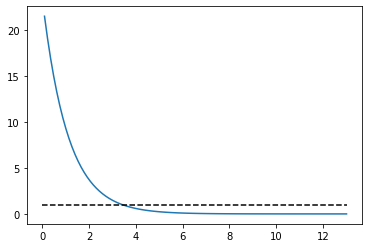

In [2]:
# Extract "colour" of the models
#
# one for average SEDs
# one for max, one for min
# two for stds
# gives info on the spread of colours similar to Suh2021
#
import numpy as np
import matplotlib.pyplot as plt

# Define K and W3-band values
# wavelengths (um)
Kwave = 2.159
W3wave = 11.56
# reference fluxes (Jy)
Kfluxzero = 666.7
W3fluxzero = 28.3


modelfolders = [
    'st28gm06n052_timedep_nospikes',
    'st28gm06n074_nospikes',
    'st28gm06n075_nospikes'
]
models = [
    'st28gm06n052',
    'st28gm06n074',
    'st28gm06n075'
]
for nmodel in range(len(models)):
    print(models[nmodel])
    # Load average-sed-file
    allseds = np.loadtxt(f'../r3dresults/{modelfolders[nmodel]}/average_sed.dat')

    # Save time dep arrays in more useful names
    wavelengths = allseds[:,0]
    average = allseds[:,1]
    stdplus = allseds[:,1] + allseds[:,2]
    stdminus = allseds[:,1] - allseds[:,2]
    maximum = allseds[:,3]
    minimum = allseds[:,4]

    # Load appropiate filters
    Kbandfilter = np.loadtxt('../filterprofiles/r3d_2MASS.Ks_K2.2.dat')[:,1]
    W3bandfilter = np.loadtxt('../filterprofiles/r3d_WISE.W3_12.dat')[:,1]

    # Apply for each wavelength band and each level and integrate the flux density
    KaverageJY = np.trapz(Kbandfilter * average, wavelengths)
    KstdplusJY = np.trapz(Kbandfilter * stdplus, wavelengths)
    KstdminusJY = np.trapz(Kbandfilter * stdminus, wavelengths)
    KmaximumJY = np.trapz(Kbandfilter * maximum, wavelengths)
    KminimumJY = np.trapz(Kbandfilter * minimum, wavelengths)

    W3averageJY = np.trapz(W3bandfilter * average, wavelengths)
    W3stdplusJY = np.trapz(W3bandfilter * stdplus, wavelengths)
    W3stdminusJY = np.trapz(W3bandfilter * stdminus, wavelengths)
    W3maximumJY = np.trapz(W3bandfilter * maximum, wavelengths)
    W3minimumJY = np.trapz(W3bandfilter * minimum, wavelengths)

    # Compute magnitudes for the two wavelegth rehimes   TODO
    Kaverage = -2.5 * np.log10( KaverageJY /Kfluxzero)
    Kstdplus = -2.5 * np.log10( KstdplusJY /Kfluxzero)
    Kstdminus = -2.5 * np.log10(KstdminusJY/Kfluxzero)
    Kmaximum = -2.5 * np.log10( KmaximumJY /Kfluxzero)
    Kminimum = -2.5 * np.log10( KminimumJY /Kfluxzero)

    W3average = -2.5 * np.log10( W3averageJY /W3fluxzero)
    W3stdplus = -2.5 * np.log10( W3stdplusJY /W3fluxzero)
    W3stdminus = -2.5 * np.log10(W3stdminusJY/W3fluxzero)
    W3maximum = -2.5 * np.log10( W3maximumJY /W3fluxzero)
    W3minimum = -2.5 * np.log10( W3minimumJY /W3fluxzero)

    colour_average = Kaverage - W3average
    colour_stdplus = Kstdplus - W3stdminus
    colour_stdminus = Kstdminus - W3stdplus
    colour_maximum = Kmaximum - W3maximum
    colour_minimum = Kminimum - W3minimum
    colour_KmaxWmin = Kmaximum - W3minimum
    colour_KminWmax = Kminimum - W3maximum

    print(f'  Average   : {colour_average}')
    #print(f'      Std   : {0.5*(colour_average-colour_stdplus + colour_stdminus-colour_average)}')
    print('')
    print(f'  Maximum   : {colour_maximum}')
    print(f'  Minimum   : {colour_minimum}')
    print('')
    print(f'  Kmax-Wmin : {colour_KmaxWmin}')
    print(f'  Kmin-Wmax : {colour_KminWmax}')
    print('')
    print(f'  Std plus  : {colour_stdplus}')
    print(f'  Std minus : {colour_stdminus}')
    print('')

    # testplot
#    plt.figure(nmodel)
#    plt.plot(wavelengths,average)
#    plt.plot(wavelengths,stdplus,'--')
#    plt.plot(wavelengths,stdminus,'--')
#    plt.plot(wavelengths,maximum,':')
#    plt.plot(wavelengths,minimum,':')
#    plt.xscale('log')
#    plt.yscale('log')
#    plt.xlim(0.5,40)
#    plt.ylim(1e5,2e8)


# Plot beahviour of colour in terms of flux density ratio

colour = np.linspace(0.1,13,100)
plt.plot(
    colour,
    Kfluxzero/W3fluxzero*10**(-colour/2.5)
)
plt.plot(
    [0,13],
    [1,1],'k--'
)

onepoint = np.argwhere(Kfluxzero/W3fluxzero*10**(-colour/2.5) <= 1)[0][0]
print(f'FK = FW when colour = {colour[onepoint]}')
print(f'FK > FW when colour < {colour[onepoint]}')
print(f'FK < FW when colour > {colour[onepoint]}')






In [ ]:
# Extract flux densities of models for comparison with source specific data
# Ie
#
# aavso.org     smith2002     smith2002
# Vband         cobe-dirbe    cobe-dirbe
# 0.5556um      2.2um         3.5um
#
# Vband/visual is from various telescopes, lets keep that as is, ie just the data
# at exactly that wavelength.
# and use the rest from filtered data.
import numpy as np


modelfolders = [
    'st28gm06n052_timedep_nospikes',
    'st28gm06n074_nospikes',
    'st28gm06n075_nospikes'
]
models = [
    'st28gm06n052',
    'st28gm06n074',
    'st28gm06n075'
]
for nmodel in range(len(models)):
    # Load average-sed-file
    allseds = np.loadtxt(f'../r3dresults/{modelfolders[nmodel]}/average_sed.dat')

    # Save time dep arrays in more useful names
    wavelengths = allseds[:,0]
    average = allseds[:,1]
    minimum = allseds[:,4]

    # Load appropiate filters
    # r3d_COBE_DIRBE.2p2m.dat
    # r3d_COBE_DIRBE.3p5m.dat
    cobe2p2_filter = np.loadtxt('../filterprofiles/r3d_COBE_DIRBE.2p2m.dat')[:,1]
    cobe3p5_filter = np.loadtxt('../filterprofiles/r3d_COBE_DIRBE.3p5m.dat')[:,1]

    # Apply for each wavelength band and each level and integrate the flux density
    cobe2p2_average = np.trapz(cobe2p2_filter * average, wavelengths)
    cobe2p2_min = np.trapz(cobe2p2_filter * minimum, wavelengths)

    cobe3p5_average = np.trapz(cobe3p5_filter * average, wavelengths)
    cobe3p5_min = np.trapz(cobe3p5_filter * minimum, wavelengths)

    # Also extract fluxes and ratio at Vband, 0.5556um
    nwave_Vband = np.argwhere(wavelengths >= 0.5556)[0][0] - 1
    vband_average = average[nwave_Vband]
    vband_min = minimum[nwave_Vband]

    # Print
    print(f'{models[nmodel]}: minimum/average')
    print(f'      Vband : {vband_min} / {vband_average} = {vband_min/vband_average}')
    print(f'  COBE[2.2] : {cobe2p2_min} / {cobe2p2_average} = {cobe2p2_min/cobe2p2_average}')
    print(f'  COBE[3.5] : {cobe3p5_min} / {cobe3p5_average} = {cobe3p5_min/cobe3p5_average}')
    print('')




st28gm06n052
st28gm06n052: minimum/average
      Vband : 2270.3581756129993 / 2525517.386228667 = 0.0008989675493793789
  COBE[2.2] : 3561392.1957586873 / 71631160.59027615 = 0.04971847679712371
  COBE[3.5] : 13628817.75154429 / 66726329.31313842 = 0.20424947530960277

st28gm06n074
st28gm06n074: minimum/average
      Vband : 9690.463392944 / 2866405.1622983627 = 0.0033807026028288057
  COBE[2.2] : 5171485.887070388 / 83380851.23105927 = 0.06202246451933577
  COBE[3.5] : 16942138.181830786 / 73083583.24308887 = 0.2318186578985632

st28gm06n075
st28gm06n075: minimum/average
      Vband : 227930.45254799994 / 3864153.52898719 = 0.05898586866131621
  COBE[2.2] : 57975858.47997972 / 96436526.18542948 = 0.6011815312437006
  COBE[3.5] : 55162361.15935599 / 79176861.77245198 = 0.6966979989417645



Total number in IRAS: 4037.0
  st28gm06n052: 848.0 (21.00569729997523 proc)
  st28gm06n074: 1106.0 (27.396581620014864 proc)
  st28gm06n075: 3380.0 (83.72553876641071 proc)
Total number in WISE: 5252.0
  st28gm06n052: 43.0 (0.8187357197258188 proc)
  st28gm06n074: 71.0 (1.351865955826352 proc)
  st28gm06n075: 1427.0 (27.17060167555217 proc)


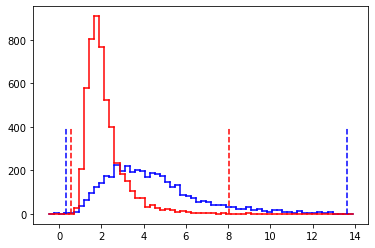

In [ ]:
# Testplot histograms from Suh2021
# and check for how many/portion of stars are above the model's
# most red limits
import matplotlib.pyplot as plt

catnames =[
    'IRAS',
    'WISE'
]
catcolours = ['b','r']
catfiles = [
    '../paper2/suh21_histdata/oagb_iras-k-w3_data.csv',
    '../paper2/suh21_histdata/oagb_wise-k-w3_data.csv'
]
catredlimits = [
    13.6,   # iras max
    8.02,   # wise max
]
# Models
modelnames = [
    'st28gm06n052',
    'st28gm06n074',
    'st28gm06n075',
]
modelredlimits = [
    5.722,
    5.171,
    2.214,
]

for catname,catfile,catcolour,catredlimit in zip(catnames,catfiles,catcolours,catredlimits):

    startnumb = []
    endnumb = []
    starnumb = []
    totalnumbstars = 0

    with open(catfile, 'r') as Fcat:
        for line in Fcat.readlines():
            if line[0] != 'B':
                linesplit = line.split(',')
                startnumb.append(float(linesplit[0]))
                endnumb.append(float(linesplit[1]))
                starnumb.append(float(linesplit[2]))

    # Plot all and sum upp total number of stars
    for nn in range(len(starnumb)):
        totalnumbstars += starnumb[nn]
        if nn == 0:
            plt.plot(
                [startnumb[nn],startnumb[nn]],
                [0,starnumb[nn]],catcolour
            )
            plt.plot(
                [startnumb[nn],endnumb[nn]],
                [starnumb[nn],starnumb[nn]],catcolour
            )
        else:
            plt.plot(
                [startnumb[nn],startnumb[nn]],
                [starnumb[nn-1],starnumb[nn]],catcolour
            )
            plt.plot(
                [startnumb[nn],endnumb[nn]],
                [starnumb[nn],starnumb[nn]],catcolour
            )
    # Check how many stars are within or outside my model ranges
    print(
        f'Total number in {catname}: {totalnumbstars}'
    )
    for modelredlimit,modelname in zip(modelredlimits,modelnames):
        totalredstars = 0
        for nn in range(len(starnumb)):
            if startnumb[nn] >= modelredlimit and endnumb[nn] <= catredlimit:
                totalredstars += starnumb[nn]
        print(f'  {modelname}: {totalredstars} ({totalredstars/totalnumbstars*100} proc)')

# Plot minmax-values

# Wise
plt.plot(
    [0.58,0.58],
    [0,400],
    'r--'
)
plt.plot(
    [8.02,8.02],
    [0,400],
    'r--'
)
# Iras
plt.plot(
    [0.34,0.34],
    [0,400],
    'b--'
)
plt.plot(
    [13.6,13.6],
    [0,400],
    'b--'
)






In [5]:
type(line[0])


str

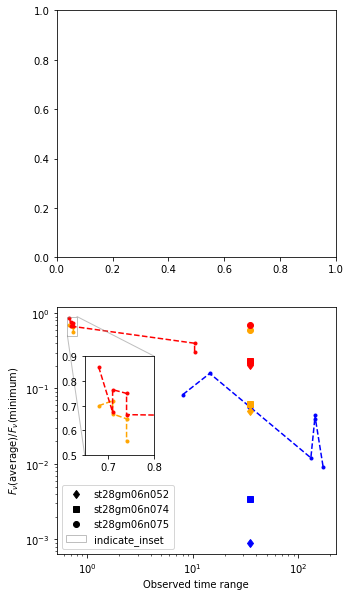

In [7]:
# Testplot figure with colours and flux-ratios compared to data
#
# fluxratioploten
# yaxel: flux ratio i log
# xaxeln: obstid
# olika symboler för olika källor, linjer mellan källorna, ensamma punkter för modeller
import numpy as np
import matplotlib.pyplot as plt

# each row: model
# each column: Vband, Cobe2.2, Cobe3.5
modeltime =  34.857
modelfluxratios = np.array([
    [0.00089898,0.04972 , 0.20425],
    [0.0033807 ,0.06202 , 0.23182],
    [0.058986  ,0.60118 , 0.69670],
])
modelnames = [
    'st28gm06n052',
    'st28gm06n074',
    'st28gm06n075',
]

# Save all band data separately
visualdata = np.array([
    [  8.06 ,0.083179  ],
    [ 14.47 ,0.15850   ],
    [131.18 ,0.012023  ],
    [143.96 ,0.044055  ],
    [144.73 ,0.039811  ],
    [171.37 ,0.0091201 ],
])
Kbanddata = np.array([
    [0.68 , 0.700],
    [0.71 , 0.720],
    [0.71 , 0.667],
    [0.74 , 0.647],
    [0.74 , 0.558],
])
W1banddata = np.array([
    [ 0.68, 0.857  ],
    [ 0.71, 0.674  ],
    [ 0.71, 0.765  ],
    [ 0.74, 0.75   ],
    [ 0.74, 0.664  ],
    [10.4 , 0.39810],
    [10.4 , 0.30199],
])
allobsdata = [
    visualdata,
    Kbanddata,
    W1banddata
]
# Save all band data in one master array for a "master line"
# take average of those at "same" time to change weighting
alldata = np.array([
    [0.68 , 0.700],
    [0.68 , 0.857],
    [0.71 , 0.667],
    [0.71 , 0.674],
    [0.71 , 0.720],
    [0.71 , 0.765],
    [0.74 , 0.558],
    [0.74 , 0.647],
    [0.74 , 0.664],
    [0.74 , 0.75 ],
    [  8.06 ,0.083179  ],
    [10.4 , 0.30199 ],
    [10.4 , 0.39810 ],
    [ 14.47 ,0.15850   ],
    [131.18 ,0.012023  ],
    [143.96 ,0.044055  ],
    [144.73 ,0.039811  ],
    [171.37 ,0.0091201 ],
])
# Line based on averages at the two extremes
#averagex = [
#    0.1 *(2*0.68 + 4*0.71 + 4*0.74),
#    0.25*(131.18 + 143.96 + 144.73 + 171.37)
#]
#averagey = [
#    0.1*(0.700 + 0.857 + 0.667 + 0.674 + 0.720 + 0.765 + 0.558 + 0.647 + 0.664 + 0.75),
#    0.25*(0.012023 + 0.044055 + 0.039811 + 0.0091201)
#]
#plt.plot(averagex,averagey,'k:')

fig,ax = plt.subplots(
    2,1,
    figsize=(5,10)
)
axin = ax[1].inset_axes(
    bounds=[0.1,0.4,0.25,0.4]
)


wavecolour = ['b','orange','r']
modelsymbol = ['d','s','o']

#ax[1].plot(alldata[:,0],alldata[:,1],'k:')
#axin.plot(alldata[:,0],alldata[:,1],'k:')

for nwave,obsdata in enumerate(allobsdata):

    obstime = obsdata[:,0]
    fluxratios = obsdata[:,1]


    # polyfit en linje per våglängdsområde?
    #pcoeffs = np.polyfit(
    #    obstime,
    #    fluxratios,
    #    deg=2
    #)
    #polyliney = [
    #    pcoeffs[0]*obstime[0]**2 + pcoeffs[1]*obstime[0] + pcoeffs[2],
    #    pcoeffs[0]*obstime[-1]**2 + pcoeffs[1]*obstime[-1] + pcoeffs[2],
    #]

    ax[1].plot(obstime,fluxratios,'.',color=wavecolour[nwave])
    ax[1].plot(obstime,fluxratios,'--',color=wavecolour[nwave])
    axin.plot(obstime,fluxratios,'.',color=wavecolour[nwave])
    axin.plot(obstime,fluxratios,'--',color=wavecolour[nwave])

    #plt.plot([obstime[0],obstime[-1]],polyliney,color=wavecolour[nwave])


    # Plot model results
    for nmodel in range(3):
        ax[1].plot(modeltime,modelfluxratios[nmodel,nwave],modelsymbol[nmodel],color=wavecolour[nwave])
        axin.plot(modeltime,modelfluxratios[nmodel,nwave],modelsymbol[nmodel],color=wavecolour[nwave])


# Add model labels
for nmodel,modelname in enumerate(modelnames):
    ax[1].plot(-1,-1,modelsymbol[nmodel],color='k',markersize=6,label=modelname)




ax[1].set_xscale('log')
ax[1].set_yscale('log')
axin.set_xlim(0.65,0.8)
axin.set_ylim(0.5,0.9)
ax[1].indicate_inset_zoom(axin);
ax[1].set_xlabel('Observed time range')
ax[1].set_ylabel(r'$F_\nu ($average$)/F_\nu ($minimum$)$')
ax[1].legend(
    #loc='upper right',
    fontsize=10
)


#plt.xlim(0.6,0.8)
#plt.ylim(0.6,0.8)

# 



(0, 4)

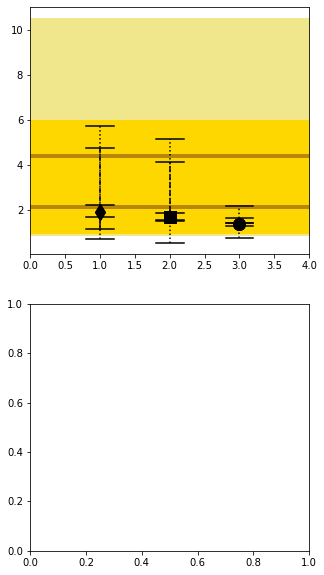

In [ ]:
import matplotlib.pyplot as plt

# Test plot panel with colours
#
#                Suh+2021 
#                fig9 IRAS      fig9 WISE
#               K[2.2]-W3[12]   K[2.2]-W3[12]    n052       n074        n075
#   maxK-minW3:  -               -               0.747      0.553       0.757
#          Max: 0.9             1                1.727      1.580       1.317
#          STD: 2.18            0.91             0.313      0.187       0.041
#        Medel: 4.39            2.15             1.942      1.704       1.416
#          STD: 2.18            0.91             0.313      0.187       0.041
#          Min: 10-11           6                4.742      4.145       1.655
#   minK-maxW3:  -               -               5.722      5.171       2.214
#
# xaxeln: modellerna
modelnames = [
    'st28gm06n052',
    'st28gm06n074',
    'st28gm06n075',
]
modelsymbol = [
    'd','s','o'
]
# Y-axel, div färger
# modellerna med "error-bar-aktiga" linjer

# Y-axis with model data in errorbar like
# max-min, max, avr+std, avr, avr-std, min, min-max
# 052,074,075
modeldata = [
    [
        0.747 ,  1.727 , 1.942+0.313 , 1.942 , 1.492-0.313 , 4.742 , 5.722
    ],
    [
        0.553 , 1.580 , 1.704+0.187 , 1.704 , 1.704-0.187 , 4.145 , 5.171 
    ],
    [
        0.757 , 1.317 , 1.416+0.041 , 1.416 , 1.416+0.041 , 1.655 , 2.214
    ]
]
linestyles = [
    ':','--','-'
]
# Set up figure object
fig,ax = plt.subplots(
    2,1,
    figsize=(5,10)
)
# Plot fields for observed statistics from Suh21
#
# From Fig9, 2 right panels two catalogues, 
#   first IRAScat-minmax
#   then  WISEcat-minmax
#   In middle, first: IRAS-mean, second: WISE-mean
suhdata = [
    0.9,
    1,
    4.39,
    2.15,
    6,
    10.5,
]
suhcolours = [
    'khaki','gold','darkgoldenrod','red'
]
modelaxis = [0,4]
for nfield in range(4):
    if nfield < 2:
        ax[0].fill_between(
            modelaxis,
            [suhdata[nfield],suhdata[nfield]],
            [suhdata[-nfield-1],suhdata[-nfield-1]],
            color=suhcolours[nfield]
        )
    if nfield > 1:
        ax[0].plot(
            modelaxis,
            [suhdata[nfield],suhdata[nfield]],
            color=suhcolours[2],linewidth=4
        )    


# Plot model colour ranges
for nmodel,modeldat in enumerate(modeldata):
    # error bars
    for nn in range(3):
        ax[0].plot(
            [nmodel+1,nmodel+1],
            [modeldat[nn],modeldat[-nn-1]],
            'k',linestyle=linestyles[nn]
        )
        ax[0].plot(
            [nmodel+0.8,nmodel+1.2],
            [modeldat[nn],modeldat[nn]],
            'k'
        )
        ax[0].plot(
            [nmodel+0.8,nmodel+1.2],
            [modeldat[-nn-1],modeldat[-nn-1]],
            'k'
        )
    ax[0].plot(
        [nmodel+1,nmodel+1],
        [modeldat[3],modeldat[3]],
        modelsymbol[nmodel],color='k',markersize=12
    )

ax[0].set_xlim(0,4)



### Extract main source size

In [1]:
# Extract and save time-angle-dependent source-size at various lambda
import analyze_timedep_functions as atf
import numpy as np
import os

# Template size of all stars
Rstar = 1.65
# Chose model
models = [
    'st28gm06n052_timedep_nospikes',
    #'st28gm06n052_timedep_nodust',
    'st28gm06n074_nospikes',
    #'st28gm06n074_nodust',
    'st28gm06n075_nospikes',
    #'st28gm06n075_nodust'
]
# Chose wavelength (in um)
wavelengths = [
    #'01',
    '02',
    '10',
]
# Set LOS-angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
for modelname in models:
    for wavelength in wavelengths:

        # Extract list of folders from the path folder, and make them to numbers, and sort them!
        path = f'../r3dresults/{modelname}/'
        phases = [int(filename) for filename in os.listdir(path) if os.path.isdir(path+filename)]
        phases.sort()

        # Run extractor and save data
        atf.extract_sourcesize(
            path=path,
            phases=phases,
            angles=angles,
            wavelength=wavelength,
            save_datafile='y'
        )
        # Load and check the time-average size of the time-depdendant LOS-averaged size
        average_radii = np.loadtxt(f'../r3dresults/{modelname}/source_radius_{wavelength}um.dat')[:,1]
        average_radius = np.mean(average_radii)
        print(
            f'{modelname} radius at {wavelength} um: {average_radius} au. Ratio: {average_radius/Rstar}'
        )
        os.system(
            'spd-say moo'
        )
        # Empty line
        print(
            ''
        )





extract_sourcesize: Done
  Output written to ../r3dresults/st28gm06n052_timedep_nospikes/source_radius_02um.dat
st28gm06n052_timedep_nospikes radius at 02 um: 1.2251333484162894 au. Ratio: 0.742505059646236

extract_sourcesize: Done
  Output written to ../r3dresults/st28gm06n052_timedep_nospikes/source_radius_10um.dat
st28gm06n052_timedep_nospikes radius at 10 um: 1.2562538009049773 au. Ratio: 0.7613659399424105

extract_sourcesize: Done
  Output written to ../r3dresults/st28gm06n074_nospikes/source_radius_02um.dat
st28gm06n074_nospikes radius at 02 um: 1.4134196832579182 au. Ratio: 0.8566179898532839

extract_sourcesize: Done
  Output written to ../r3dresults/st28gm06n074_nospikes/source_radius_10um.dat
st28gm06n074_nospikes radius at 10 um: 1.4083635294117647 au. Ratio: 0.8535536541889484

extract_sourcesize: Done
  Output written to ../r3dresults/st28gm06n075_nospikes/source_radius_02um.dat
st28gm06n075_nospikes radius at 02 um: 1.6310965158371038 au. Ratio: 0.9885433429315781

extr

In [ ]:
# Print average flux density of nodust-data at each wavelength
# - to use to define fluxlimit in size-extractor
import numpy as np

paths = [
    '../r3dresults/st28gm06n052_timedep_nodust/average_sed.dat',
    '../r3dresults/st28gm06n074_nodust/average_sed.dat',
    '../r3dresults/st28gm06n075_nodust/average_sed.dat',
]
average_onemicron = 0
average_twomicron = 0
average_tenmicron = 0

for path in paths:

    wavelengths = np.loadtxt(path)[:,0]
    average_sed = np.loadtxt(path)[:,1]

    onemicron = np.where(wavelengths >= 1 )[0][0]
    twomicron = np.where(wavelengths >= 2 )[0][0]
    tenmicron = np.where(wavelengths >= 10)[0][0]

    average_onemicron += average_sed[onemicron]
    average_twomicron += average_sed[twomicron]
    average_tenmicron += average_sed[tenmicron]

    print(path.split('/')[-2])
    print(f'{wavelengths[onemicron]} um: {average_sed[onemicron]} Jy')
    print(f'{wavelengths[twomicron]} um: {average_sed[twomicron]} Jy')
    print(f'{wavelengths[tenmicron]} um: {average_sed[tenmicron]} Jy')
    print('')

average_onemicron /= len(paths)
average_twomicron /= len(paths)
average_tenmicron /= len(paths)

print('average_nodust')
print(f'{wavelengths[onemicron]} um: {average_onemicron} Jy')
print(f'{wavelengths[twomicron]} um: {average_twomicron} Jy')
print(f'{wavelengths[tenmicron]} um: {average_tenmicron} Jy')




st28gm06n052_timedep_nodust
1.00791589806 um: 42451806.19613231 Jy
2.010669926771 um: 97223628.13918304 Jy
10.07270043879 um: 20496420.35404154 Jy

st28gm06n074_nodust
1.00791589806 um: 42405880.05171331 Jy
2.010669926771 um: 97418618.79073843 Jy
10.07270043879 um: 20609549.741299596 Jy

st28gm06n075_nodust
1.00791589806 um: 42223897.16277945 Jy
2.010669926771 um: 97123325.49826032 Jy
10.07270043879 um: 20537622.784469306 Jy

average_nodust
1.00791589806 um: 42360527.80354169 Jy
2.010669926771 um: 97255190.80939393 Jy
10.07270043879 um: 20547864.293270145 Jy


In [3]:
# Separately load and check the "correctedness" of average of average radii of each model
import numpy as np

# Template size of all stars
Rstar = 1.65
# Chose model
models = [
    'st28gm06n052_timedep_nospikes',
    #'st28gm06n052_timedep_nodust',
    'st28gm06n074_nospikes',
    #'st28gm06n074_nodust',
    'st28gm06n075_nospikes',
    #'st28gm06n075_nodust'
]
# Chose wavelength (in um)
wavelengths = [
    '01',
    '02',
    '10'
]
for modelname in models:
    for wavelength in wavelengths:
        average_radii = np.loadtxt(f'../r3dresults/{modelname}/source_radius_{wavelength}um.dat')[:,1]
        average_radius = np.mean(average_radii)
        print(f'{modelname} radius at {wavelength} um: {average_radius} au. Ratio: {average_radius/Rstar}')
    print('')




st28gm06n052_timedep_nospikes radius at 01 um: 1.1356835746606335 au. Ratio: 0.6882930755518991
st28gm06n052_timedep_nospikes radius at 02 um: 1.2251333484162894 au. Ratio: 0.742505059646236
st28gm06n052_timedep_nospikes radius at 10 um: 1.2562538009049773 au. Ratio: 0.7613659399424105

st28gm06n074_nospikes radius at 01 um: 1.312903257918552 au. Ratio: 0.7956989441930619
st28gm06n074_nospikes radius at 02 um: 1.4134196832579182 au. Ratio: 0.8566179898532839
st28gm06n074_nospikes radius at 10 um: 1.4083635294117647 au. Ratio: 0.8535536541889484

st28gm06n075_nospikes radius at 01 um: 1.5836335746606336 au. Ratio: 0.9597779240367477
st28gm06n075_nospikes radius at 02 um: 1.6310965158371038 au. Ratio: 0.9885433429315781
st28gm06n075_nospikes radius at 10 um: 1.6149154751131223 au. Ratio: 0.9787366515837105



052_nodust at 10um: r3d-radius / co5bold-radius = 1.0059
074_nodust at 10um: r3d-radius / co5bold-radius = 1.0075
075_nodust at 10um: r3d-radius / co5bold-radius = 1.0058


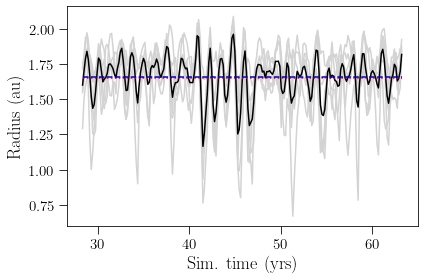

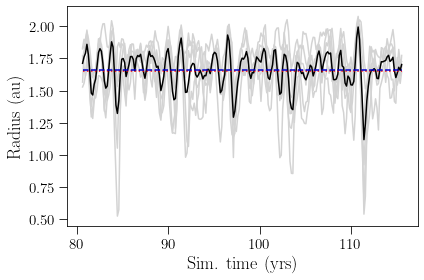

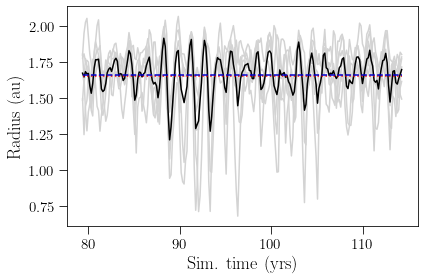

In [3]:
# Plot data on source radii as saved in cell above.
import matplotlib.pyplot as plt
import numpy as np
# Figure settings
from matplotlib import rc
rc('font',**{'family':'serif','serif':['serif']})
rc('text', usetex=True)
rc('xtick.major',size=8)
rc('xtick.minor',size=4)
rc('ytick.major',size=8)
rc('ytick.minor',size=4)

# Chose model
models = [
    #'st28gm06n052_timedep_nospikes',
    'st28gm06n052_timedep_nodust',
    #'st28gm06n074_nospikes',
    'st28gm06n074_nodust',
    #'st28gm06n075_nospikes',
    'st28gm06n075_nodust'
]
modelnumbs = [
    #'052',
    '052_nodust',
    #'074',
    '074_nodust',
    #'075',
    '075_nodust',
]
# Chose wavelength (in um)
wavelengths = [
    #'01',
    #'02',
    '10'
]
# Set LOS-angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
# Plot all
for modelname,modelnumb in zip(models,modelnumbs):
    for wavelength in wavelengths:
        
        path = f'../r3dresults/{modelname}/'

        # Load and plot radii vs time
        source_radii = np.loadtxt(f'{path}/source_radius_{wavelength}um.dat')

        # Load corresponding time
        snapshot_times = np.loadtxt(path+'snapshot_yr.dat')[:,1]

        # Set figure object
        fig, ax = plt.figure(figsize=(6, 4)), plt.axes()
        ax.set_ylabel(r'Radius (au)', fontsize=18)
        ax.set_xlabel(r'Sim. time (yrs)',fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=15)
        #ax.set_title(f'{modelnumb}: {wavelength}')

        # First plot angles
        for nangle in range(len(angles)):
            ax.plot(snapshot_times,source_radii[:,nangle+2],'lightgrey')
        # Then angle-averaged
        ax.plot(snapshot_times,source_radii[:,1],'k')

        # Plot "table radius" and average radius
        Rstar = 1.65
        source_radii_average = np.mean(source_radii[:,1])
        ax.plot(
            [snapshot_times[0],snapshot_times[-1]],
            [Rstar,Rstar],'r:'
        )
        ax.plot(
            [snapshot_times[0],snapshot_times[-1]],
            [source_radii_average,source_radii_average],'--',color='mediumblue'
        )
        ax.grid(
            visible=False,
            which='both',
            axis='x'
        )
        fig.tight_layout()
        # Save figure
        fig.savefig(f'../r3dplots/{modelnumb}_sourceradius_{wavelength}um.pdf', dpi=300, facecolor="white")

        # Print some interesting output
        print(f'{modelnumb} at {wavelength}um: r3d-radius / co5bold-radius = {source_radii_average/Rstar:.4f}')

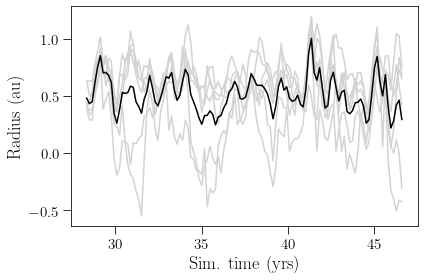

In [ ]:
# OLD TEMP FOR PAPER
# Plot Rsource minus Rstar for 2um -> negative values : obscured star, positive: enlarged
import matplotlib.pyplot as plt
import numpy as np
# Figure settings
from matplotlib import rc
rc('font',**{'family':'serif','serif':['serif']})
rc('text', usetex=True)
rc('xtick.major',size=8)
rc('xtick.minor',size=4)
rc('ytick.major',size=8)
rc('ytick.minor',size=4)

# Chose model
models = [
    'st28gm06n052_timedep_nospikes',
    #'st28gm06n052_timedep_nodust',
    #'st28gm06n074_nospikes',
    #'st28gm06n074_nodust',
    #'st28gm06n075_nospikes',
    #'st28gm06n075_nodust'
]
modelnumbs = [
    '052',
    #'052_nodust',
    #'074',
    #'074_nodust',
    #'075',
    #'075_nodust',
]
# Chose wavelength (in um)
wavelength = '02'

# Set LOS-angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]

# TODO
# städa den här koden!

# Plot all
for modelname,modelnumb in zip(models,modelnumbs):
    
    path = f'../r3dresults/{modelname}/'

    # Load source radius
    source_radii = np.loadtxt(f'{path}/source_radius_{wavelength}um.dat')

    # Load star radius
    star_radii = np.loadtxt(f'../r3dresults/st28gm06n{modelnumb}_timedep_nodust/source_radius_01um.dat')

    # Load corresponding time
    snapshot_times = np.loadtxt(path+'snapshot_yr.dat')[:,1]

    # Declare difference-array
    source_diff = np.zeros((len(snapshot_times),len(angles)))

    # Set figure object
    fig, ax = plt.figure(figsize=(6, 4)), plt.axes()
    ax.set_ylabel(r'Radius (au)', fontsize=18)
    ax.set_xlabel(r'Sim. time (yrs)',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Subtract sizes
    for nangle in range(len(angles)):
        source_diff[:,nangle] = source_radii[:,nangle+2] - star_radii[:,nangle+2] 

        # and plot
        ax.plot(snapshot_times,source_diff[:,nangle],'lightgrey')
    
    # Then angle-averaged
    source_diff_average = np.zeros(len(snapshot_times))
    for nphase in range(len(snapshot_times)):
        source_diff_average[nphase] = np.mean(source_diff[nphase,:])

    
    ax.plot(snapshot_times,source_diff_average,'k')

    #ax.grid(
    #    visible=False,
    #    which='both',
    #    axis='x'
    #)
    fig.tight_layout()
    # Save figure
    #fig.savefig(f'../r3dplots/{modelnumb}_radiusdiff_{wavelength}um.pdf', dpi=300, facecolor="white")





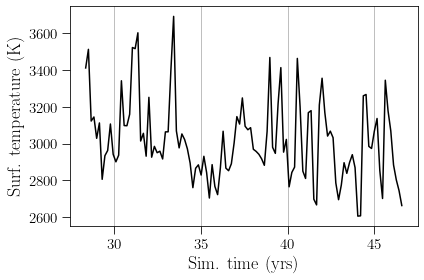

In [3]:
# Plot average temperature of spherical shell around Rsource
# Extract with atf.extract_surfacetemp()
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

# Figure settings
rc('font',**{'family':'serif','serif':['serif']})
rc('text', usetex=True)
rc('xtick.major',size=8)
rc('xtick.minor',size=4)
rc('ytick.major',size=8)
rc('ytick.minor',size=4)

path = '../r3dresults/st28gm06n052_timedep_nodust/'

# Load temperature and snapshot times
snapshot_times = np.loadtxt(path+'snapshot_yr.dat')[:,1]
surface_temperatures = np.loadtxt(path+'surface_temperature.dat')[:,1]

fig, ax = plt.figure(), plt.axes()
ax.plot(snapshot_times,surface_temperatures,'k')

ax.set_xlabel(r'Sim. time (yrs)',fontsize=18);
ax.set_ylabel(r'Surf. temperature (K)',fontsize=18);
ax.tick_params(
    axis='both', 
    which='major', 
    labelsize=15
)
ax.grid(
    visible=True,
    which='both',
    axis='x'
)

fig.tight_layout()
fig.savefig(
    f'/home/joachim/exwings/r3dplots/20241023_tillBT/052_nodust_surfacetemperature.pdf',
    dpi=300,
    facecolor='white'
)





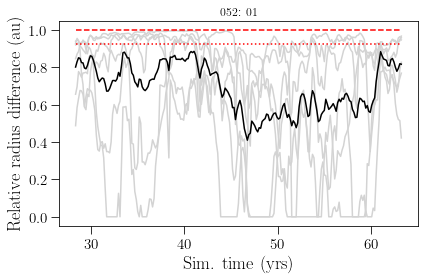

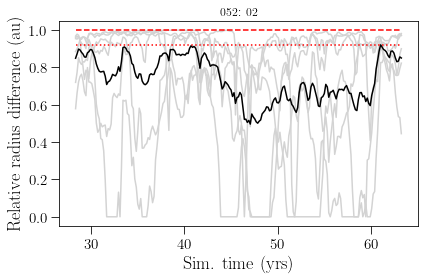

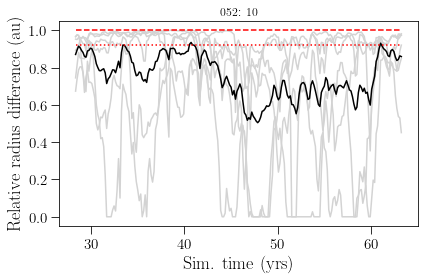

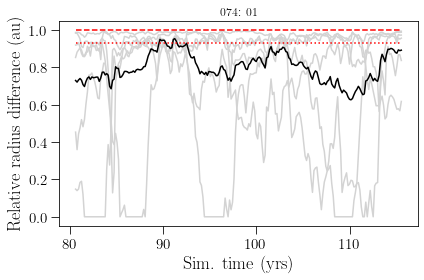

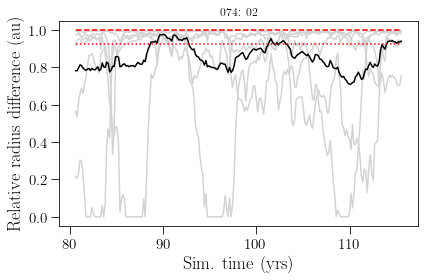

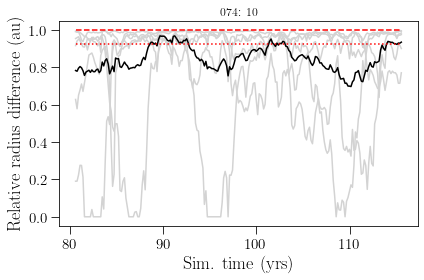

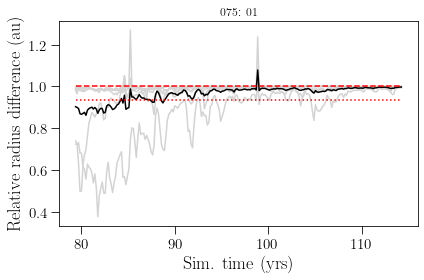

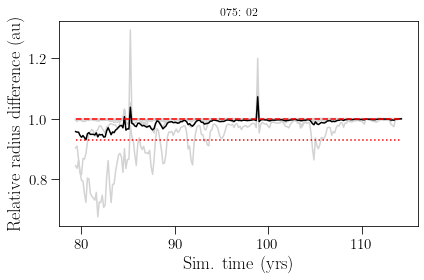

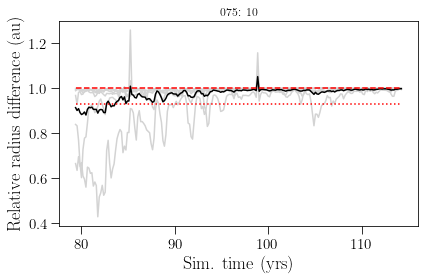

In [3]:
# Plot normalised comparison of source size and stellar size
import matplotlib.pyplot as plt
import numpy as np
# Figure settings
from matplotlib import rc
rc('font',**{'family':'serif','serif':['serif']})
rc('text', usetex=True)
rc('xtick.major',size=8)
rc('xtick.minor',size=4)
rc('ytick.major',size=8)
rc('ytick.minor',size=4)

# Chose model
models = [
    'st28gm06n052_timedep',
    'st28gm06n074',
    'st28gm06n075'
]
modelnumbs = [
    '052',
    '074',
    '075',
]
# Chose wavelength (in um)
wavelengths = [
    '01',
    '02',
    '10'
]
# Set LOS-angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
# Plot all
for modelname,modelnumb in zip(models,modelnumbs):
    for wavelength in wavelengths:
        
        path = f'../r3dresults/{modelname}_nospikes/'
        path_nodust = f'../r3dresults/{modelname}_nodust/'

        # Load all radii
        source_radii = np.loadtxt(f'{path}/source_radius_{wavelength}um.dat')[:,1:]
        star_radii = np.loadtxt(f'{path_nodust}/source_radius_{wavelength}um.dat')[:,1:]

        # Load corresponding time
        snapshot_times = np.loadtxt(path+'snapshot_yr.dat')[:,1]

        # Compute star-normalised radii
        normalised_radii = source_radii/star_radii
        normalised_std = np.std(star_radii[:,0])/np.average(star_radii[:,0])

        # Set figure object
        fig, ax = plt.figure(figsize=(6, 4)), plt.axes()
        ax.set_ylabel(r'Relative radius difference (au)', fontsize=18)
        ax.set_xlabel(r'Sim. time (yrs)',fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_title(f'{modelnumb}: {wavelength}')

        # First plot angles
        for nangle in range(len(angles)):
            ax.plot(snapshot_times,normalised_radii[:,nangle+1],'lightgrey')
        # Then angle-averaged
        ax.plot(snapshot_times,normalised_radii[:,0],'k')

        # Plot average stellar radius and STD of stellar radius, or so...
        # Stellar radius
        ax.plot(
            [snapshot_times[0],snapshot_times[-1]],
            [1,1],'r--'
        )
        ax.plot(
            [snapshot_times[0],snapshot_times[-1]],
            [1-normalised_std,1-normalised_std],'r:'
        )
        fig.tight_layout()




#### Measure source size events

i000_phi000
  FFT: [34.85688584 11.61896195  1.51551678  1.45237024]
  Total included time: 34.85688583615784 time units
  Number of events: 1
  Average pediod between events: 34.85688583615784 time units
  Total length of events: 0.158437231328179 time units
  Average length of events: 0.158437231328179 time units
  Portion of events: 0.004545363922437054

i090_phi000
  FFT: [17.42844292  3.87298732 11.61896195  1.5844039 ]
  Total included time: 34.85688583615784 time units
  Number of events: 3
  Average pediod between events: 11.618961945385948 time units
  Total length of events: 0.475311693984537 time units
  Average length of events: 0.158437231328179 time units
  Portion of events: 0.01363609176731116

i090_phi090
  FFT: [ 2.32379239 11.61896195  3.87298732 34.85688584]
  Total included time: 34.85688583615784 time units
  Number of events: 1
  Average pediod between events: 34.85688583615784 time units
  Total length of events: 0.158437231328179 time units
  Average length of 

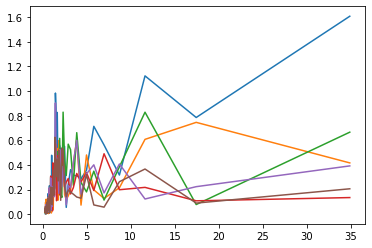

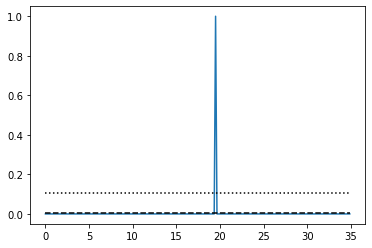

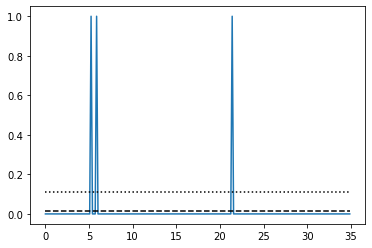

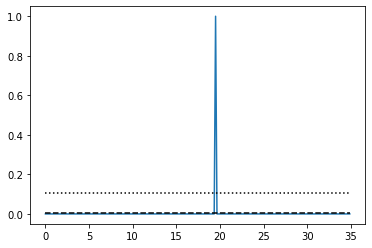

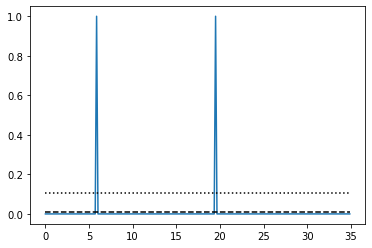

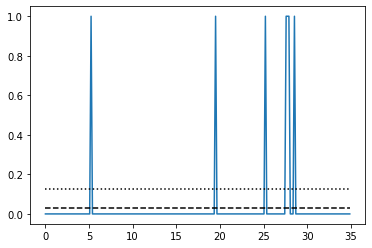

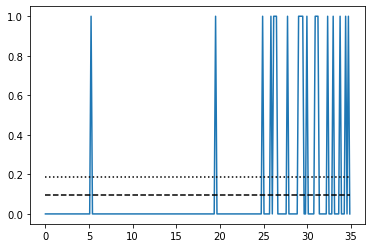

In [ ]:
# With 1&2um: measure major source size reductions
# With 10um: measure major source size increase

import numpy as np
import matplotlib.pyplot as plt
import analyze_timedep_functions as atf

# Chose wavelength
# Chose to check events where the source is smaller (reduced) or larger (increased)

#obscuration_type = 'reduced'
#wavelength = '01'
#wavelength = '02'
#rlimit = 0.75
#rlimit = 0.5

#obscuration_type = 'increased'
#wavelength = '10'
#rlimit = 1

#modelname = 'st28gm06n052_timedep'
#modelname = 'st28gm06n074'
modelname = 'st28gm06n075'

# Set path
path_starradi = f'../r3dresults/{modelname}_nodust/source_radius_{wavelength}um.dat'
path_sourceradi = f'../r3dresults/{modelname}_nospikes/source_radius_{wavelength}um.dat'

# Load snapshot times
phases = np.loadtxt(f'../r3dresults/{modelname}_nospikes/snapshot_yr.dat')[:,0]
snapshot_times = np.loadtxt(f'../r3dresults/{modelname}_nospikes/snapshot_yr.dat')[:,1]
Nphases = len(snapshot_times)

# List angles
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]

# Load stellar data
# each column is an angle
tempdata = np.loadtxt(path_starradi)
star_radii_average = tempdata[:,1]
star_radii_angles = tempdata[:,2:]


# Load dust+star data
tempdata = np.loadtxt(path_sourceradi)
source_radii_average = tempdata[:,1]
source_radii_angles = tempdata[:,2:]

# Loop through all phases and angles
# check source is XX times stellar source at same phase

for nangle,angle in enumerate(angles):
    dustevents = np.zeros(Nphases)

    # Extract events
    for nphase in range(Nphases):
        
        if obscuration_type == 'reduced':
            if source_radii_angles[nphase,nangle] <=  star_radii_angles[nphase,nangle]*rlimit:
                dustevents[nphase] = 1

        if obscuration_type == 'increased':
            if source_radii_angles[nphase,nangle] >= star_radii_angles[nphase,nangle]*rlimit:
                dustevents[nphase] = 1

    # Print FFT-data
    print(angle)
    # Extract periodicity of dustevents
    periods = atf.compute_period(
        signal=source_radii_angles[:,nangle],
        timeaxis=snapshot_times,
        plot_spec='y'
    )
    print(f'  FFT: {periods}')
    # Check if there are events:
    if np.sum(dustevents) != 0:
        # Extract statistics of dust events and plot events
        atf.extract_events(
            eventdata=dustevents,
            timerange=snapshot_times,
        )
    else:
        # Print output
        print(f'  N/A\n')





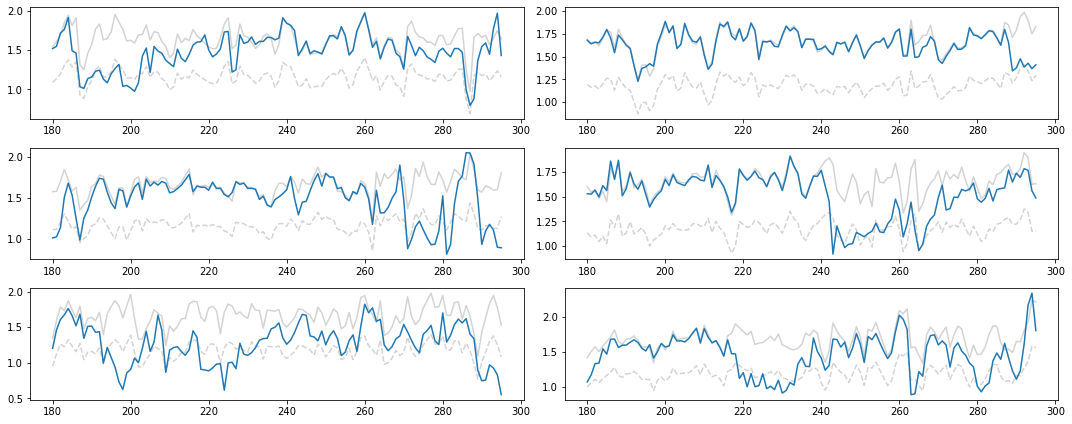

In [33]:
# Plot (For paper) difference in size between Rsource and Rstar
# Negative for obscuration
# Positive for increase

import numpy as np
import matplotlib.pyplot as plt

# Chose wavelength
# Chose to check events where the source is smaller (reduced) or larger (increased)
obscuration_type = 'reduced'
wavelength = '01'
#wavelength = '02'

#obscuration_type = 'increased'
#wavelength = '10'


# Set path
path_starradi = '../r3dresults/st28gm06n052_timedep_nodust/source_radius_01um.dat'
path_sourceradi = f'../r3dresults/st28gm06n052_timedep_nospikes/source_radius_{wavelength}um.dat'

# Load snapshot-times

# TODO


# Load stellar data
# each column is an angle
# NOTE included temporary to only use a subset of phases from starradi
tempdata = np.loadtxt(path_starradi)
star_radii = tempdata[:,2:]
phases = tempdata[:,0]

# Save number of phases and angles
Nphase = star_radii.shape[0]
Nangle = star_radii.shape[1]


# Load dust+star data
tempdata = np.loadtxt(path_sourceradi)
indexincludedphases = []
for phase in phases:
    # Extract phases from Rsource that exist in nodust NOTE temporary
    indexincludedphases.append(np.argwhere(tempdata[:,0] == phase)[0][0])
source_radii = tempdata[indexincludedphases,2:]

# Loop through all phases and angles
# Save difference in radius in this array
diff_radii = np.zeros(star_radii.shape)
half_star_radii = np.zeros(star_radii.shape)
sizelimit = np.sqrt(2)

for nangle in range(Nangle):
    for nphase in range(Nphase):
        diff_radii[nphase,nangle] = source_radii[nphase,nangle]
        if obscuration_type == 'reduced':
            half_star_radii[nphase,nangle] = star_radii[nphase,nangle]/sizelimit
        if obscuration_type == 'increased':
            half_star_radii[nphase,nangle] = star_radii[nphase,nangle]*sizelimit





fig, ax = plt.subplots(
    int(Nangle/2),2, 
    figsize = (15,6),
)

for nangle in range(Nangle):
    if nangle < 3:
        imind1 = nangle
        imind2 = 0
    else:
        imind1 = nangle-3
        imind2 = 1

    ax[imind1][imind2].plot(phases,star_radii[:,nangle],'lightgrey')
    ax[imind1][imind2].plot(phases,half_star_radii[:,nangle],linestyle='--',color='lightgrey')
    ax[imind1][imind2].plot(phases,diff_radii[:,nangle])

fig.tight_layout()    



### Extract Image photocentre

0.1259063562880535 0.04684689582098339
0.0763068825988203 0.02839205807332327


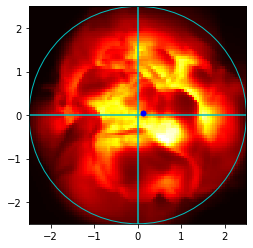

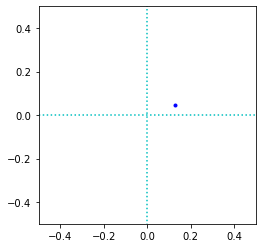

In [ ]:
# Test with only one snapshot and one image
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
import numpy as np


modelname = 'st28gm06n075_nodust'
snapshot = '250'
angle = 'i000_phi000'
wavelength = '02'
beamradius = 2.5
# TODO
# test to limit image to just inner +2 - -2 au
# Gaia beam size at 2um is between 1.01 and 0.34 asec
# at 100pc : 101 to 34 au. So the 30x30 image size is not bad to use

image2d,image2dlog,totalflux,axisplot = a3d.load_images(
    path=f'../r3dresults/{modelname}/{snapshot}/',
    image=f'image_{angle}_{wavelength}um.out',
    distance=1
)
# Testplot just to see
plt.figure(1)
plt.imshow(
    image2d, origin='lower', extent=axisplot, cmap=plt.get_cmap('hot')
)
# Compute photocentreposition
# Uses Eqs 6 and 7 from Beguin+2024
(Nx,Ny) = np.shape(image2d)
xrange = np.linspace(axisplot[0],axisplot[1],Nx)
yrange = np.linspace(axisplot[2],axisplot[3],Ny)


nominatorX = 0
nominatorY = 0

demoninator = 0

for nx in range(Nx):
    for ny in range(Ny):
        if np.sqrt(xrange[nx]**2 + yrange[ny]**2) < beamradius:
            
            # Xcoord-sums
            nominatorX += image2d[ny,nx] * xrange[nx]

            # Ycoord-sums
            nominatorY += image2d[ny,nx] * yrange[ny]

            # Common demoninator
            demoninator += image2d[ny,nx]


Px = nominatorX/demoninator
Py = nominatorY/demoninator

print(Px,Py)
print(Px/1.65,Py/1.65)

# Plot to check
plt.plot([-4,4],[0,0],'c-')
plt.plot([0,0],[-4,4],'c-')
plotbeam = plt.Circle((0,0),beamradius,color='c',fill=False)
plt.plot(Px,Py,'b.',markersize=10)
plt.ylim(-2.5,2.5);
plt.xlim(-2.5,2.5);
plt.gca().add_patch(plotbeam)

# Plot only coordinate, close-up
fig,ax = plt.figure(2), plt.axes()
ax.plot(Px,Py,'b.')
ax.plot([-4,4],[0,0],'c:')
ax.plot([0,0],[-4,4],'c:')
ax.set_ylim(-0.5,0.5);
ax.set_xlim(-0.5,0.5);
ax.set_aspect('equal', 'box')





In [1]:
# Scan and write new dat-files with photocentre-displacements

import analyze_r3d_functions as a3d
a3d.write_photocentre_files(
    model_path=f'../r3dresults/st28gm06n074_nospikes/',
    wavelength='02',
    angles = [
        'i000_phi000',
        'i090_phi000',
        'i090_phi090',
        'i090_phi270',
        'i180_phi000',
        'i270_phi000',
    ],
    beam_size=2.5
)



Running: write_photocentre_files
  Writing photocentre file
Done!


st28gm06n052_timedep_nodust
  Average pcR : 0.09112281435040057
  Median pcR  : 0.08606363636363637
  std dev pcR : 0.046733453777276175

st28gm06n074_nodust
  Average pcR : 0.09171608034366655
  Median pcR  : 0.08741212121212122
  std dev pcR : 0.04821130278310212

st28gm06n075_nodust
  Average pcR : 0.09315091600414795
  Median pcR  : 0.09008181818181818
  std dev pcR : 0.04569051904989835

Average for all
  Average pcR : 0.0919995444894808 +/- 0.04689456097352111


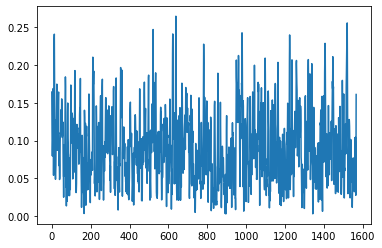

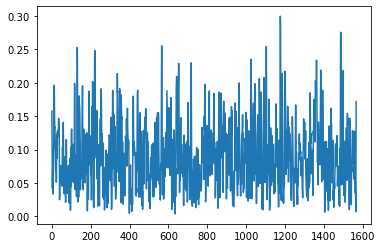

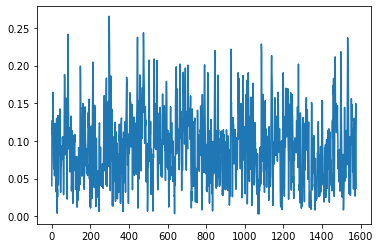

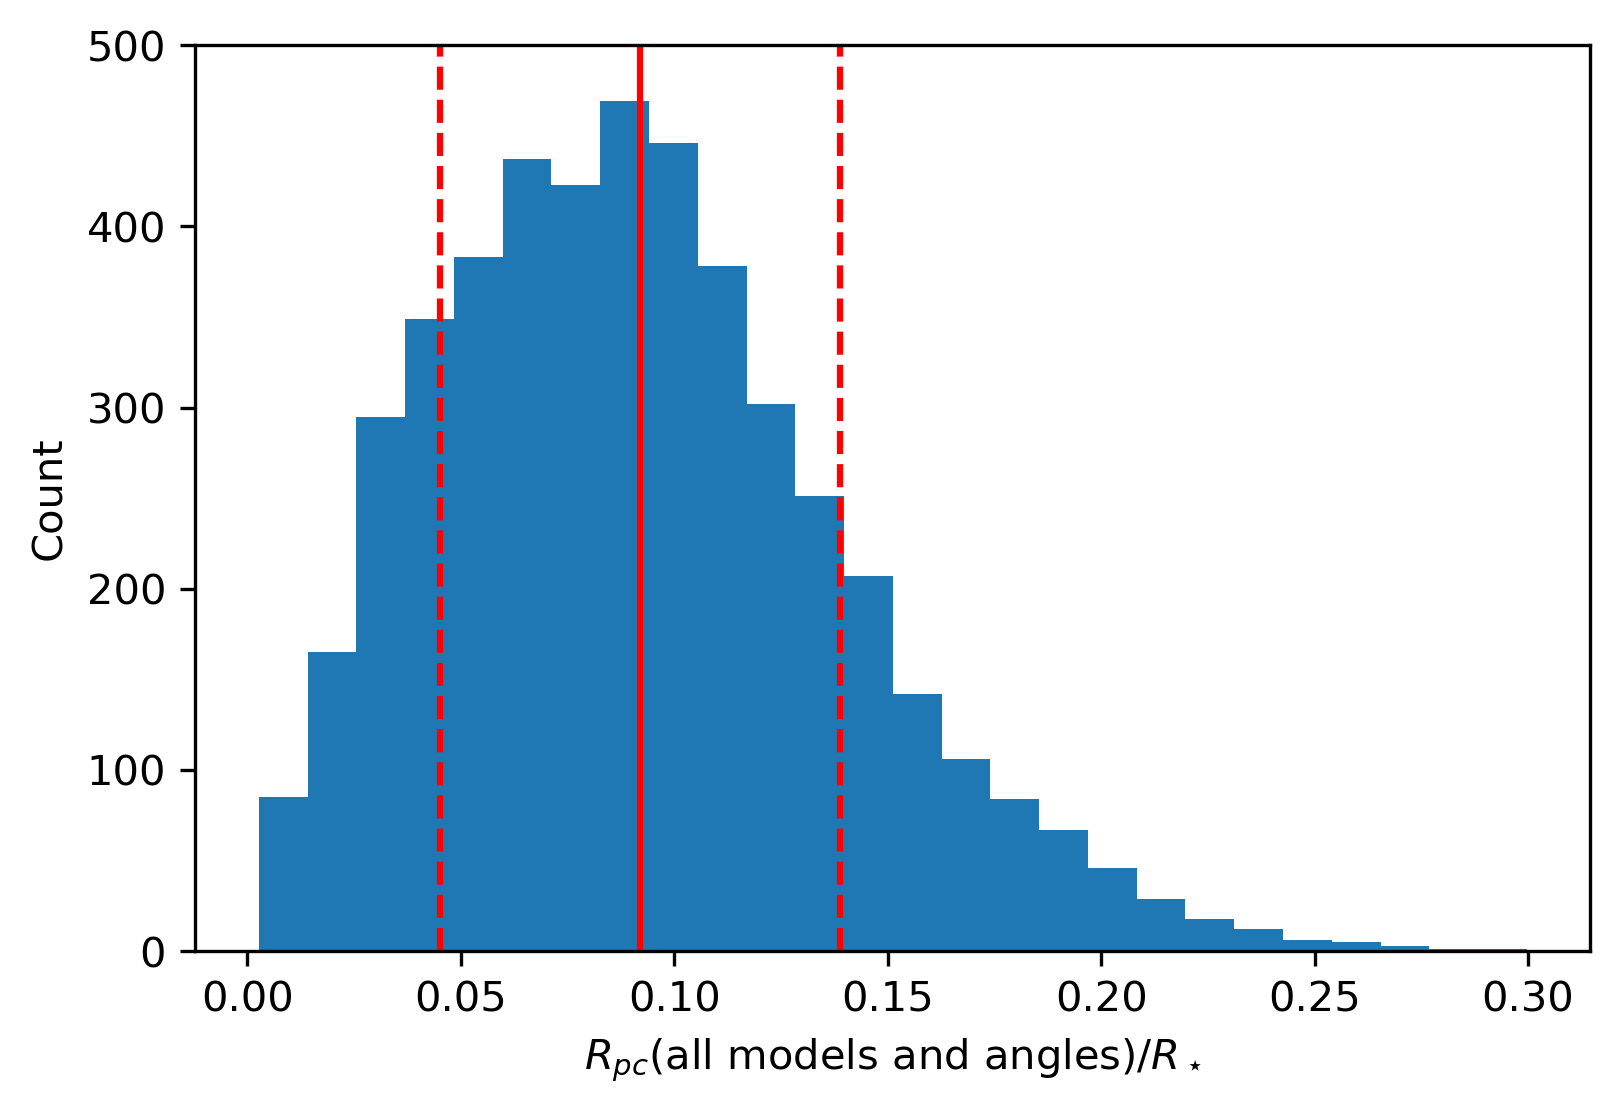

In [2]:
# Load all LOS and 3 nodust-models' photocentre coords
# and plot pcR(time) and statistics of these
# First for each model
# and then all combined, should be the same
import numpy as np
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt



modelnames = [
    'st28gm06n052_timedep_nodust',
    'st28gm06n074_nodust',
    'st28gm06n075_nodust',
]
Rstar = 1.65
pcR_all = []

for modelname in modelnames:
    pcR_time = []

    angles,snapshots,coordinatelist = a3d.load_photocentre_file(
        file_path=f'../r3dresults/{modelname}/photocentre_02um.dat'
    )

    # Extract all R(t) for all angles and save in a list
    for nangle,angle in enumerate(angles):
        for nsnapshot in range(len(snapshots)):

            pcR = coordinatelist[nangle][nsnapshot,2]/Rstar

            pcR_time.append(pcR)
            pcR_all.append(pcR)


    plt.figure(num=modelname)
    plt.plot(pcR_time)
    print(f'{modelname}\n  Average pcR : {np.mean(pcR_time)}\n  Median pcR  : {np.median(pcR_time)}\n  std dev pcR : {np.std(pcR_time)}')
    print()
# Modellerna är identiska utan stoft, som förväntat!

# Save overall av-std-numbers
pcR_average = np.mean(pcR_all)
pcR_std = np.std(pcR_all)

print('Average for all')
print(f'  Average pcR : {pcR_average} +/- {pcR_std}')


# Plot histogram of all models
fig4,ax4 = plt.figure(num=4,dpi=300), plt.axes()
(Npc, Rrange, patchinfo) = ax4.hist(pcR_all,int(np.round(len(snapshots)/10)))

# Plot averages and stds
ax4.plot(
    [pcR_average,pcR_average],
    [0,500],'r'
)
ax4.plot(
    [pcR_average+pcR_std,pcR_average+pcR_std],
    [0,500],'r--'
)
ax4.plot(
    [pcR_average-pcR_std,pcR_average-pcR_std],
    [0,500],'r--'
)
ax4.set_xlabel(r'$R_{pc}($all models and angles$) / R_\star$')
ax4.set_ylabel(r'Count')
ax4.set_ylim([0,500])
# Save figure
fig4.savefig('../r3dplots/all_photocentre_Rstar_Rtime_histogram.pdf')



st28gm06n052_timedep_nodust
  i000_phi000: -0.01016 , 0.02600  (0.09301)
  i090_phi000: -0.00069 , 0.01122  (0.08944)
  i090_phi090: -0.01336 , 0.03091  (0.09350)
  i090_phi270: 0.00451 , -0.02347  (0.08415)
  i180_phi000: 0.02490 , 0.00752  (0.09268)
  i270_phi000: -0.00876 , 0.02380  (0.09396)

st28gm06n074_nodust
  i000_phi000: -0.03116 , -0.02840  (0.09388)
  i090_phi000: 0.03050 , -0.02497  (0.08386)
  i090_phi090: 0.03359 , 0.02571  (0.08558)
  i090_phi270: 0.02395 , -0.03283  (0.09829)
  i180_phi000: 0.03524 , -0.02822  (0.09595)
  i270_phi000: -0.03887 , -0.02788  (0.09274)

st28gm06n075_nodust
  i000_phi000: 0.02619 , 0.01431  (0.08732)
  i090_phi000: 0.02970 , 0.01566  (0.10203)
  i090_phi090: 0.02241 , -0.03104  (0.10156)
  i090_phi270: 0.02497 , 0.02598  (0.09291)
  i180_phi000: -0.01832 , 0.01265  (0.09120)
  i270_phi000: -0.02454 , 0.01146  (0.08390)



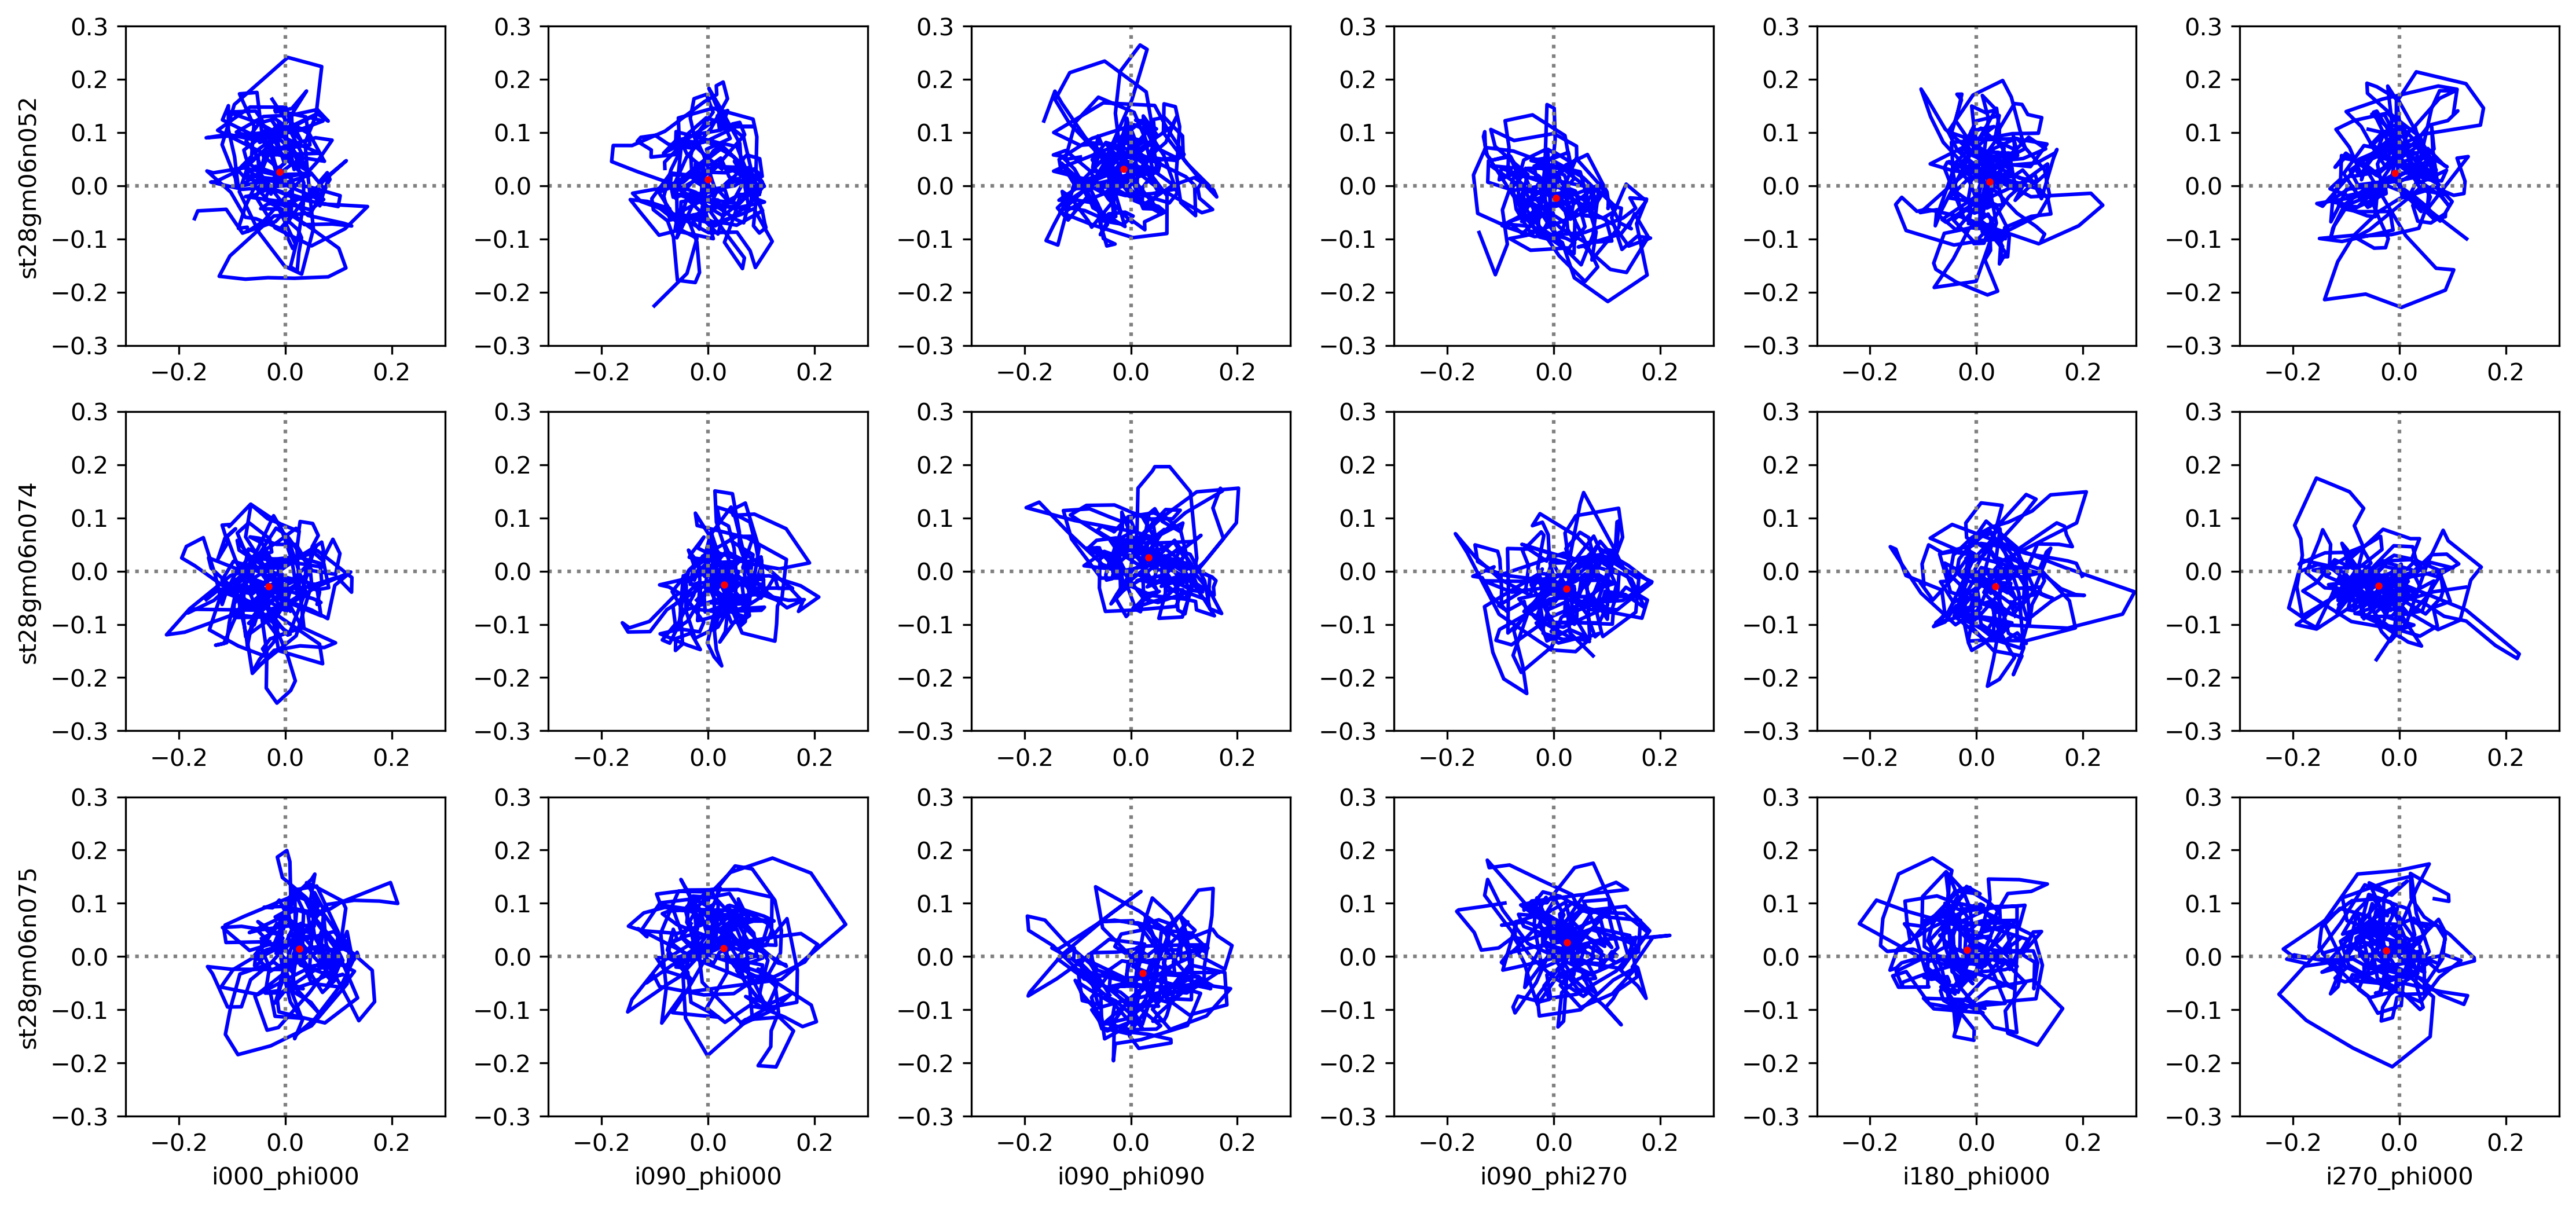

In [ ]:
# Load all LOS and 3 nodust-models' photocentre coords
# and plot pcR(time) and statistics of these
# First for each model
# and then all combined, should be the same
import numpy as np
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt



modelnames = [
    'st28gm06n052_timedep_nodust',
    'st28gm06n074_nodust',
    'st28gm06n075_nodust',
]
Nmodels = len(modelnames)
Rstar = 1.65

angles,snapshots,coordinatelist = a3d.load_photocentre_file(
    file_path=f'../r3dresults/{modelnames[0]}/photocentre_02um.dat'
)
Nangles = len(angles)
Nsnapshots = len(snapshots)

# Initiate figure
fig,ax = plt.subplots(
    Nmodels,Nangles,
    dpi=300,
    figsize = (15,7)
)
boxsize = 0.3

for nmodel,modelname in enumerate(modelnames):

    angles,snapshots,coordinatelist = a3d.load_photocentre_file(
        file_path=f'../r3dresults/{modelname}/photocentre_02um.dat'
    )
    print(modelname)


    # Extract all R(t) for all angles and save in a list
    for nangle,angle in enumerate(angles):
 
        pcX = coordinatelist[nangle][:,0]/Rstar
        pcY = coordinatelist[nangle][:,1]/Rstar
        pcR = coordinatelist[nangle][:,2]/Rstar

        pcX_average = np.mean(pcX)
        pcY_average = np.mean(pcY)
        pcR_average = np.mean(pcR)

        # Print average coordinates for all angles
        print(f'  {angle}: {pcX_average:.5f} , {pcY_average:.5f}  ({pcR_average:.5f})')
        
        # Plot x-y for all
        ax[nmodel,nangle].plot(
            pcX,
            pcY,
            'b'
        )
        # Add some labels and plot settings
        ax[nmodel,nangle].set_xlim([-boxsize,boxsize])
        ax[nmodel,nangle].set_ylim([-boxsize,boxsize])
        if nangle == 0:
            ax[nmodel,nangle].set_ylabel(
                modelname.split('_')[0]
            )
        if nmodel == 2:
            ax[nmodel,nangle].set_xlabel(
                angle
            )
        ax[nmodel,nangle].set(
            aspect='equal'
        )
        # Add lines to show central axis
        ax[nmodel,nangle].plot(
            [0,0],[-boxsize,boxsize],
            ':',color='grey'
        )
        ax[nmodel,nangle].plot(
            [-boxsize,boxsize],[0,0],
            ':',color='grey'
        )
        # Plot average coordinates as well
        ax[nmodel,nangle].plot(
            pcX_average,pcY_average,'r.',markersize=4
        )

    # Print empty line
    print()
fig.tight_layout()
fig.savefig('../r3dplots/all_photocentre_XYcoords_angles.pdf')





st28gm06n074_nodust : 0.09171608034366655 pm 0.04821130278310212 , Nsnaps: 261
st28gm06n074_nospikes : 0.1596184603510185 pm 0.16773105645617034 , Nsnaps: 301


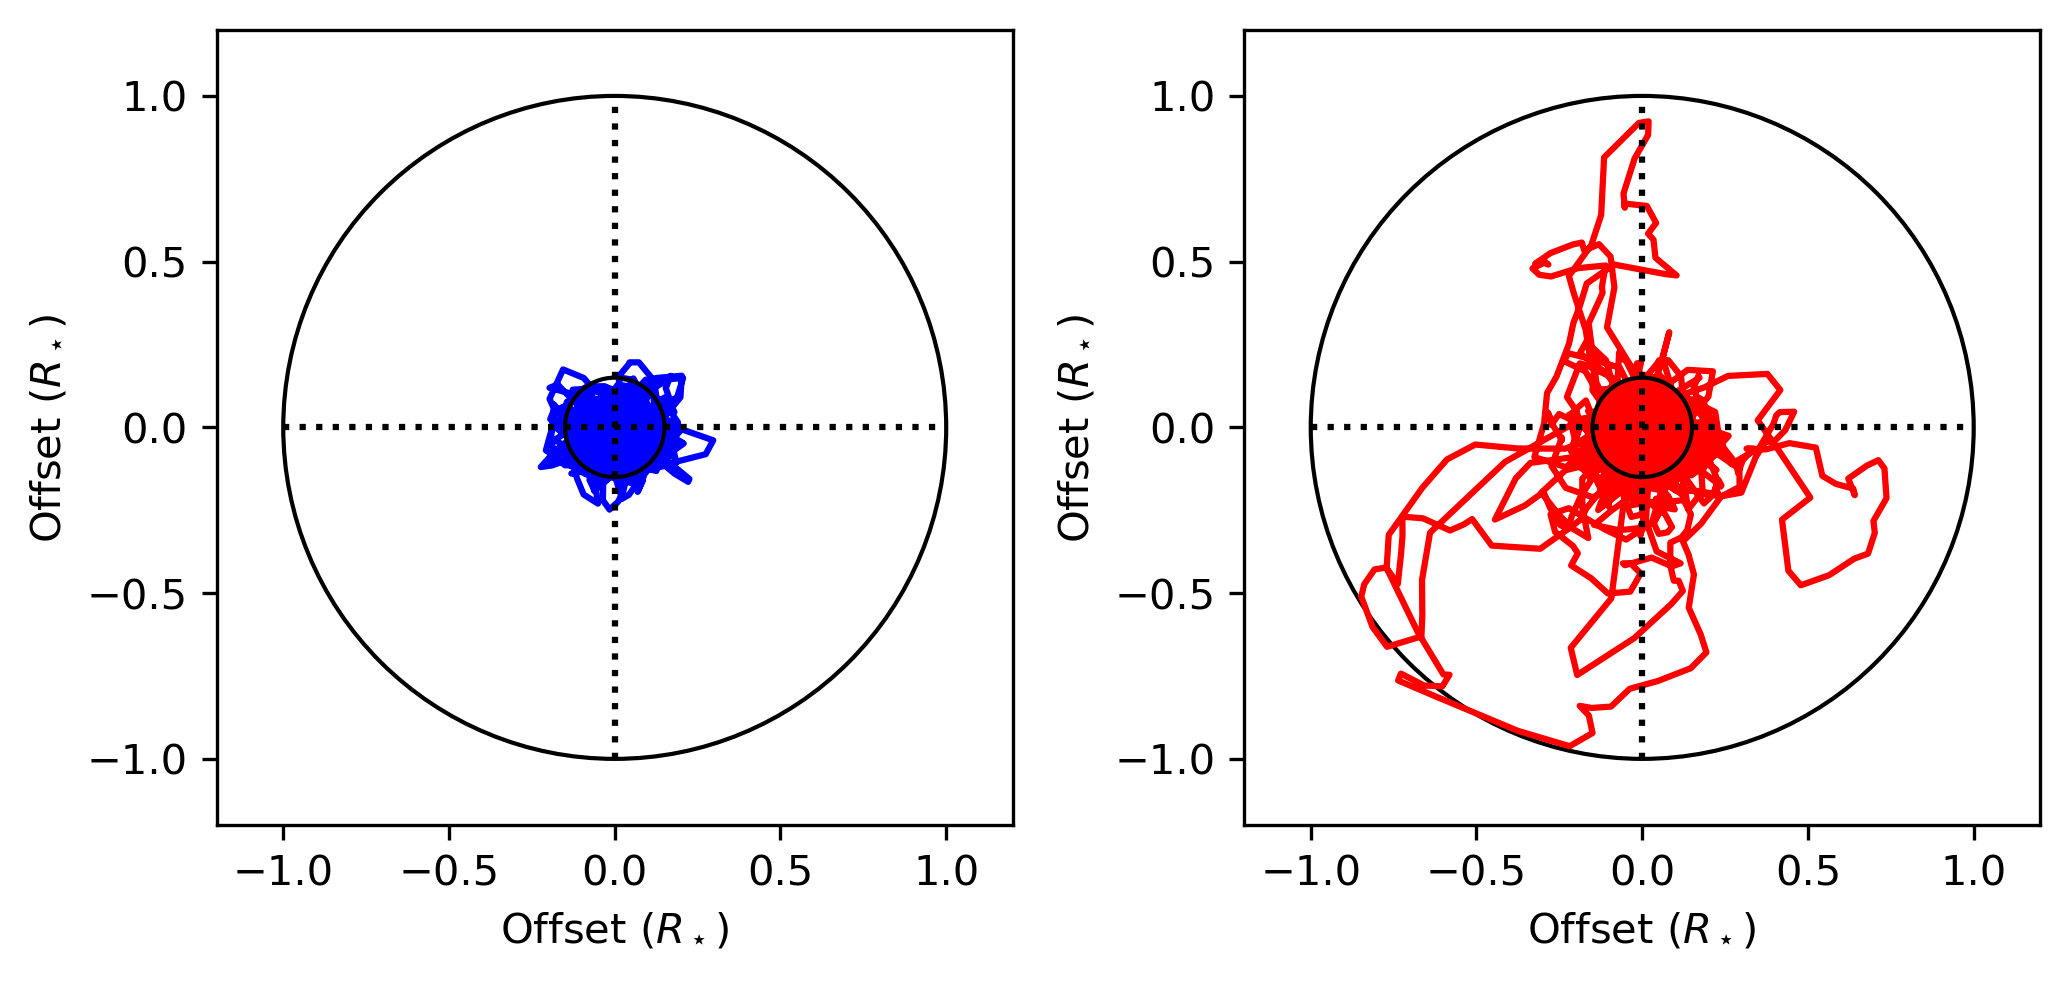

In [15]:
# Image for RS-2025R-proposal
# Left nodust of 074
# Right 074 with dust
# In terms of stellar radius
import matplotlib.pyplot as plt
import numpy as np
import analyze_r3d_functions as a3d


# Set some settings
models = [
    'st28gm06n074_nodust',
    'st28gm06n074_nospikes'
]
Rstar = 1.65

# Initiage figure
# Initiate figure
fig,ax = plt.subplots(
    1,2,
    dpi=300,
    figsize = (7,3.5)
)
pccolour = ['b','r']

for nmodel,model in enumerate(models):

    angles,snapshots,coordinatelist = a3d.load_photocentre_file(
        file_path=f'../r3dresults/{model}/photocentre_02um.dat'
    )
    Nangles = len(angles)
    Nsnapshots = len(snapshots)

    # Put all PCcoords in one array regardless of observed angle
    # With X,Y,R
    all_coords = np.zeros((Nangles*Nsnapshots,3))

    # Loop through angles and fill that array
    for nangle in range(Nangles):
        all_coords[nangle*Nsnapshots:(nangle+1)*Nsnapshots,0] = coordinatelist[nangle][:,0]/Rstar
        all_coords[nangle*Nsnapshots:(nangle+1)*Nsnapshots,1] = coordinatelist[nangle][:,1]/Rstar
        all_coords[nangle*Nsnapshots:(nangle+1)*Nsnapshots,2] = coordinatelist[nangle][:,2]/Rstar


    # Plot all photocentre coords
    ax[nmodel].plot(
        all_coords[:,0],all_coords[:,1],color=pccolour[nmodel]
    )
    # Plot circle for stars size and 15% av star
    ax[nmodel].add_patch(plt.Circle(
        (0,0),1,color='k',fill=False
    ))
    ax[nmodel].add_patch(plt.Circle(
        (0,0),0.15,color='k',fill=False,zorder=10
    ))
    # Plot middle lines
    ax[nmodel].plot(
        [-1,1],[0,0],'k:'
    )
    ax[nmodel].plot(
        [0,0],[-1,1],'k:'
    )
    ax[nmodel].set(
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        xlabel=r'Offset ($R_\star$)',
        ylabel=r'Offset ($R_\star$)',
        aspect='equal'
    )
    # Extract statistics for each model, average and std for each
    # to write in the proposal
    print(f'{model} : {np.average(all_coords[:,2])} pm {np.std(all_coords[:,2])} , Nsnaps: {Nsnapshots}')


fig.tight_layout()
fig.savefig('../r3dplots/074_photocentre_nodust_nospikes.pdf',dpi=300)


st28gm06n052_timedep_nodust
  i000_phi000 X: -0.01016 +- 0.05890
          Y: 0.02600 +- 0.08016
          Y: 0.09301 +- 0.04499
  i090_phi000 X: -0.00069 +- 0.06245
          Y: 0.01122 +- 0.07528
          Y: 0.08944 +- 0.04115
  i090_phi090 X: -0.01336 +- 0.07066
          Y: 0.03091 +- 0.06994
          Y: 0.09350 +- 0.04771
  i090_phi270 X: 0.00451 +- 0.07108
          Y: -0.02347 +- 0.06256
          Y: 0.08415 +- 0.04956
  i180_phi000 X: 0.02490 +- 0.06093
          Y: 0.00752 +- 0.08023
          Y: 0.09268 +- 0.04729
  i270_phi000 X: -0.00876 +- 0.06683
          Y: 0.02380 +- 0.07789
          Y: 0.09396 +- 0.04845

st28gm06n074_nodust
  i000_phi000 X: -0.03116 +- 0.06699
          Y: -0.02840 +- 0.06940
          Y: 0.09388 +- 0.04762
  i090_phi000 X: 0.03050 +- 0.06202
          Y: -0.02497 +- 0.06117
          Y: 0.08386 +- 0.04595
  i090_phi090 X: 0.03359 +- 0.06733
          Y: 0.02571 +- 0.05733
          Y: 0.08558 +- 0.04780
  i090_phi270 X: 0.02395 +- 0.07680
       

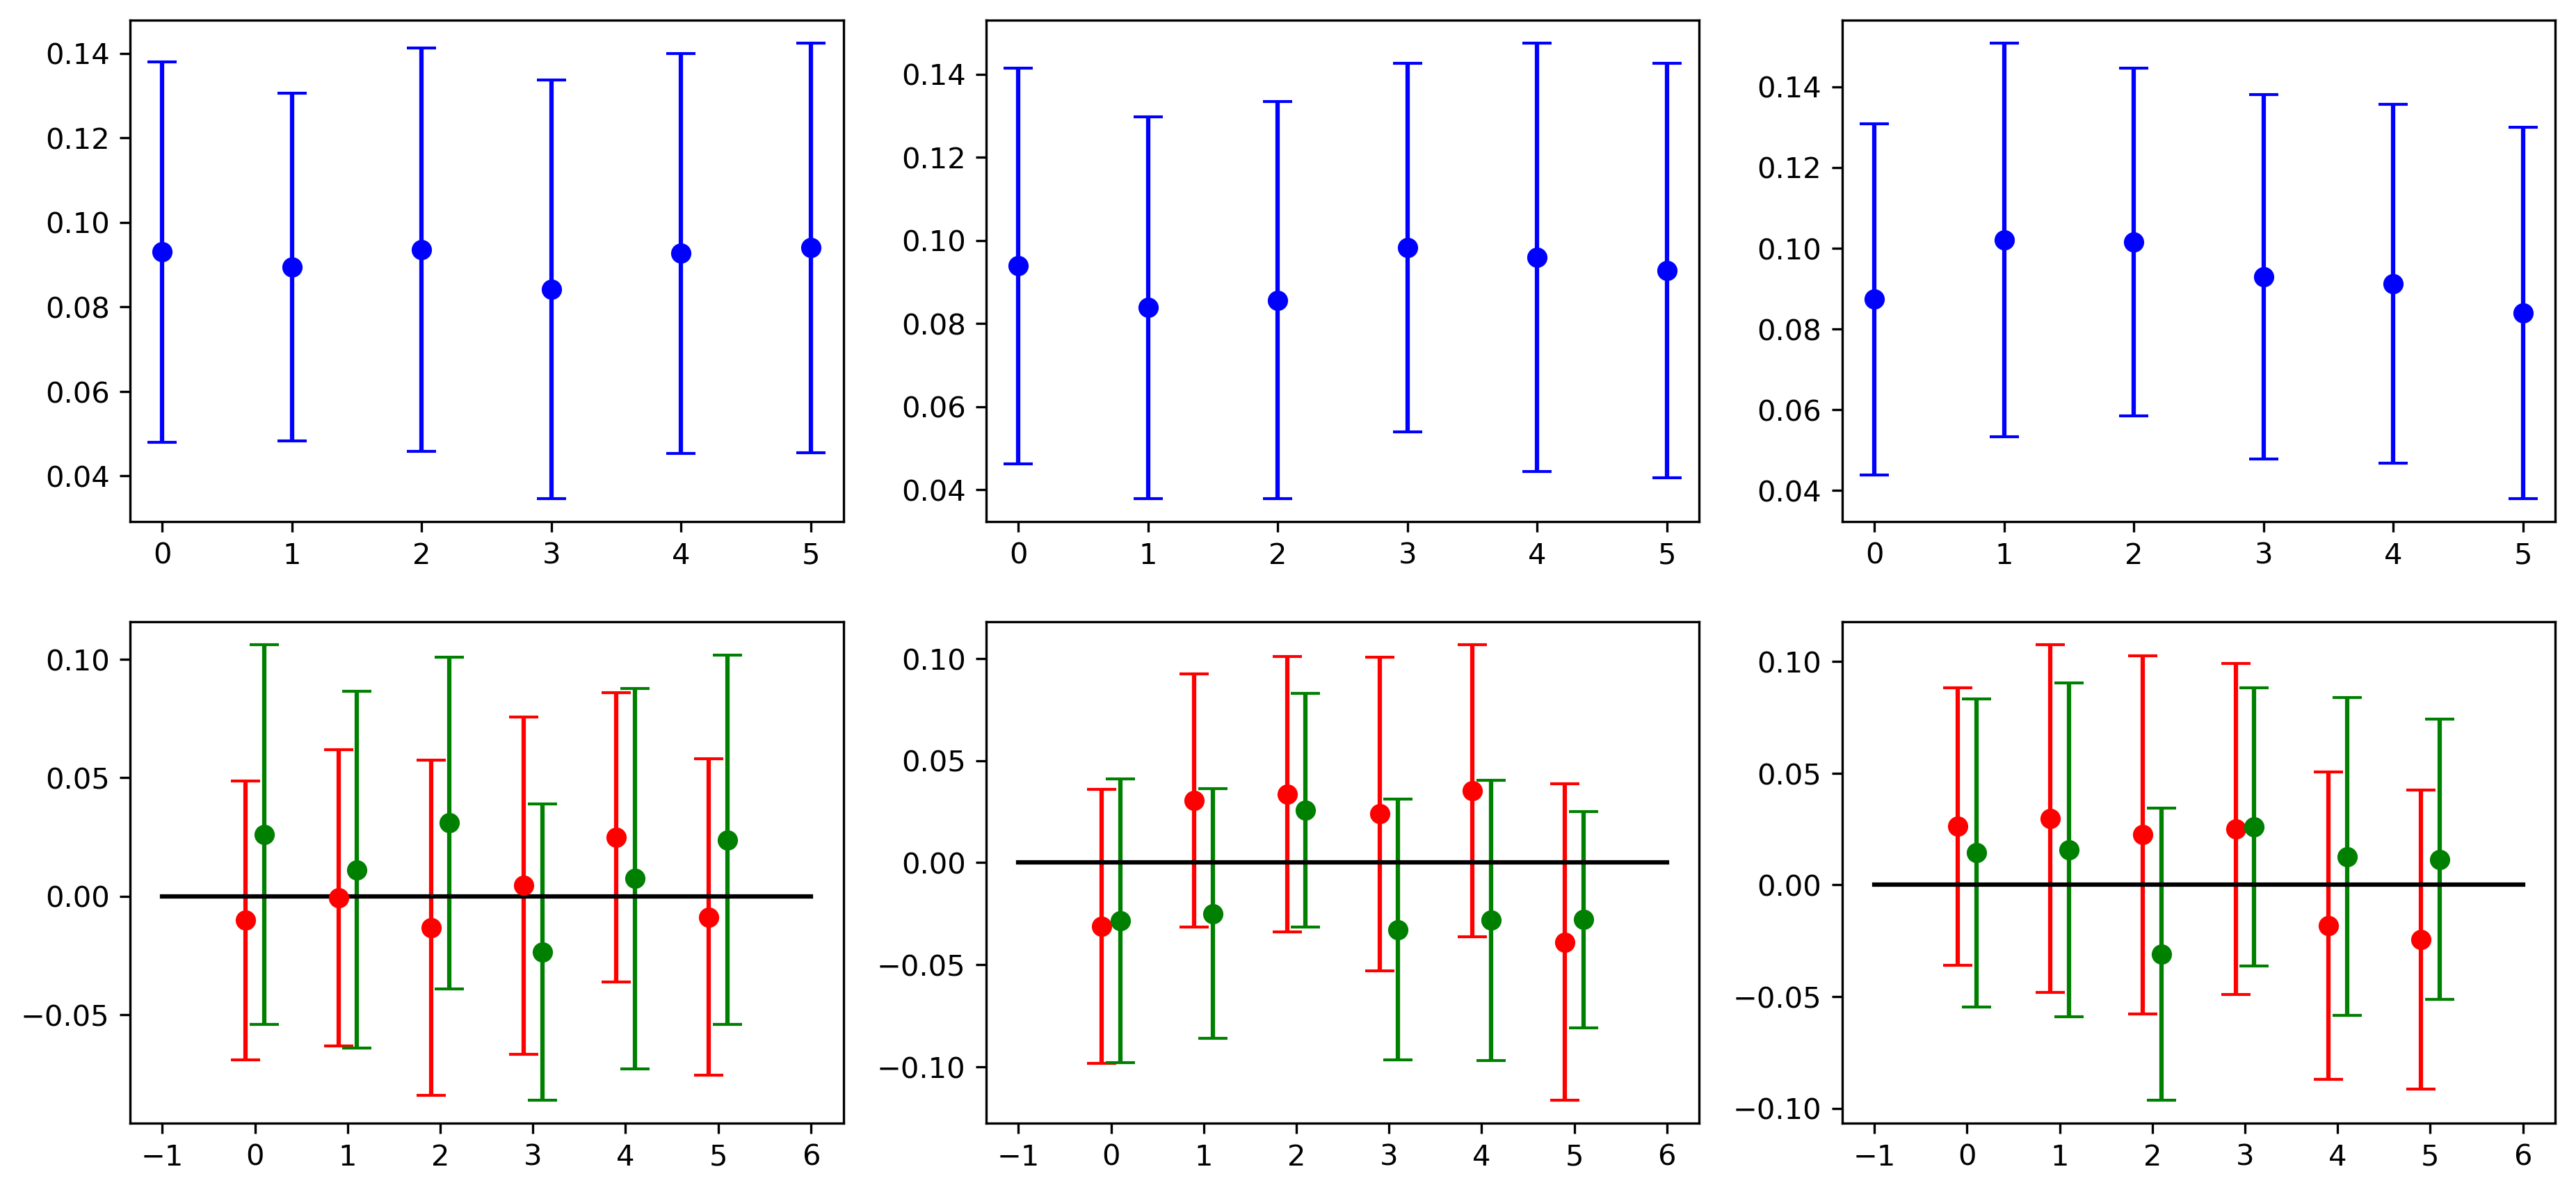

In [ ]:
# TODO
# print average XY-coords for each LOS,  plusminus std
# Plot average XY and R vs LOS
#
# Save these numbers somewhere





import numpy as np
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt



modelnames = [
    'st28gm06n052_timedep_nodust',
    'st28gm06n074_nodust',
    'st28gm06n075_nodust',
]
Nmodels = len(modelnames)
Rstar = 1.65

angles,snapshots,coordinatelist = a3d.load_photocentre_file(
    file_path=f'../r3dresults/{modelnames[0]}/photocentre_02um.dat'
)
Nangles = len(angles)
Nsnapshots = len(snapshots)

# Initiate figure
fig,ax = plt.subplots(
    2,Nmodels,
    dpi=300,
    figsize = (15,7)
)
boxsize = 0.3

for nmodel,modelname in enumerate(modelnames):

    angles,snapshots,coordinatelist = a3d.load_photocentre_file(
        file_path=f'../r3dresults/{modelname}/photocentre_02um.dat'
    )
    print(modelname)


    # Extract all pc(t) for all angles and save in a list
    for nangle,angle in enumerate(angles):
 
        pcX = coordinatelist[nangle][:,0]/Rstar
        pcY = coordinatelist[nangle][:,1]/Rstar
        pcR = coordinatelist[nangle][:,2]/Rstar

        pcX_average = np.mean(pcX)
        pcY_average = np.mean(pcY)
        pcR_average = np.mean(pcR)

        pcX_std = np.std(pcX)
        pcY_std = np.std(pcY)
        pcR_std = np.std(pcR)


        # Print average coordinates for all angles
        print(f'  {angle} X: {pcX_average:.5f} +- {pcX_std:.5f}')
        print(f'          Y: {pcY_average:.5f} +- {pcY_std:.5f}')
        print(f'          R: {pcR_average:.5f} +- {pcR_std:.5f}')

        # Plot LOS-variations of R
        ax[0,nmodel].errorbar(
            nangle,pcR_average,yerr=pcR_std,
            color='b',fmt='o',capsize=5
        )
        # Plot LOS-variations of X&Y
        ax[1,nmodel].errorbar(
            nangle-0.1,pcX_average,yerr=pcX_std,
            color='r',fmt='o',capsize=5
        )
        ax[1,nmodel].errorbar(
            nangle+0.1,pcY_average,yerr=pcY_std,
            color='g',fmt='o',capsize=5
        )
    # And a zero-line
    ax[1,nmodel].plot(
        [-1,6],[0,0],'k'
    )



    # Print empty line
    print()











# Compare with large sphere

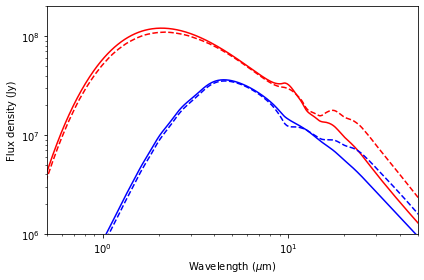

In [9]:
# Plot SEDs of each preliminary variant
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt

# No extinction
wavelength, sednormal = a3d.load_spectrum(
    path = '../r3dresults/st28gm06n052_largesphere/199_i090_phi270/spectrum_i090_phi270.out'
)
wavelength, sedlarge = a3d.load_spectrum(
    path = '../r3dresults/st28gm06n052_largesphere/199_i090_phi270/spectrum_199_largesphere.out'
)
plt.plot(wavelength,sednormal,'r-')
plt.plot(wavelength,sedlarge,'r--')
# Utan kraftig extinction från början blir det inte stor skillnad på
# korta våglängder men på längre så ser jag att 10um-featuren blir
# svagare medans på >20um är det maffig stoftemission

# With extinction
wavelength, sednormal = a3d.load_spectrum(
    path = '../r3dresults/st28gm06n052_largesphere/225_i090_phi090/spectrum_i090_phi090.out'
)
wavelength, sedlarge = a3d.load_spectrum(
    path = '../r3dresults/st28gm06n052_largesphere/225_i090_phi090/spectrum_225_largesphere.out'
)
plt.plot(wavelength,sednormal,'b-')
plt.plot(wavelength,sedlarge,'b--')
# Inte stor skillnad på korta våglängder här heller, däremot mer Si
# absorption vid 10um och kraftig emission på >20um.


plt.xscale('log')
plt.yscale('log')
plt.xlim([0.5,50])
plt.ylim([1e6,2e8])
plt.ylabel('Flux density (Jy)')
plt.xlabel(r'Wavelength ($\mu$m)')
plt.tight_layout()
plt.savefig('../r3dresults/st28gm06n052_largesphere/compare_sed.pdf', dpi=300)


# Compare Luminosities/flux densities

## Compare lums from different seeds and nospikes

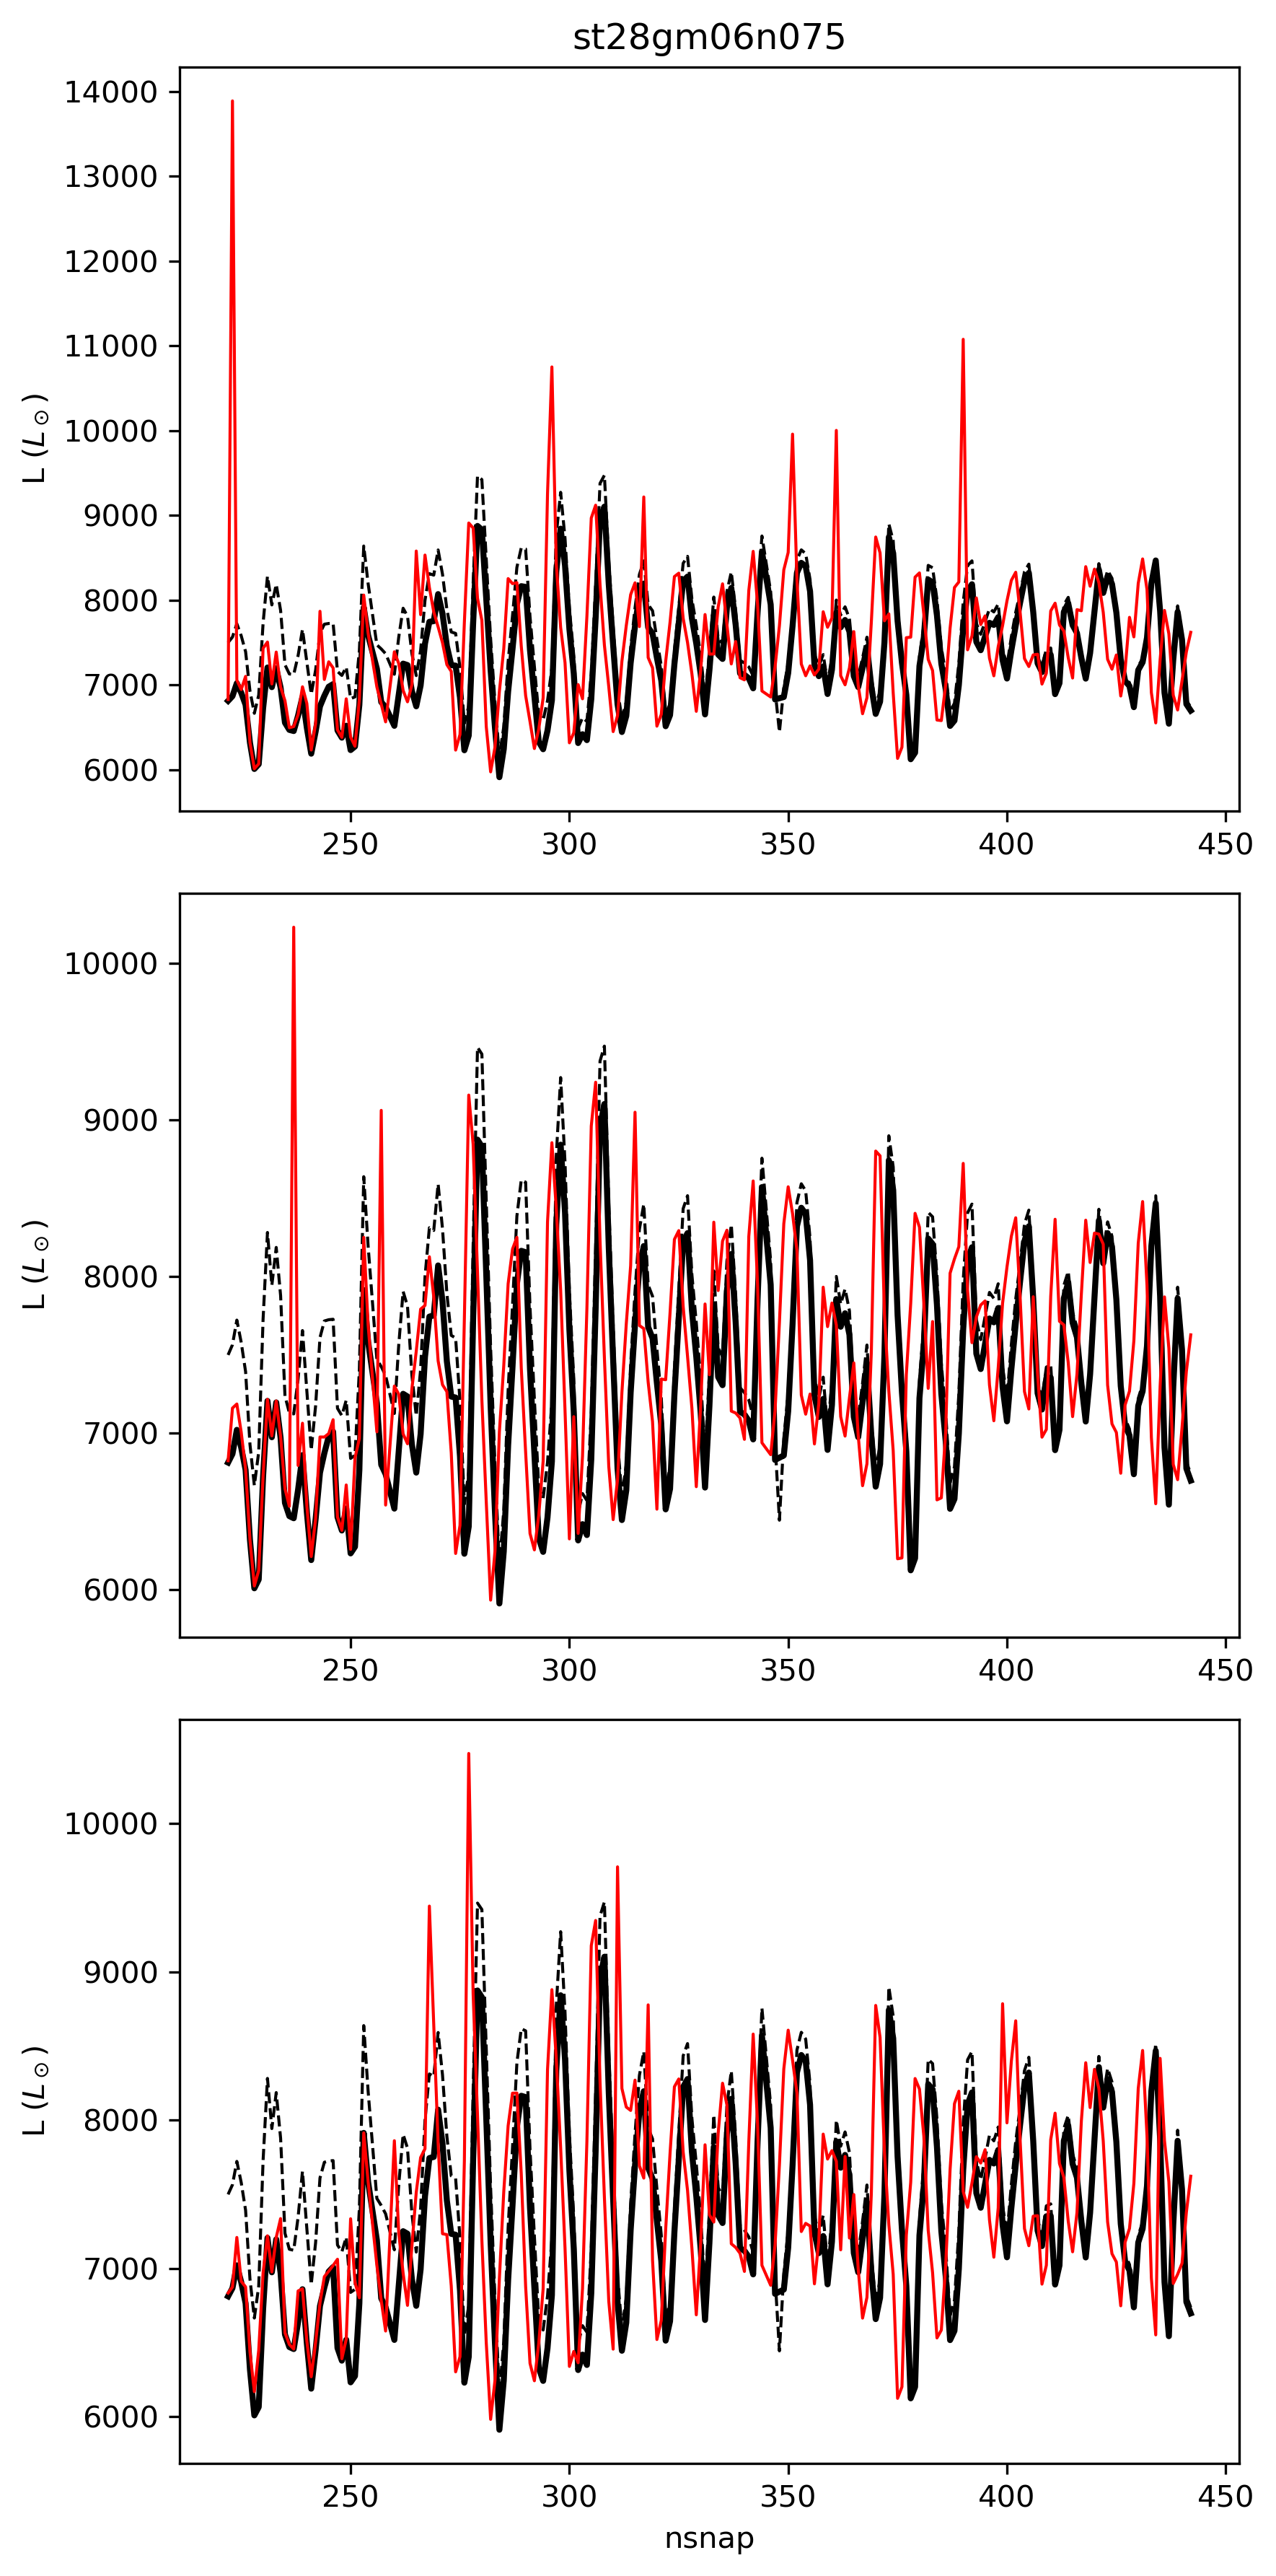

In [8]:
# Compute time-dependent Lums for the different Seeds and compare
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
import numpy as np
import os

Lsol = 3.828e26 # W


# Define figure-objects
fig,ax =  plt.subplots(
    3,1,
    figsize=(6, 12),
    dpi=300
)


# Folder names
data_folder = '../../exwings_archivedata/r3dresults_paper2'
#model = 'st28gm06n052_timedep'
#model = 'st28gm06n074'
model = 'st28gm06n075'
seeds = [
    '1','2','3'
]
Nseeds = len(seeds)
angles = [
    'i000_phi000',
    'i090_phi000',
    'i090_phi090',
    'i090_phi270',
    'i180_phi000',
    'i270_phi000',
]
Nangles = len(angles)
nospikes_folder = f'../r3dresults/{model}_nospikes/'
nodust_folder = f'../r3dresults/{model}_nodust/'

# Load snapshot times
phases = [int(filename) for filename in os.listdir(f'{data_folder}/{model}_1') if os.path.isdir(f'{data_folder}/{model}_1/{filename}')]
phases.sort()
#phases=[180,181]
Nphases = len(phases)
phasetimes = np.loadtxt(f'{nospikes_folder}/snapshot_yr.dat')

# Define time dependent arrays to fill
bollum_nospikes = np.zeros(Nphases)
bollum_nodust = np.zeros(Nphases)
bollum_seeds = np.zeros((Nseeds,Nphases))


# Load nospike and nodust lums
luminosities_nospikes = np.loadtxt(f'{nospikes_folder}/luminosity.dat')
luminosities_nodust = np.loadtxt(f'{nodust_folder}/luminosity.dat')


# Open file to write Lums in, only bolometric lums, but for each seed, not nospikes
with open(f'../r3dresults/{model}_nospikes/luminosity_bol_allseeds.dat', 'w') as fbol:

    # Write header
    fbol.writelines('# Approximate bolometric luminosity (Lsol) of each seed. Averages at the bottom!\n')
    fbol.writelines('#  Phase    seed1       seed2       seed3\n')

    # Extract bol-lum over time for included snapshots
    for nsnap in range(Nphases):

        # First for nodust and nospike data (only for paper2-snapshots)
        if nsnap+phases[0] == luminosities_nospikes[nsnap,0]:
            bollum_nospikes[nsnap] = luminosities_nospikes[nsnap,-1]
            bollum_nodust[nsnap] =  luminosities_nodust[nsnap,-1]

        # Then extract seed-data-lums and compute bolometric lums
        for seed in seeds:
            lum_temp = 0
            for angle in angles:
                lum_temp += a3d.compute_sed_luminosity(
                    path = f'{data_folder}/{model}_{seed}/{phases[nsnap]:03d}/spectrum_{angle}.out',
                    distance = 1
                )/Lsol
                bollum_seeds[int(seed)-1,nsnap] = lum_temp/Nangles

        # Write each data line of time-dep luminosities
        fbol.writelines(f'   {nsnap+phases[0]}      {bollum_seeds[0,nsnap]:.3f}    {bollum_seeds[1,nsnap]:.3f}    {bollum_seeds[2,nsnap]:.3f}\n')

    # Extract averages
    avr_bollum_nodust = np.mean(bollum_nodust)
    avr_bollum_nospikes = np.mean(bollum_nospikes)
    avr_bollum_seed1 = np.mean(bollum_seeds[0,:])
    avr_bollum_seed2 = np.mean(bollum_seeds[1,:])
    avr_bollum_seed3 = np.mean(bollum_seeds[2,:])

    # And print average lums for all in file as well
    fbol.writelines('# \n')
    fbol.writelines('# Average Lums for all seeds and nospikes\n')
    fbol.writelines('#            Nodust     Nospikes    seed1    seed2    seed3\n')
    fbol.writelines(f'# Lums    :  {avr_bollum_nodust:.1f}     {avr_bollum_nospikes:.1f}      {avr_bollum_seed1:.1f}   {avr_bollum_seed2:.1f}   {avr_bollum_seed3:.1f}\n')
    fbol.writelines(f'# Ratio   :   {avr_bollum_nodust/avr_bollum_nospikes:.3f}      1.000       {avr_bollum_seed1/avr_bollum_nospikes:.3f}    {avr_bollum_seed2/avr_bollum_nospikes:.3f}    {avr_bollum_seed3/avr_bollum_nospikes:.3f}\n')
    fbol.writelines(f'# Average seed ratio: {(avr_bollum_seed1/avr_bollum_nospikes + avr_bollum_seed2/avr_bollum_nospikes + avr_bollum_seed3/avr_bollum_nospikes)/3:.3f}')   

# Plot
for nseed in range(Nseeds):
    # Plot nospikes and nodust-data
    ax[nseed].plot(phases,bollum_nospikes,'k-',linewidth=2)
    ax[nseed].plot(phases,bollum_nodust,'k--',linewidth=1)
    ax[nseed].plot(phases,bollum_seeds[nseed,:],'r',linewidth=1)
    ax[nseed].set_ylabel(r'L $(L_\odot)$')
ax[0].set_title(model.split('_')[0])
ax[-1].set_xlabel('nsnap')
fig.tight_layout()
fig.savefig(f"../paper2/missing_flux/lum_{model.split('_')[0]}.pdf", dpi=300)



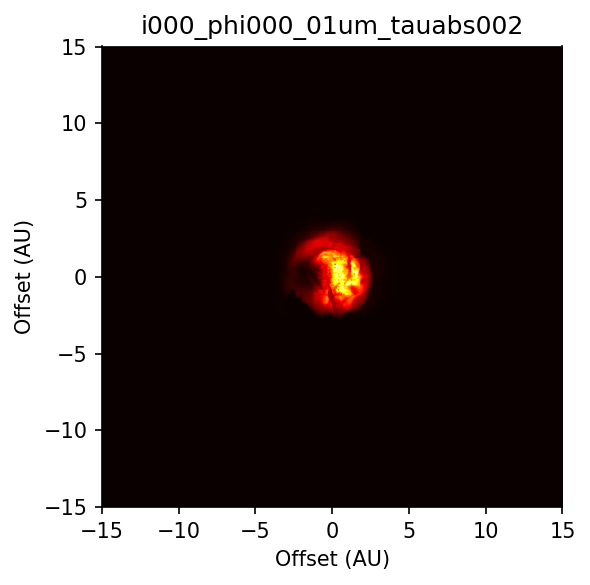

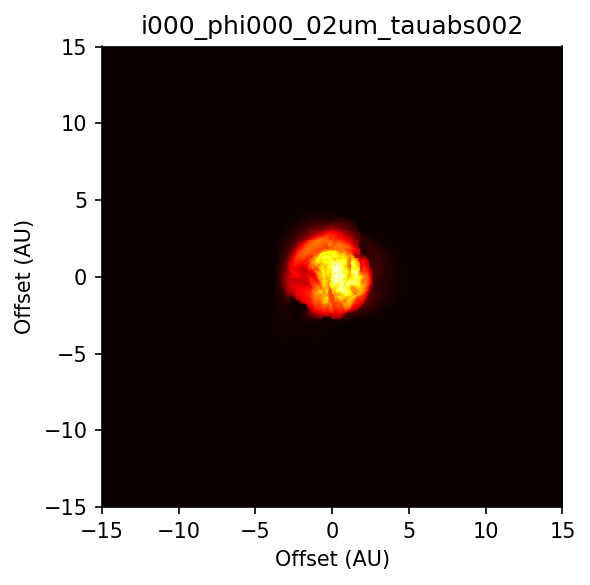

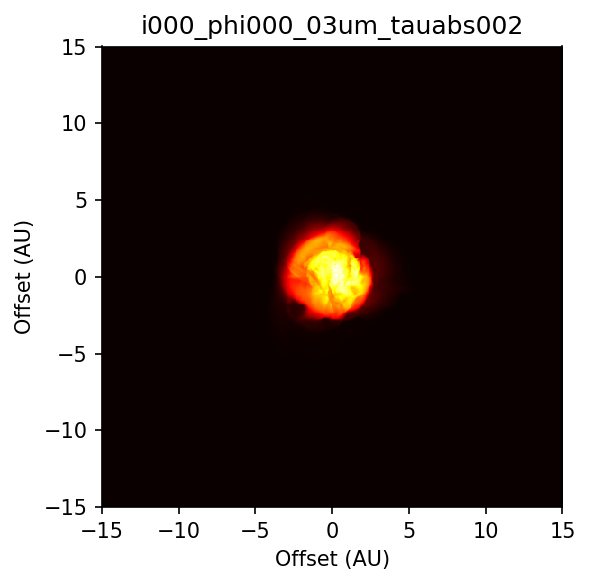

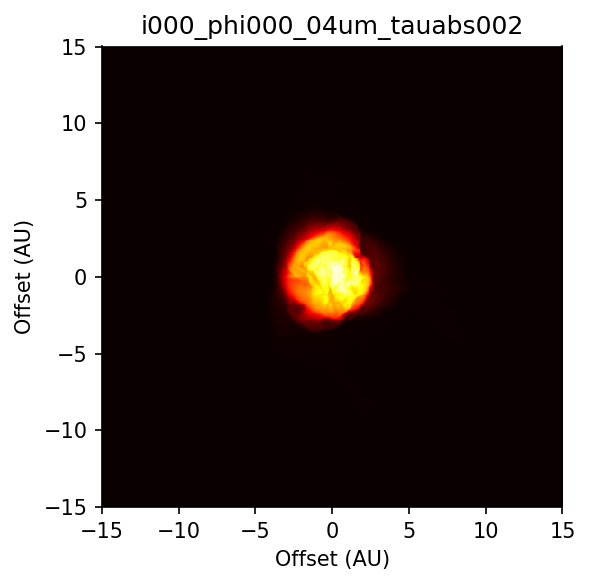

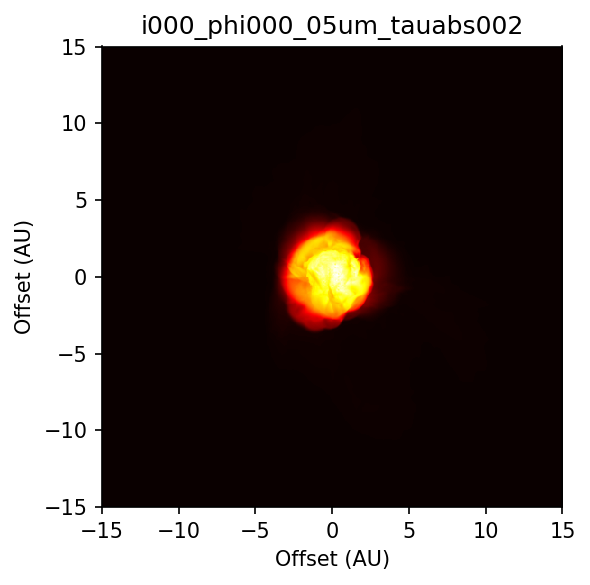

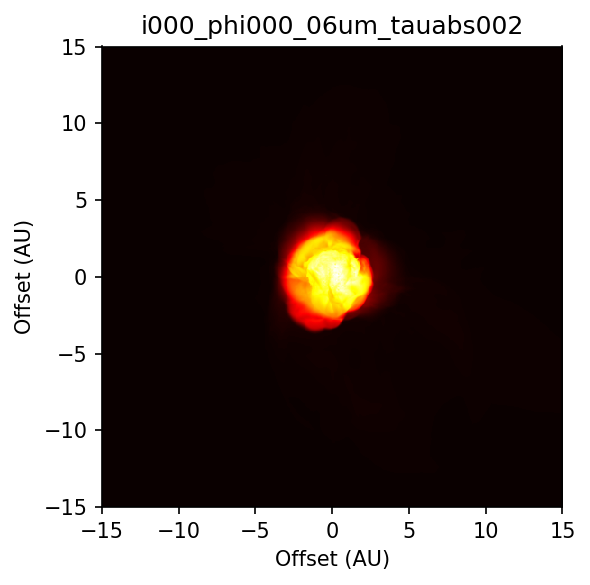

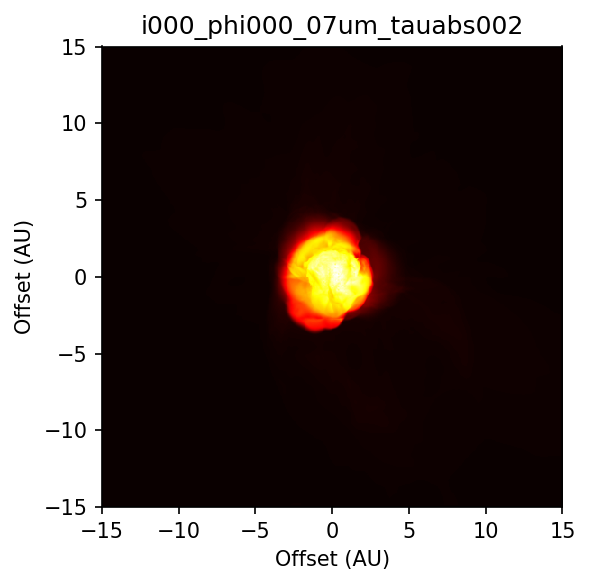

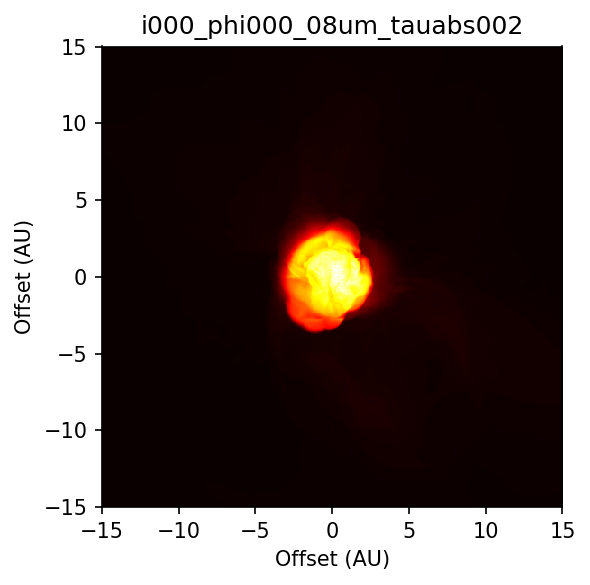

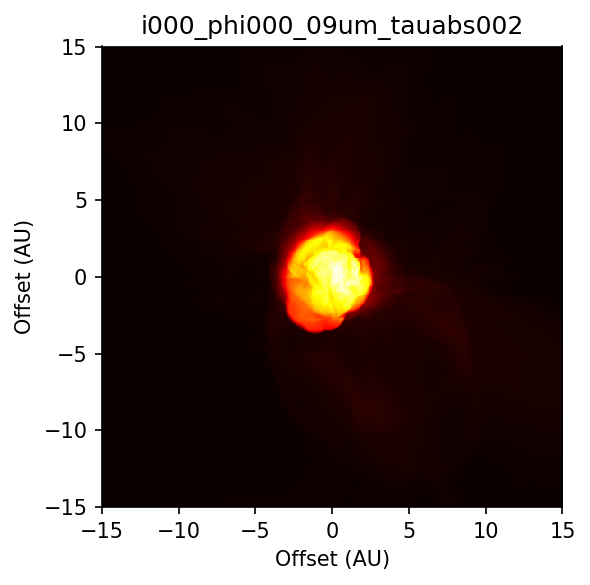

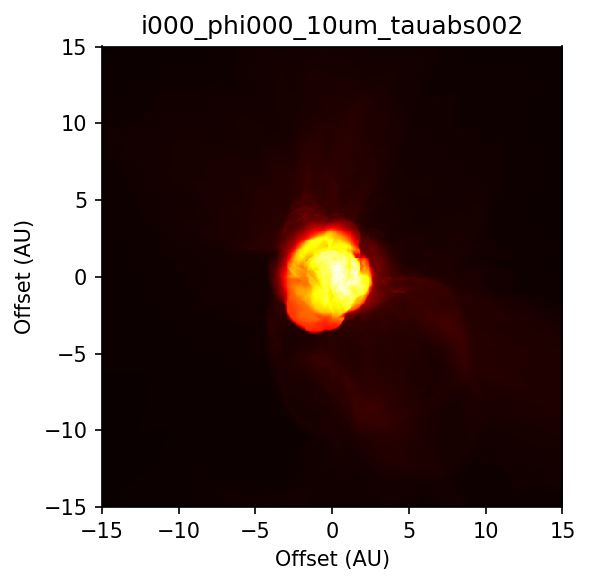

In [21]:


# Look at images with different max_tauabs
import analyze_r3d_functions as a3d

model = 'st28gm06n075'
angle = 'i000_phi000'
snapshot = 201
tauabs = 2
wavelengths = [1,2,3,4,5,6,7,8,9,10]

path = f'../r3dresults/{model}_tauabstests/{snapshot:03d}_tauabs{tauabs:03d}/'
images = [
    f'image_{angle}_{wavelength:02d}um_tauabs{tauabs:03d}.out' for wavelength in wavelengths
]

with open(f'{path}sed.dat', 'w') as fflux:
    # Write header
    fflux.writelines(f'# SED based on images in this folder:\n# {path}\n# Wavelength (um)   Flux (Jy at 1pc)\n')

    for wavelength in wavelengths:
        # Plot images
        fig,ax,flux = a3d.plot_images(
            path=path,
            images=[f'image_{angle}_{wavelength:02d}um_tauabs{tauabs:03d}.out']
        )
        # Write wavelength and flux in Jy
        fflux.writelines(f'  {wavelength:2d}                {flux[0]}\n')








In [ ]:
# Compare fluxes and SEDs from data with different tau_abs and original data

# Load pre-made SED-files

# Extract fluxes wavelengths from no-psike 0-0-SED
# and print original fluxes and tauabs-fluxes below






['image_i000_phi000_01um_tauabs02.out',
 'image_i000_phi000_02um_tauabs02.out',
 'image_i000_phi000_03um_tauabs02.out',
 'image_i000_phi000_04um_tauabs02.out',
 'image_i000_phi000_05um_tauabs02.out',
 'image_i000_phi000_06um_tauabs02.out',
 'image_i000_phi000_07um_tauabs02.out',
 'image_i000_phi000_08um_tauabs02.out',
 'image_i000_phi000_09um_tauabs02.out',
 'image_i000_phi000_10um_tauabs02.out']